In [1]:
import numpy as np
from IPython.display import clear_output
import matplotlib.pylab as plt
from time import sleep
%matplotlib inline

In [2]:
import gym 
from collections import namedtuple, defaultdict
import pandas as pd
import numpy as np
from gym.utils import seeding
from gym.spaces import Discrete

class ISTestEnv(gym.Env):
    def __init__(self):
        self.n_items = 10
        self.rewards = list(range(1, self.n_items+1))
        
        self.action_space = Discrete(self.n_items)
        self.observation_space = None
       
    
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        observation = None
        reward = self.rewards[action]
        done = None
        info = None
        return observation, reward, done, info

    def reset(self):
        observation = None
        return observation 

    
class Top2TestEnv(gym.Env):
    def __init__(self):
        self.n_items = 10
        self.rewards = np.ones(shape=(self.n_items))
        self.rewards[-1] = 10
        self.rewards[-2] = 9
        
        self.action_space = Discrete(self.n_items)
        self.observation_space = None
       
    
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        observation = None
        reward = self.rewards[action]
        done = None
        info = None
        return observation, reward, done, info

    def reset(self):
        observation = None
        return observation     


In [60]:
env = Top2TestEnv()
#env = ISTestEnv()
env.reset()
env.step(9)

(None, 10.0, None, None)

In [61]:
theta = np.zeros(env.action_space.n)

pi = np.exp(theta)
pi = pi / np.sum(pi)

pi

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [52]:
def grad_pi(pi, a):
    
    grad = []
    for i in range(len(pi)):
        grad.append(int(i==a) - pi[a])
    
    return grad

def compute_rewards_to_go(rewards, gamma):
    rewards_to_go = [rewards[-1]]
    for k in range(2, len(rewards)+1):
        rewards_to_go = [rewards[-k] + gamma * rewards_to_go[0]] + rewards_to_go
    return rewards_to_go

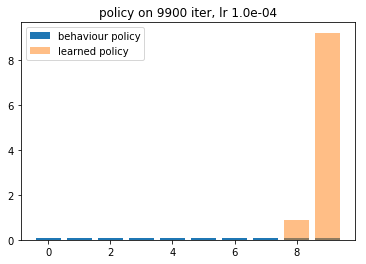

In [64]:
lr = 0.0001
N = 10000
rollout_size = 5
gamma = 0.9
theta = np.zeros(env.action_space.n)

b = np.ones_like(theta) / len(theta)
#b = [ (10-i)/55 for i in range(len(theta))]

IScorrection = True
TopKcorrection = True
K = 2

for n in range(N):
    
    actions = []
    rewards = []
    probas = []
    
    for i in range(rollout_size):
        a = np.random.choice(list(range(len(theta))), p=b)
        _, r, _, _ = env.step(a)
        
        actions.append(a)
        rewards.append(r)
        probas.append(b[a])
        
        
    pi = np.exp(theta)
    pi = pi / np.sum(pi)
     
    rewards_to_go = compute_rewards_to_go(rewards, gamma)  
    grad = np.zeros_like(theta)
    for j, a in enumerate(actions):
        delta = np.multiply(grad_pi(pi, a), rewards_to_go[j]) 
        
        if IScorrection:
            delta = delta * pi[a] / b[a]
        
        if TopKcorrection:
            lambdaK = K*(1 - pi[a])**(K-1)
            delta = delta * lambdaK
        
        grad += delta 
    
    theta = theta + lr*grad
    
    if n % 100 == 0:
        clear_output(wait=True)
        plt.clf()
        plt.bar(range(len(theta)), b, label = 'behaviour policy')
        
        plt.bar(range(len(theta)), np.exp(theta), alpha=0.5, label = 'learned policy')
        plt.title('policy on %d iter, lr %.1e' % (n, lr))
        
        plt.legend()
        plt.show();
    
    

In [7]:
import gym 
from collections import namedtuple, defaultdict
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, accuracy, SVD
from sklearn.model_selection import train_test_split
from gym.utils import seeding

Interaction = namedtuple('Interaction', ['t', 'uid', 'recs', 'rewards', 'probs', 'best_ps', 'ranks'])

class MovieLens(gym.Env):
    def __init__(self):
        self.embedding_dimension = 3
        self.n_rec = 1
        self.seed(0)
        
        self.df = pd.read_csv('./data/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
        
        self.train_ratings, self.test_ratings = train_test_split(self.df, test_size=0.2, random_state=0)

        reader = Reader(rating_scale=(1, 5))
        train_spr = Dataset.load_from_df(self.train_ratings[['user_id','item_id','rating']],reader).build_full_trainset()
        test_spr = Dataset.load_from_df(self.test_ratings[['user_id','item_id','rating']],reader).build_full_trainset()
        test_spr = test_spr.build_testset()
        
        self.algo = SVD(n_factors=self.embedding_dimension, biased=False)
        self.algo.fit(train_spr)
        
        self.users = self.algo.pu[:40]
        self.items = self.algo.qi[:500]
        self.n_users = len(self.users)
        self.n_items = len(self.items)
        
        self.active_uid = self.np_random.choice(range(self.n_users))
        
        self.bought_items = defaultdict(set)
        
        # logs
        self.steps_count = 0
        self.interactions = []
        
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
            
    def _get_observation(self):
        pos = 0
        self.item_pos2id = {}
        possible_items = []
        
        for i in set(range(self.n_items)) - self.bought_items[self.active_uid]:
            possible_items.append(self.items[i])
            
            self.item_pos2id[pos] = i
            pos += 1
        
        user_repr = self.users[self.active_uid]
        return (np.array(user_repr), np.array(possible_items))
        
    
    def _reward(self, action):
        assert len(action) == self.n_rec
        uid = self.active_uid
        rewards = []
        for a in action:
            iid = self.item_pos2id[a]
            
            r = self.algo.estimate(u=uid, i=iid)
            rewards.append(r)
            
            self.bought_items[uid].add(iid)
        
        self.interactions.append(Interaction(t=self.steps_count,
                                             uid=uid,
                                             recs=action,
                                             rewards=rewards,
                                             probs=None,
                                             best_ps=None,
                                             ranks=None))
        
        return np.sum(rewards)
    
    def _evolve(self):
        
        users_to_play = []
        for i in range(self.n_users):
            if len(self.bought_items[i]) < (self.n_items - self.n_rec):
                users_to_play.append(i)
                
        self.active_uid = self.np_random.choice(users_to_play)
        
    def step(self, action):
        self.steps_count += 1
        reward = self._reward(action)
        
        self._evolve()
        observation = self._get_observation()
        done = None
        info = {'userid' : self.active_uid}
        #print(len(observation[1]))
        return observation, reward, done, info

    def reset(self):
        observation = self._get_observation()
        return observation


In [8]:
base_env = MovieLens()

In [9]:
from copy import deepcopy

In [10]:
env = deepcopy(base_env)

In [11]:
# make rollout 
def make_rollout(env, steps=10, n_rec=4):
    states = []
    chosen_actions = []
    possible_actions = []
    beta_probs = []
    rewards = []
    
    s, A = env.reset()
        
    for i in range(steps):
        N = A.shape[0]
        beta = 1./N
        a = np.random.choice(list(range(N)), size=n_rec)

        states.append(s)
        chosen_actions.append(a)
        possible_actions.append(A)
        beta_probs.append(beta)
        
        (s, A), r, done, info = env.step(a)
        
        rewards.append(r)
        
    return [np.array(x) for x in (states, chosen_actions, possible_actions, beta_probs, rewards)]
        

In [12]:
# rollout

In [13]:
import tensorflow as tf

/home/anton/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [14]:
gamma = 0.9
rollout_size = 10

In [15]:
rollout = make_rollout(env, steps=10, n_rec=1)
states, chosen_actions, possible_actions, beta_probs, rewards = rollout
rewards_to_go = compute_rewards_to_go(rewards, gamma)

In [16]:
state_size = 3
action_size = 3

In [17]:
sess = tf.InteractiveSession()

In [18]:
states_ph = tf.placeholder(tf.float32, [1, state_size], name='state')
actions_ph = tf.placeholder(tf.float32, [1, action_size], name='action')
action_ids_ph = tf.placeholder(tf.int64, [1], name='action_id')
possible_actions_ph = tf.placeholder(tf.float32, [None, action_size], name='possible_actions')
reward_to_go_ph = tf.placeholder(tf.float32, name='reward_to_go')
beta_ph = tf.placeholder(tf.float32, name='beta')

In [19]:
contexts = tf.concat([states_ph, actions_ph], axis=1)



context_size = action_size + state_size
s_size = action_size

#observations = tf.expand_dims(contexts, axis=0)
# print(observations.shape)
init_states_ph = tf.placeholder(tf.float32, (1, s_size))
init_states = init_states_ph

#with tf.variable_scope('FCN', reuse=tf.AUTO_REUSE):
    
ua_t = tf.transpose(contexts) # 1x6
s_t = tf.transpose(init_states) # 1x3

W_a = tf.get_variable("W_a", shape=[s_size, context_size],
                      initializer=tf.contrib.layers.xavier_initializer())

W_z = tf.get_variable("W_z", shape=[s_size, context_size],
                      initializer=tf.contrib.layers.xavier_initializer())

W_i = tf.get_variable("W_i", shape=[s_size, context_size],
                      initializer=tf.contrib.layers.xavier_initializer())

b_i = tf.get_variable("b_i", shape=[s_size, 1],
                      initializer=tf.contrib.layers.xavier_initializer())


U_z = tf.get_variable("U_z", shape=[s_size, s_size],
                      initializer=tf.contrib.layers.xavier_initializer())

U_i = tf.get_variable("U_i", shape=[s_size, s_size],
                      initializer=tf.contrib.layers.xavier_initializer())

b_z = tf.get_variable("b_z", shape=[s_size, 1],
                      initializer=tf.contrib.layers.xavier_initializer())


z = tf.sigmoid(tf.matmul(U_z, s_t) + tf.matmul(W_z, ua_t) + b_z) # s_size x 1
i = tf.sigmoid(tf.matmul(U_i, s_t) + tf.matmul(W_i, ua_t) + b_i) # s_size x 1

s_tp1 = z * tf.tanh(s_t) + i * tf.tanh(tf.matmul(W_a, ua_t))

output = final_state = s_tp1

# with tf.variable_scope("rnn"):
#     gru_cell = tf.contrib.rnn.BasicRNNCell(gru_unit_size)

#     output, final_state = tf.nn.dynamic_rnn(gru_cell, inputs=observations, initial_state=init_states)

output = tf.reshape(output, [-1, s_size])

# with tf.variable_scope("softmax"):
#     w_softmax = tf.get_variable("w_softmax", shape=[gru_unit_size, num_actions],
#         initializer=tf.contrib.layers.xavier_initializer())
#     b_softmax = tf.get_variable("b_softmax", shape=[num_actions],
#         initializer=tf.constant_initializer(0))

logit = output#tf.matmul(output, w_softmax) + b_softmax
#return logit, final_state

In [36]:
tf.matmul(U_i, s_t)

<tf.Tensor 'MatMul_6:0' shape=(3, 1) dtype=float32>

In [20]:
tf.matmul(W_i, ua_t) + b_i

<tf.Tensor 'add_5:0' shape=(3, 1) dtype=float32>

In [21]:
scores = tf.transpose(tf.matmul(possible_actions_ph, logit, transpose_b=True))

In [22]:
softmax = tf.math.softmax(scores)
log_softmax = tf.math.log_softmax(scores)

In [23]:
onehot_actions = tf.one_hot(action_ids_ph, depth=tf.shape(possible_actions_ph)[0])

In [24]:
loss = tf.reduce_sum(log_softmax*onehot_actions * tf.stop_gradient(softmax) )#* reward_to_go_ph / beta_ph)

In [25]:
opt = tf.train.GradientDescentOptimizer(learning_rate=0.1)

In [26]:
trainable_variables = tf.trainable_variables()

grad = opt.compute_gradients(loss=loss, var_list=trainable_variables)
max_gradient = 5
grad = [(tf.clip_by_norm(grad, max_gradient), var)
                                  for grad, var in grad]

In [27]:
train_op = opt.apply_gradients(grads_and_vars=grad)

In [28]:
sess.run(tf.global_variables_initializer())

In [47]:
# sess.run(tf.global_variables_initializer())
rollout = make_rollout(env, steps=10, n_rec=1)
states, chosen_actions, possible_actions, beta_probs, rewards = rollout
rewards_to_go = compute_rewards_to_go(rewards, gamma)

curr_state = np.zeros((1, s_size))
grads = []

for t in range(1, rollout_size):
    feed_dict = {
                states_ph : states[t][np.newaxis],
                actions_ph : np.array([possible_actions[i][a] for i, a in enumerate(chosen_actions[t])]),
                action_ids_ph : chosen_actions[t],
                possible_actions_ph : possible_actions[t],
                reward_to_go_ph : rewards_to_go[t],
                beta_ph : beta_probs[t],
                init_states_ph : curr_state,
             }
      
    curr_state, gradient = sess.run([ 
                    # logit, 
                    tf.transpose(final_state), 
                    # log_softmax, 
                    # loss, 
                     grad
    ], 
                 feed_dict)
    
    grads.append(gradient)
    #curr_state = res[1]

    print(sess.run([loss, scores], feed_dict))

    
for g in grads:
    
    grads_dict = {}
    for (grad_tensor, var), (g, v) in zip(grad, g):
        grads_dict[grad_tensor] = v
    
    sess.run(train_op, feed_dict= grads_dict)

[-0.012492419, array([[-2.10536877e-04, -2.26987526e-04, -1.98360140e-04,
        -2.11876133e-04, -2.38093111e-04, -1.99072718e-04,
        -2.17207737e-04, -1.77307258e-04, -2.52644357e-04,
        -1.91592684e-04, -2.16841974e-04, -2.26282544e-04,
        -1.81060066e-04, -2.25362513e-04, -2.12249521e-04,
        -2.22616509e-04, -1.82439806e-04, -1.95129513e-04,
        -1.93014625e-04, -2.10961371e-04, -1.98819020e-04,
        -1.66751241e-04, -2.10115439e-04, -2.39059926e-04,
        -2.06443307e-04, -1.96099572e-04, -1.98670241e-04,
        -2.19638110e-04, -2.16057480e-04, -1.98364593e-04,
        -1.79162438e-04, -2.21391005e-04, -1.65274963e-04,
        -1.40106087e-04, -1.70439613e-04, -2.03796328e-04,
        -2.30246267e-04, -2.04788550e-04, -1.99832954e-04,
        -2.01083531e-04, -2.11634382e-04, -2.03428004e-04,
        -1.79930925e-04, -1.76745438e-04, -1.91000334e-04,
        -1.98381967e-04, -1.73087727e-04, -1.79293318e-04,
        -1.71670894e-04, -1.94061460e-04,

[-0.012470588, array([[-4.1690120e-04, -4.7790009e-04, -4.1267343e-04, -4.5734528e-04,
        -4.7524890e-04, -3.9715029e-04, -4.5857811e-04, -3.5693744e-04,
        -4.9840845e-04, -4.0811050e-04, -4.1914193e-04, -4.5185469e-04,
        -3.9344880e-04, -4.7764508e-04, -4.0783279e-04, -4.5188484e-04,
        -3.5732621e-04, -3.9459547e-04, -3.9415623e-04, -4.2595901e-04,
        -4.2669289e-04, -3.3332725e-04, -4.4723024e-04, -4.8294256e-04,
        -4.2124256e-04, -3.9578893e-04, -3.9663434e-04, -4.1546766e-04,
        -4.2098947e-04, -4.0835841e-04, -3.5532968e-04, -3.5440392e-04,
        -2.8035307e-04, -3.2375500e-04, -4.2278593e-04, -4.6264246e-04,
        -3.9587816e-04, -4.4238268e-04, -3.9164050e-04, -4.3402053e-04,
        -3.9449165e-04, -3.4950764e-04, -3.5113262e-04, -3.9073385e-04,
        -4.5642210e-04, -3.4981465e-04, -3.7052165e-04, -3.3790717e-04,
        -3.9696749e-04, -3.4473601e-04, -3.2894124e-04, -4.4329901e-04,
        -4.2459223e-04, -3.1989193e-04, -4.876014

In [48]:
curr_state

array([[-1.3440865e-04, -1.0827351e-04, -7.5408461e-05]], dtype=float32)

In [49]:
sess.run([final_state, output], feed_dict={
    states_ph : states[0][np.newaxis],
    actions_ph : np.array([possible_actions[i][a] for i, a in enumerate(chosen_actions[0])]),
    init_states_ph : curr_state
})


[array([[-7.1882809e-05],
        [-5.9070226e-05],
        [-3.9472819e-05]], dtype=float32),
 array([[-7.1882809e-05, -5.9070226e-05, -3.9472819e-05]], dtype=float32)]

In [22]:
import numpy as np
import tensorflow as tf
from agents.baselines import Agent

class RnnReinforceAgent(Agent):
    def __init__(self, n_rec, state_dim, action_dim, sess):
        self.n_rec = n_rec
        self.state_size = state_dim
        self.action_size = action_dim 
        self.sess = sess

        
        self.t = 0
        self.warms_start = 200
        
        # params
        self.gamma = 0.9
        self.lr = 0.1
        self.gru_unit_size = 5
        
        num_actions = action_size
        
        # placeholders 
        self.states_ph = tf.placeholder(tf.float32, [1, self.state_size], name='state')
        self.actions_ph = tf.placeholder(tf.float32, [1, self.action_size], name='action')
        self.action_ids_ph = tf.placeholder(tf.int64, [1], name='action_id')
        self.possible_actions_ph = tf.placeholder(tf.float32, [None, self.action_size], name='possible_actions')
        self.reward_to_go_ph = tf.placeholder(tf.float32, name='reward_to_go')
        self.beta_ph = tf.placeholder(tf.float32, name='beta')
        self.init_states_ph = tf.placeholder(tf.float32, (1, self.gru_unit_size), name='rnn_state')

        # operations 
        contexts = tf.concat([self.states_ph, self.actions_ph], axis=1)
        
        observations = tf.expand_dims(contexts, axis=0)

        with tf.variable_scope("agent_rnn", reuse=tf.AUTO_REUSE):
            gru_cell = tf.contrib.rnn.BasicRNNCell(self.gru_unit_size)
            self.output, self.final_state = tf.nn.dynamic_rnn(gru_cell, inputs=observations, 
                                                         initial_state=self.init_states_ph)
            self.output = tf.reshape(self.output, [-1, self.gru_unit_size])

        with tf.variable_scope("agent_softmax", reuse=tf.AUTO_REUSE):
            w_softmax = tf.get_variable("w_softmax", shape=[self.gru_unit_size, self.action_size],
                initializer=tf.contrib.layers.xavier_initializer())
            b_softmax = tf.get_variable("b_softmax", shape=[self.action_size],
                initializer=tf.constant_initializer(0))

        self.logit = tf.matmul(self.output, w_softmax) + b_softmax
        
        self.scores = tf.transpose(tf.matmul(self.possible_actions_ph, self.logit, transpose_b=True))
        
        self.softmax = tf.math.softmax(self.scores)
        self.log_softmax = tf.math.log_softmax(self.scores)
        
        onehot_actions = tf.one_hot(self.action_ids_ph, depth=tf.shape(self.possible_actions_ph)[0])
        loss = self.log_softmax*onehot_actions * tf.stop_gradient(self.softmax) * self.reward_to_go_ph / self.beta_ph
        
        # train_ops
        self.opt = tf.train.GradientDescentOptimizer(learning_rate=self.lr)
        
        self.trainable_variables = tf.trainable_variables()

        self.grad = self.opt.compute_gradients(loss=-loss, var_list=self.trainable_variables)
        
        self.train_op = self.opt.apply_gradients(grads_and_vars=self.grad)
        
        
        # last rollout 
        self.rollouts = defaultdict(lambda: defaultdict(list))
        
#         self.last_states = []
#         self.last_chosen_actions = []
#         self.last_possible_actions = []
#         self.last_beta_probs = []
#         self.last_rewards = []
        
        self.rollout_size = 10
        self.current_user_id = None
    
    def _prepare_rollout(self):
        
        last_states = self.rollouts[self.current_user_id]['last_states']
        last_chosen_actions = self.rollouts[self.current_user_id]['last_chosen_actions']
        last_possible_actions = self.rollouts[self.current_user_id]['last_possible_actions']
        last_beta_probs = self.rollouts[self.current_user_id]['last_beta_probs']
        last_rewards = self.rollouts[self.current_user_id]['last_rewards']
        
        return [np.array(x) for x in (last_states[-self.rollout_size:], 
                                      last_chosen_actions[-self.rollout_size:], 
                                      last_possible_actions[-self.rollout_size:], 
                                      last_beta_probs[-self.rollout_size:], 
                                      last_rewards[-self.rollout_size:])
               ]
    
    def _train(self):
        
        rollout = self._prepare_rollout()
        
        states, chosen_actions, possible_actions, beta_probs, rewards = rollout
        rewards_to_go = compute_rewards_to_go(rewards, self.gamma)
        rollout_size = len(states)
        
        curr_state = np.ones((1, self.gru_unit_size))
        grads = []
        for t in range(1, rollout_size):
            feed_dict = {
                        self.states_ph : states[t][np.newaxis],
                        self.actions_ph : possible_actions[t][chosen_actions[t]],
                        self.action_ids_ph : chosen_actions[t],
                        self.possible_actions_ph : possible_actions[t],
                        self.reward_to_go_ph : rewards_to_go[t],
                        self.beta_ph : beta_probs[t],
                        self.init_states_ph : curr_state,
                     }
            #print(feed_dict)
            #print(self.sess.run([self.final_state], feed_dict))
#             print(feed_dict)
            grad, state = self.sess.run([self.grad, self.final_state], feed_dict)
            grads.append(grad)
            curr_state = state

        for g in grads:
            grads_dict = {}
            for (grad_tensor, var), (g, v) in zip(self.grad, g):
                grads_dict[grad_tensor] = v

#             self.sess.run(self.train_op, feed_dict= grads_dict)
    
    def _predict(self, user, possible_items):
        
        rollout = self._prepare_rollout()
        
        states, chosen_actions, possible_actions, beta_probs, rewards = rollout
        rewards_to_go = compute_rewards_to_go(rewards, self.gamma)
        rollout_size = len(states)
        
        curr_state = np.ones((1, self.gru_unit_size))
        for t in range(1, rollout_size):
            feed_dict = {
                        self.states_ph : states[t][np.newaxis],
                        self.actions_ph : possible_actions[t][chosen_actions[t]],
                        #self.action_ids_ph : chosen_actions[t],
                        #self.possible_actions_ph : possible_actions[t],
                        #self.reward_to_go_ph : rewards_to_go[t],
                        #self.beta_ph : beta_probs[t],
                        self.init_states_ph : curr_state,
                     }
            
            curr_state = self.sess.run(self.final_state, feed_dict)
            print(states[t][np.newaxis])
            print(possible_actions[t][chosen_actions[t]])
            print( self.sess.run([self.output, self.final_state], feed_dict))
            print(curr_state)
            
        
        
        probs = self.sess.run(self.softmax, 
                              feed_dict = {
                                  self.states_ph : states[-1][np.newaxis],
                                  self.actions_ph : possible_actions[-1][chosen_actions[-1]],
                                  self.possible_actions_ph : possible_items,
                                  self.init_states_ph : curr_state
                              })[0]
        
        print(rollout_size)
        #print(curr_state)
        #print(np.mean(probs), np.std(probs), np.max(probs), np.min(probs))
        #print(list(range(len(possible_items))))
        idx = np.random.choice(list(range(len(possible_items))), p=probs)
        
        return idx, probs[idx]
    
    
    
    def _get_actions(self, observation):
        user, items = observation
        
        if self.t <= self.warms_start:
            # trake random action
            N = len(items)
            beta = 1./N
            idx = np.random.choice(list(range(N)))    
        else:
            idx, beta = self._predict(user, items)
            
        
        self.rollouts[self.current_user_id]['last_states'].append(user)
        self.rollouts[self.current_user_id]['last_chosen_actions'].append([idx])
        self.rollouts[self.current_user_id]['last_possible_actions'].append(items)
        self.rollouts[self.current_user_id]['last_beta_probs'].append(beta)
        
        #self.last_states.append(user)
        #self.last_chosen_actions.append([idx])
        #self.last_possible_actions.append(items)
        #self.last_beta_probs.append(beta)
        
        self.t += 1
        
        return [idx]
    
    #============= Agent interface ===============            
    def begin_episode(self, observation, info=None):
        
        if info:
            self.current_user_id = info['userid']
        
        self.sess.run(tf.global_variables_initializer())
        idxs = self._get_actions(observation)
        return idxs
        

    def step(self, reward, observation, info=None):
        
        self.rollouts[self.current_user_id]['last_rewards'].append(reward)
#         self.last_rewards.append(reward)
        
        if info:
            if self.current_user_id != info['userid']:
                self._train()
            self.current_user_id = info['userid']
        
        if len(self.rollouts[self.current_user_id]['last_rewards']) > self.rollout_size:
            self._train()
        
        idxs = self._get_actions(observation)
        return idxs

    def end_episode(self, reward, info=None):
        raise NotImplemented

In [23]:
env = deepcopy(base_env)


state_dim = env.embedding_dimension
action_dim = env.embedding_dimension
action_size = env.n_rec
sess = tf.InteractiveSession()


agent = RnnReinforceAgent(action_size, state_dim, action_dim, sess)

/home/anton/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [24]:
from rec_gym.runner import run_experiment

In [25]:
run_experiment(env, agent, t_train=4000, t_test=0)

  5%|▍         | 197/4000 [00:02<00:51, 74.46it/s]

[[-1.81807433 -0.46679435  1.63605567]]
[[-1.40784173 -0.14104547  1.20210636]]
[array([[-0.7279365 , -0.5119241 ,  0.89926463, -0.89597374, -0.5491438 ]],
      dtype=float32), array([[-0.7279365 , -0.5119241 ,  0.89926463, -0.89597374, -0.5491438 ]],
      dtype=float32)]
[[-0.7279365  -0.5119241   0.89926463 -0.89597374 -0.5491438 ]]
[[-1.69036212 -0.44201869  1.28302359]]
[[-1.53043407  0.59533202  1.24288367]]
[array([[-0.9820575 , -0.67533714, -0.04546036, -0.04785423, -0.96638924]],
      dtype=float32), array([[-0.9820575 , -0.67533714, -0.04546036, -0.04785423, -0.96638924]],
      dtype=float32)]
[[-0.9820575  -0.67533714 -0.04546036 -0.04785423 -0.96638924]]
[[-1.54490655 -0.17988054  1.49612535]]
[[-1.58261526 -0.5267883   1.21049071]]
[array([[-0.9852416 , -0.43829286,  0.58550984,  0.37971207, -0.9694368 ]],
      dtype=float32), array([[-0.9852416 , -0.43829286,  0.58550984,  0.37971207, -0.9694368 ]],
      dtype=float32)]
[[-0.9852416  -0.43829286  0.58550984  0.379712

  5%|▌         | 205/4000 [00:02<00:54, 70.27it/s]

[array([[-0.98433393, -0.42105088,  0.6349129 ,  0.09263664, -0.9646689 ]],
      dtype=float32), array([[-0.98433393, -0.42105088,  0.6349129 ,  0.09263664, -0.9646689 ]],
      dtype=float32)]
[[-0.98433393 -0.42105088  0.6349129   0.09263664 -0.9646689 ]]
10
[[-1.72846752 -0.25451391  0.95142219]]
[[-1.16739389  0.15927132  0.92700009]]
[array([[-0.58336395, -0.51494086,  0.86560625, -0.8752009 , -0.3582728 ]],
      dtype=float32), array([[-0.58336395, -0.51494086,  0.86560625, -0.8752009 , -0.3582728 ]],
      dtype=float32)]
[[-0.58336395 -0.51494086  0.86560625 -0.8752009  -0.3582728 ]]
[[-1.72846752 -0.25451391  0.95142219]]
[[-1.48169193 -0.11385378  1.03596584]]
[array([[-0.92844766, -0.44516137, -0.04072724, -0.41071218, -0.9311372 ]],
      dtype=float32), array([[-0.92844766, -0.44516137, -0.04072724, -0.41071218, -0.9311372 ]],
      dtype=float32)]
[[-0.92844766 -0.44516137 -0.04072724 -0.41071218 -0.9311372 ]]
[[-1.50792521 -0.34825949  0.95808379]]
[[-1.14134745 -0.027

  5%|▌         | 211/4000 [00:03<00:56, 67.21it/s]

[array([[-0.65733516, -0.37350452,  0.8912059 , -0.90176636, -0.4571157 ]],
      dtype=float32), array([[-0.65733516, -0.37350452,  0.8912059 , -0.90176636, -0.4571157 ]],
      dtype=float32)]
[[-0.65733516 -0.37350452  0.8912059  -0.90176636 -0.4571157 ]]
[[-1.60125515 -0.0291501   1.21240828]]
[[-1.48626783 -0.60655825  1.1989329 ]]
[array([[-0.8987061, -0.254009 , -0.1208088, -0.5814752, -0.9274156]],
      dtype=float32), array([[-0.8987061, -0.254009 , -0.1208088, -0.5814752, -0.9274156]],
      dtype=float32)]
[[-0.8987061 -0.254009  -0.1208088 -0.5814752 -0.9274156]]
[[-1.80280392 -0.16634759  0.95505921]]
[[-1.30361373 -0.55400307  1.52340088]]
[array([[-0.9676807 , -0.4035437 ,  0.703132  ,  0.2876618 , -0.92061424]],
      dtype=float32), array([[-0.9676807 , -0.4035437 ,  0.703132  ,  0.2876618 , -0.92061424]],
      dtype=float32)]
[[-0.9676807  -0.4035437   0.703132    0.2876618  -0.92061424]]
[[-1.54490655 -0.17988054  1.49612535]]
[[-1.41693156 -0.19724165  1.27187422]

  6%|▌         | 221/4000 [00:03<01:00, 62.82it/s]

[array([[-0.9893169 , -0.3574584 ,  0.6380841 ,  0.2043323 , -0.97828335]],
      dtype=float32), array([[-0.9893169 , -0.3574584 ,  0.6380841 ,  0.2043323 , -0.97828335]],
      dtype=float32)]
[[-0.9893169  -0.3574584   0.6380841   0.2043323  -0.97828335]]
[[-1.40610514 -1.12310871  1.42389469]]
[[-1.42596154 -0.69109308  1.19045132]]
[array([[-0.9805683 , -0.30109924,  0.6843376 ,  0.08970369, -0.97023624]],
      dtype=float32), array([[-0.9805683 , -0.30109924,  0.6843376 ,  0.08970369, -0.97023624]],
      dtype=float32)]
[[-0.9805683  -0.30109924  0.6843376   0.08970369 -0.97023624]]
[[-1.21607441 -0.45312787  0.89497184]]
[[-1.36446039 -0.25489719  1.08760465]]
[array([[-0.9705412 , -0.28523394,  0.42801657,  0.05561707, -0.95722765]],
      dtype=float32), array([[-0.9705412 , -0.28523394,  0.42801657,  0.05561707, -0.95722765]],
      dtype=float32)]
[[-0.9705412  -0.28523394  0.42801657  0.05561707 -0.95722765]]
[[-1.4126859  -0.43860105  1.22243382]]
[[-1.377591    0.099311

  6%|▌         | 225/4000 [00:03<01:01, 61.21it/s]

[[-1.21607441 -0.45312787  0.89497184]]
[[-1.36446039 -0.25489719  1.08760465]]
[array([[-0.36165857, -0.07706876,  0.8819863 , -0.9077957 , -0.2465078 ]],
      dtype=float32), array([[-0.36165857, -0.07706876,  0.8819863 , -0.9077957 , -0.2465078 ]],
      dtype=float32)]
[[-0.36165857 -0.07706876  0.8819863  -0.9077957  -0.2465078 ]]
[[-1.4126859  -0.43860105  1.22243382]]
[[-1.377591    0.09931116  1.2750458 ]]
[array([[-0.91020334, -0.42203972,  0.10100863, -0.47035506, -0.8873791 ]],
      dtype=float32), array([[-0.91020334, -0.42203972,  0.10100863, -0.47035506, -0.8873791 ]],
      dtype=float32)]
[[-0.91020334 -0.42203972  0.10100863 -0.47035506 -0.8873791 ]]
[[-1.58899136 -0.38957511  1.47093659]]
[[-1.31683028 -0.4757632   1.18642246]]
[array([[-0.97138155, -0.47567445,  0.488643  ,  0.2485712 , -0.94856584]],
      dtype=float32), array([[-0.97138155, -0.47567445,  0.488643  ,  0.2485712 , -0.94856584]],
      dtype=float32)]
[[-0.97138155 -0.47567445  0.488643    0.248571

  6%|▌         | 229/4000 [00:03<01:03, 59.81it/s]

[array([[-0.9843409 , -0.50143397,  0.55521643, -0.11756133, -0.9748082 ]],
      dtype=float32), array([[-0.9843409 , -0.50143397,  0.55521643, -0.11756133, -0.9748082 ]],
      dtype=float32)]
[[-0.9843409  -0.50143397  0.55521643 -0.11756133 -0.9748082 ]]
[[-1.65808455  0.23526899  1.17157551]]
[[-1.10734064 -0.28237422  0.86265509]]
[array([[-0.97283214, -0.57732356,  0.03590575,  0.06836812, -0.96315634]],
      dtype=float32), array([[-0.97283214, -0.57732356,  0.03590575,  0.06836812, -0.96315634]],
      dtype=float32)]
[[-0.97283214 -0.57732356  0.03590575  0.06836812 -0.96315634]]
[[-1.60992174 -0.38567805  1.10976808]]
[[-1.3905349  -0.91826708  0.75300657]]
[array([[-0.9560481 , -0.3122095 ,  0.6066849 ,  0.22615843, -0.94860953]],
      dtype=float32), array([[-0.9560481 , -0.3122095 ,  0.6066849 ,  0.22615843, -0.94860953]],
      dtype=float32)]
[[-0.9560481  -0.3122095   0.6066849   0.22615843 -0.94860953]]
[[-1.43301173 -0.08624905  1.51394187]]
[[-1.44222099 -0.668051

  6%|▌         | 237/4000 [00:04<01:05, 57.49it/s]

[[-1.43301173 -0.08624905  1.51394187]]
[[-1.44222099 -0.66805176  1.07938105]]
[array([[-0.35426435, -0.14082308,  0.83678   , -0.94181883, -0.3782648 ]],
      dtype=float32), array([[-0.35426435, -0.14082308,  0.83678   , -0.94181883, -0.3782648 ]],
      dtype=float32)]
[[-0.35426435 -0.14082308  0.83678    -0.94181883 -0.3782648 ]]
[[-1.77057787 -0.95938986  0.96082725]]
[[-1.40390472 -1.12655754  0.95194568]]
[array([[-0.7143243 , -0.06858097,  0.42613629, -0.67266893, -0.8383422 ]],
      dtype=float32), array([[-0.7143243 , -0.06858097,  0.42613629, -0.67266893, -0.8383422 ]],
      dtype=float32)]
[[-0.7143243  -0.06858097  0.42613629 -0.67266893 -0.8383422 ]]
[[-1.54490655 -0.17988054  1.49612535]]
[[-1.61383904 -0.36395084  1.21297267]]
[array([[-0.947768  , -0.39312914,  0.3400005 , -0.19759224, -0.93563724]],
      dtype=float32), array([[-0.947768  , -0.39312914,  0.3400005 , -0.19759224, -0.93563724]],
      dtype=float32)]
[[-0.947768   -0.39312914  0.3400005  -0.197592

  6%|▌         | 243/4000 [00:04<01:07, 56.06it/s]

[[-1.25927849 -0.13844024  1.51218259]]
[[-1.20956376 -0.15896819  1.50226109]]
[array([[-0.9912607 , -0.49751884,  0.40850398,  0.30411282, -0.9749831 ]],
      dtype=float32), array([[-0.9912607 , -0.49751884,  0.40850398,  0.30411282, -0.9749831 ]],
      dtype=float32)]
[[-0.9912607  -0.49751884  0.40850398  0.30411282 -0.9749831 ]]
[[-1.4126859  -0.43860105  1.22243382]]
[[-1.39560142  0.0086293   0.86641814]]
[array([[-0.98594385, -0.55656374,  0.4900972 ,  0.37157348, -0.9717772 ]],
      dtype=float32), array([[-0.98594385, -0.55656374,  0.4900972 ,  0.37157348, -0.9717772 ]],
      dtype=float32)]
[[-0.98594385 -0.55656374  0.4900972   0.37157348 -0.9717772 ]]
[[-1.58061883  0.08862381  1.18708308]]
[[-1.33853954 -0.17132973  0.8276608 ]]
[array([[-0.98395   , -0.57155186,  0.31406263,  0.2034092 , -0.9734631 ]],
      dtype=float32), array([[-0.98395   , -0.57155186,  0.31406263,  0.2034092 , -0.9734631 ]],
      dtype=float32)]
[[-0.98395    -0.57155186  0.31406263  0.203409

  6%|▌         | 246/4000 [00:04<01:07, 55.30it/s]

[array([[-0.90783155, -0.44140145, -0.15969367, -0.3516874 , -0.92189795]],
      dtype=float32), array([[-0.90783155, -0.44140145, -0.15969367, -0.3516874 , -0.92189795]],
      dtype=float32)]
[[-0.90783155 -0.44140145 -0.15969367 -0.3516874  -0.92189795]]
[[-1.58061883  0.08862381  1.18708308]]
[[-1.33853954 -0.17132973  0.8276608 ]]
[array([[-0.96435475, -0.55480593,  0.39816388,  0.40369615, -0.93642306]],
      dtype=float32), array([[-0.96435475, -0.55480593,  0.39816388,  0.40369615, -0.93642306]],
      dtype=float32)]
[[-0.96435475 -0.55480593  0.39816388  0.40369615 -0.93642306]]
[[-1.4126859  -0.43860105  1.22243382]]
[[-1.58261526 -0.5267883   1.21049071]]
[array([[-0.98530716, -0.3207226 ,  0.65266275,  0.19056264, -0.9728065 ]],
      dtype=float32), array([[-0.98530716, -0.3207226 ,  0.65266275,  0.19056264, -0.9728065 ]],
      dtype=float32)]
[[-0.98530716 -0.3207226   0.65266275  0.19056264 -0.9728065 ]]
[[-1.21607441 -0.45312787  0.89497184]]
[[-1.20566708 -0.210363

  6%|▋         | 252/4000 [00:04<01:09, 53.82it/s]


[array([[-0.9748744 , -0.4381949 ,  0.27309814,  0.24279116, -0.9586877 ]],
      dtype=float32), array([[-0.9748744 , -0.4381949 ,  0.27309814,  0.24279116, -0.9586877 ]],
      dtype=float32)]
[[-0.9748744  -0.4381949   0.27309814  0.24279116 -0.9586877 ]]
[[-1.72801995 -0.53054886  1.14833111]]
[[-1.21873394 -0.34899602  1.13958629]]
[array([[-0.98606014, -0.5541788 ,  0.69538033,  0.37177402, -0.96512705]],
      dtype=float32), array([[-0.98606014, -0.5541788 ,  0.69538033,  0.37177402, -0.96512705]],
      dtype=float32)]
[[-0.98606014 -0.5541788   0.69538033  0.37177402 -0.96512705]]
[[-1.22736971 -0.07163748  1.18682469]]
[[-1.33178682 -0.55546412  1.19740372]]
[array([[-0.98090076, -0.2758721 ,  0.33266544, -0.00823065, -0.97204643]],
      dtype=float32), array([[-0.98090076, -0.2758721 ,  0.33266544, -0.00823065, -0.97204643]],
      dtype=float32)]
[[-0.98090076 -0.2758721   0.33266544 -0.00823065 -0.97204643]]
[[-1.69036212 -0.44201869  1.28302359]]
[[-1.6738959  -0.37513

  6%|▋         | 258/4000 [00:04<01:11, 52.46it/s]

[[-1.58899136 -0.38957511  1.47093659]]
[[-1.38492176 -0.21679308  1.05937297]]
[array([[-0.98408777, -0.5537212 ,  0.389002  ,  0.05195798, -0.9743329 ]],
      dtype=float32), array([[-0.98408777, -0.5537212 ,  0.389002  ,  0.05195798, -0.9743329 ]],
      dtype=float32)]
[[-0.98408777 -0.5537212   0.389002    0.05195798 -0.9743329 ]]
10
[[-1.72801995 -0.53054886  1.14833111]]
[[-1.21873394 -0.34899602  1.13958629]]
[array([[-0.5489444 , -0.35407135,  0.9093528 , -0.9023689 , -0.3662094 ]],
      dtype=float32), array([[-0.5489444 , -0.35407135,  0.9093528 , -0.9023689 , -0.3662094 ]],
      dtype=float32)]
[[-0.5489444  -0.35407135  0.9093528  -0.9023689  -0.3662094 ]]
[[-1.22736971 -0.07163748  1.18682469]]
[[-1.33178682 -0.55546412  1.19740372]]
[array([[-0.85787785, -0.13193472, -0.22080149, -0.593593  , -0.89844716]],
      dtype=float32), array([[-0.85787785, -0.13193472, -0.22080149, -0.593593  , -0.89844716]],
      dtype=float32)]
[[-0.85787785 -0.13193472 -0.22080149 -0.593

  7%|▋         | 264/4000 [00:05<01:12, 51.42it/s]

[[-1.40130459 -0.56369478  0.81447922]]
[[-1.53341003 -0.52125602  0.9616266 ]]
[array([[-0.2136673 ,  0.00355153,  0.90516275, -0.92745525, -0.23420395]],
      dtype=float32), array([[-0.2136673 ,  0.00355153,  0.90516275, -0.92745525, -0.23420395]],
      dtype=float32)]
[[-0.2136673   0.00355153  0.90516275 -0.92745525 -0.23420395]]
[[-1.40610514 -1.12310871  1.42389469]]
[[-1.50312266 -0.53480029  1.31718706]]
[array([[-0.8537916 , -0.17707834,  0.44263366, -0.61556804, -0.8632784 ]],
      dtype=float32), array([[-0.8537916 , -0.17707834,  0.44263366, -0.61556804, -0.8632784 ]],
      dtype=float32)]
[[-0.8537916  -0.17707834  0.44263366 -0.61556804 -0.8632784 ]]
[[-1.58899136 -0.38957511  1.47093659]]
[[-1.38492176 -0.21679308  1.05937297]]
[array([[-0.9600892 , -0.518167  ,  0.29230344,  0.00599401, -0.9451504 ]],
      dtype=float32), array([[-0.9600892 , -0.518167  ,  0.29230344,  0.00599401, -0.9451504 ]],
      dtype=float32)]
[[-0.9600892  -0.518167    0.29230344  0.005994

  7%|▋         | 270/4000 [00:05<01:13, 50.47it/s]

[array([[-0.98379177, -0.5851463 ,  0.36563233,  0.14883208, -0.9699229 ]],
      dtype=float32), array([[-0.98379177, -0.5851463 ,  0.36563233,  0.14883208, -0.9699229 ]],
      dtype=float32)]
[[-0.98379177 -0.5851463   0.36563233  0.14883208 -0.9699229 ]]
[[-1.40130459 -0.56369478  0.81447922]]
[[-1.34208518 -0.16634313  0.82214803]]
[array([[-0.9773234, -0.4331916,  0.5265941,  0.3628546, -0.960778 ]],
      dtype=float32), array([[-0.9773234, -0.4331916,  0.5265941,  0.3628546, -0.960778 ]],
      dtype=float32)]
[[-0.9773234 -0.4331916  0.5265941  0.3628546 -0.960778 ]]
10
[[-1.48638259 -0.57879331  1.00623741]]
[[-1.28509868 -0.26177231  1.30182662]]
[array([[-0.56553084, -0.22411561,  0.91695094, -0.8955137 , -0.33748552]],
      dtype=float32), array([[-0.56553084, -0.22411561,  0.91695094, -0.8955137 , -0.33748552]],
      dtype=float32)]
[[-0.56553084 -0.22411561  0.91695094 -0.8955137  -0.33748552]]
[[-1.6726126  -0.3612594   1.15986965]]
[[-1.34171639 -0.40460068  0.960171

  7%|▋         | 273/4000 [00:05<01:14, 49.99it/s]

[array([[-0.37565282, -0.08508307,  0.892139  , -0.9284486 , -0.31893584]],
      dtype=float32), array([[-0.37565282, -0.08508307,  0.892139  , -0.9284486 , -0.31893584]],
      dtype=float32)]
[[-0.37565282 -0.08508307  0.892139   -0.9284486  -0.31893584]]
[[-1.54490655 -0.17988054  1.49612535]]
[[-1.34700507 -0.10194795  1.07915926]]
[array([[-0.8935227 , -0.48348153, -0.10471199, -0.5527007 , -0.89915854]],
      dtype=float32), array([[-0.8935227 , -0.48348153, -0.10471199, -0.5527007 , -0.89915854]],
      dtype=float32)]
[[-0.8935227  -0.48348153 -0.10471199 -0.5527007  -0.89915854]]
[[-1.40130459 -0.56369478  0.81447922]]
[[-1.34208518 -0.16634313  0.82214803]]
[array([[-0.9501149 , -0.4064238 ,  0.5280288 ,  0.45456892, -0.91577065]],
      dtype=float32), array([[-0.9501149 , -0.4064238 ,  0.5280288 ,  0.45456892, -0.91577065]],
      dtype=float32)]
[[-0.9501149  -0.4064238   0.5280288   0.45456892 -0.91577065]]
[[-1.50792521 -0.34825949  0.95808379]]
[[-1.77094737 -0.451247

  7%|▋         | 279/4000 [00:05<01:15, 49.03it/s]

[[-1.60992174 -0.38567805  1.10976808]]
[[-1.41894794 -0.3989346   1.4266775 ]]
[array([[-0.98747915, -0.41708785,  0.61337465,  0.09993731, -0.97298425]],
      dtype=float32), array([[-0.98747915, -0.41708785,  0.61337465,  0.09993731, -0.97298425]],
      dtype=float32)]
[[-0.98747915 -0.41708785  0.61337465  0.09993731 -0.97298425]]
[[-1.08363964 -1.18211149  0.93384195]]
[[-1.4512868  -0.53165891  1.37754541]]
[array([[-0.9780633 , -0.08284225,  0.7069671 ,  0.17628115, -0.96092147]],
      dtype=float32), array([[-0.9780633 , -0.08284225,  0.7069671 ,  0.17628115, -0.96092147]],
      dtype=float32)]
[[-0.9780633  -0.08284225  0.7069671   0.17628115 -0.96092147]]
10
[[-1.40130459 -0.56369478  0.81447922]]
[[-1.55460866 -0.79872597  1.33589546]]
[array([[-0.2880263 ,  0.15614314,  0.9319016 , -0.93745685, -0.24415848]],
      dtype=float32), array([[-0.2880263 ,  0.15614314,  0.9319016 , -0.93745685, -0.24415848]],
      dtype=float32)]
[[-0.2880263   0.15614314  0.9319016  -0.937

  7%|▋         | 285/4000 [00:05<01:17, 48.20it/s]

[[-1.49959072 -0.98914228  1.14967459]]
[[-1.36049245 -0.34788362  1.17824751]]
[array([[-0.54579824, -0.21619844,  0.9340859 , -0.8912355 , -0.3633093 ]],
      dtype=float32), array([[-0.54579824, -0.21619844,  0.9340859 , -0.8912355 , -0.3633093 ]],
      dtype=float32)]
[[-0.54579824 -0.21619844  0.9340859  -0.8912355  -0.3633093 ]]
[[-1.60992174 -0.38567805  1.10976808]]
[[-1.41894794 -0.3989346   1.4266775 ]]
[array([[-0.91662455, -0.2903827 ,  0.1619234 , -0.54305184, -0.91316015]],
      dtype=float32), array([[-0.91662455, -0.2903827 ,  0.1619234 , -0.54305184, -0.91316015]],
      dtype=float32)]
[[-0.91662455 -0.2903827   0.1619234  -0.54305184 -0.91316015]]
[[-1.08363964 -1.18211149  0.93384195]]
[[-1.4512868  -0.53165891  1.37754541]]
[array([[-0.9534403 , -0.05193892,  0.71681416,  0.2786927 , -0.9186821 ]],
      dtype=float32), array([[-0.9534403 , -0.05193892,  0.71681416,  0.2786927 , -0.9186821 ]],
      dtype=float32)]
[[-0.9534403  -0.05193892  0.71681416  0.278692

  7%|▋         | 291/4000 [00:06<01:18, 47.48it/s]

[[-1.3915928  -0.4353119   1.26554692]]
[[-1.35329479 -0.40902253  1.0944441 ]]
[array([[-0.43560472, -0.1857768 ,  0.8782992 , -0.91666293, -0.3430064 ]],
      dtype=float32), array([[-0.43560472, -0.1857768 ,  0.8782992 , -0.91666293, -0.3430064 ]],
      dtype=float32)]
[[-0.43560472 -0.1857768   0.8782992  -0.91666293 -0.3430064 ]]
[[-1.72395207 -0.34582643  1.51958914]]
[[-1.00011721 -0.28279273  0.90241969]]
[array([[-0.88805896, -0.57509094, -0.12898995, -0.48512328, -0.89690065]],
      dtype=float32), array([[-0.88805896, -0.57509094, -0.12898995, -0.48512328, -0.89690065]],
      dtype=float32)]
[[-0.88805896 -0.57509094 -0.12898995 -0.48512328 -0.89690065]]
[[-1.65808455  0.23526899  1.17157551]]
[[-1.59243763 -0.37734171  1.02306045]]
[array([[-0.9657463 , -0.45259097,  0.38759544,  0.26399827, -0.9458651 ]],
      dtype=float32), array([[-0.9657463 , -0.45259097,  0.38759544,  0.26399827, -0.9458651 ]],
      dtype=float32)]
[[-0.9657463  -0.45259097  0.38759544  0.263998

  7%|▋         | 297/4000 [00:06<01:19, 46.79it/s]

[[-1.14676197 -0.28574225  1.39389989]]
[[-1.63496672 -0.31470008  1.40571482]]
[array([[-0.56303424, -0.04719658,  0.8786671 , -0.9220595 , -0.4315035 ]],
      dtype=float32), array([[-0.56303424, -0.04719658,  0.8786671 , -0.9220595 , -0.4315035 ]],
      dtype=float32)]
[[-0.56303424 -0.04719658  0.8786671  -0.9220595  -0.4315035 ]]
[[-1.60992174 -0.38567805  1.10976808]]
[[-1.49148856 -0.09702269  1.0416889 ]]
[array([[-0.8899557 , -0.4080905 ,  0.06793337, -0.4907026 , -0.90232396]],
      dtype=float32), array([[-0.8899557 , -0.4080905 ,  0.06793337, -0.4907026 , -0.90232396]],
      dtype=float32)]
[[-0.8899557  -0.4080905   0.06793337 -0.4907026  -0.90232396]]
[[-1.55379543 -0.666786    1.15224554]]
[[-1.66411081 -0.29387187  0.56923223]]
[array([[-0.9420909 , -0.42836836,  0.48112133,  0.24953045, -0.93795425]],
      dtype=float32), array([[-0.9420909 , -0.42836836,  0.48112133,  0.24953045, -0.93795425]],
      dtype=float32)]
[[-0.9420909  -0.42836836  0.48112133  0.249530

  8%|▊         | 303/4000 [00:06<01:20, 46.19it/s]

10
[[-1.14676197 -0.28574225  1.39389989]]
[[-1.32165335  0.18444751  0.98146996]]
[array([[-0.56770504, -0.35835427,  0.8051052 , -0.8809293 , -0.39860368]],
      dtype=float32), array([[-0.56770504, -0.35835427,  0.8051052 , -0.8809293 , -0.39860368]],
      dtype=float32)]
[[-0.56770504 -0.35835427  0.8051052  -0.8809293  -0.39860368]]
[[-1.72801995 -0.53054886  1.14833111]]
[[-1.32148751 -0.31696031  0.96326742]]
[array([[-0.9071029 , -0.44749787,  0.08120146, -0.40296903, -0.91540223]],
      dtype=float32), array([[-0.9071029 , -0.44749787,  0.08120146, -0.40296903, -0.91540223]],
      dtype=float32)]
[[-0.9071029  -0.44749787  0.08120146 -0.40296903 -0.91540223]]
[[-1.56474191 -0.69646904  1.10819749]]
[[-1.50312266 -0.53480029  1.31718706]]
[array([[-0.97279483, -0.32538876,  0.69333655,  0.28824195, -0.9465381 ]],
      dtype=float32), array([[-0.97279483, -0.32538876,  0.69333655,  0.28824195, -0.9465381 ]],
      dtype=float32)]
[[-0.97279483 -0.32538876  0.69333655  0.288

  8%|▊         | 309/4000 [00:06<01:20, 45.65it/s]

[array([[-0.9725251 , -0.24341756,  0.5734069 , -0.03923564, -0.9667419 ]],
      dtype=float32), array([[-0.9725251 , -0.24341756,  0.5734069 , -0.03923564, -0.9667419 ]],
      dtype=float32)]
[[-0.9725251  -0.24341756  0.5734069  -0.03923564 -0.9667419 ]]
[[-1.25927849 -0.13844024  1.51218259]]
[[-1.61449652 -0.19121528  1.12364966]]
[array([[-0.9767747 , -0.39737776,  0.2815492 , -0.00252023, -0.96789813]],
      dtype=float32), array([[-0.9767747 , -0.39737776,  0.2815492 , -0.00252023, -0.96789813]],
      dtype=float32)]
[[-0.9767747  -0.39737776  0.2815492  -0.00252023 -0.96789813]]
[[-1.55379543 -0.666786    1.15224554]]
[[-1.42205197 -0.16619233  1.12399978]]
[array([[-0.98365176, -0.5009883 ,  0.6508089 ,  0.36876982, -0.96328557]],
      dtype=float32), array([[-0.98365176, -0.5009883 ,  0.6508089 ,  0.36876982, -0.96328557]],
      dtype=float32)]
[[-0.98365176 -0.5009883   0.6508089   0.36876982 -0.96328557]]
[[-1.50792521 -0.34825949  0.95808379]]
[[-1.38088611 -0.373028

  8%|▊         | 315/4000 [00:06<01:21, 45.07it/s]

[array([[-0.3482675 , -0.181658  ,  0.88224477, -0.9195531 , -0.2852649 ]],
      dtype=float32), array([[-0.3482675 , -0.181658  ,  0.88224477, -0.9195531 , -0.2852649 ]],
      dtype=float32)]
[[-0.3482675  -0.181658    0.88224477 -0.9195531  -0.2852649 ]]
[[-1.56474191 -0.69646904  1.10819749]]
[[-1.44612054 -0.41823051  1.21766906]]
[array([[-0.87347996, -0.26374215,  0.2714081 , -0.5614142 , -0.88201904]],
      dtype=float32), array([[-0.87347996, -0.26374215,  0.2714081 , -0.5614142 , -0.88201904]],
      dtype=float32)]
[[-0.87347996 -0.26374215  0.2714081  -0.5614142  -0.88201904]]
[[-1.41672289 -0.33478756  1.1891291 ]]
[[-1.09245467 -0.15548864  1.14411901]]
[array([[-0.9620468 , -0.49279702,  0.34134284,  0.23014797, -0.92903584]],
      dtype=float32), array([[-0.9620468 , -0.49279702,  0.34134284,  0.23014797, -0.92903584]],
      dtype=float32)]
[[-0.9620468  -0.49279702  0.34134284  0.23014797 -0.92903584]]
[[-1.72846752 -0.25451391  0.95142219]]
[[-1.04743422 -0.422624

  8%|▊         | 321/4000 [00:07<01:22, 44.51it/s]

[array([[-0.9839259 , -0.55646545,  0.47395882,  0.14434753, -0.9722816 ]],
      dtype=float32), array([[-0.9839259 , -0.55646545,  0.47395882,  0.14434753, -0.9722816 ]],
      dtype=float32)]
[[-0.9839259  -0.55646545  0.47395882  0.14434753 -0.9722816 ]]
[[-1.24206214 -0.77789519  0.93471523]]
[[-1.51626993 -0.62229814  1.41315181]]
[array([[-0.98142886, -0.12215592,  0.68982816,  0.18385182, -0.96543753]],
      dtype=float32), array([[-0.98142886, -0.12215592,  0.68982816,  0.18385182, -0.96543753]],
      dtype=float32)]
[[-0.98142886 -0.12215592  0.68982816  0.18385182 -0.96543753]]
[[-1.72395207 -0.34582643  1.51958914]]
[[-1.68859087 -0.37580977  1.2782705 ]]
[array([[-0.9844333 , -0.4801156 ,  0.5825651 , -0.09634341, -0.9752259 ]],
      dtype=float32), array([[-0.9844333 , -0.4801156 ,  0.5825651 , -0.09634341, -0.9752259 ]],
      dtype=float32)]
[[-0.9844333  -0.4801156   0.5825651  -0.09634341 -0.9752259 ]]
10
[[-1.80280392 -0.16634759  0.95505921]]
[[-1.62862656 -0.792

  8%|▊         | 327/4000 [00:07<01:23, 44.02it/s]

[[-1.80280392 -0.16634759  0.95505921]]
[[-1.31312865 -0.28701778  0.95122008]]
[array([[-0.43565556, -0.36115733,  0.87761116, -0.91712683, -0.3317895 ]],
      dtype=float32), array([[-0.43565556, -0.36115733,  0.87761116, -0.91712683, -0.3317895 ]],
      dtype=float32)]
[[-0.43565556 -0.36115733  0.87761116 -0.91712683 -0.3317895 ]]
[[-1.24206214 -0.77789519  0.93471523]]
[[-1.51626993 -0.62229814  1.41315181]]
[array([[-0.87429696,  0.02627902,  0.28138748, -0.54536706, -0.8876927 ]],
      dtype=float32), array([[-0.87429696,  0.02627902,  0.28138748, -0.54536706, -0.8876927 ]],
      dtype=float32)]
[[-0.87429696  0.02627902  0.28138748 -0.54536706 -0.8876927 ]]
[[-1.72395207 -0.34582643  1.51958914]]
[[-1.68859087 -0.37580977  1.2782705 ]]
[array([[-0.96238863, -0.44786867,  0.5636811 , -0.04748522, -0.94444287]],
      dtype=float32), array([[-0.96238863, -0.44786867,  0.5636811 , -0.04748522, -0.94444287]],
      dtype=float32)]
[[-0.96238863 -0.44786867  0.5636811  -0.047485

  8%|▊         | 330/4000 [00:07<01:23, 43.81it/s]

[[-1.72395207 -0.34582643  1.51958914]]
[[-1.27502819 -0.3571959   0.82957621]]
[array([[-0.4715332 , -0.43849328,  0.8502456 , -0.9158546 , -0.41761976]],
      dtype=float32), array([[-0.4715332 , -0.43849328,  0.8502456 , -0.9158546 , -0.41761976]],
      dtype=float32)]
[[-0.4715332  -0.43849328  0.8502456  -0.9158546  -0.41761976]]
[[-1.4126859  -0.43860105  1.22243382]]
[[-1.63193368 -0.41193378  1.11878841]]
[array([[-0.902225  , -0.22144747,  0.0191328 , -0.51461685, -0.92264235]],
      dtype=float32), array([[-0.902225  , -0.22144747,  0.0191328 , -0.51461685, -0.92264235]],
      dtype=float32)]
[[-0.902225   -0.22144747  0.0191328  -0.51461685 -0.92264235]]
[[-1.8160837   0.03680868  1.24032278]]
[[-1.33853954 -0.17132973  0.8276608 ]]
[array([[-0.95688295, -0.6118842 ,  0.37462673,  0.24285209, -0.9330306 ]],
      dtype=float32), array([[-0.95688295, -0.6118842 ,  0.37462673,  0.24285209, -0.9330306 ]],
      dtype=float32)]
[[-0.95688295 -0.6118842   0.37462673  0.242852

  8%|▊         | 336/4000 [00:07<01:24, 43.31it/s]

[[-1.54291004 -0.40419962  1.48629223]]
[[-1.09021771 -0.51117142  0.99725   ]]
[array([[-0.9832176 , -0.52966315,  0.33988512,  0.10223214, -0.9738266 ]],
      dtype=float32), array([[-0.9832176 , -0.52966315,  0.33988512,  0.10223214, -0.9738266 ]],
      dtype=float32)]
[[-0.9832176  -0.52966315  0.33988512  0.10223214 -0.9738266 ]]
10
[[-1.55379543 -0.666786    1.15224554]]
[[-1.24249526 -0.9769942   1.40291816]]
[array([[-0.38418016,  0.00309234,  0.9332781 , -0.9330941 , -0.27770838]],
      dtype=float32), array([[-0.38418016,  0.00309234,  0.9332781 , -0.9330941 , -0.27770838]],
      dtype=float32)]
[[-0.38418016  0.00309234  0.9332781  -0.9330941  -0.27770838]]
[[-1.54490655 -0.17988054  1.49612535]]
[[-1.07249239 -0.51266275  1.29185752]]
[array([[-0.8565297 , -0.37685898, -0.04358976, -0.6410758 , -0.868379  ]],
      dtype=float32), array([[-0.8565297 , -0.37685898, -0.04358976, -0.6410758 , -0.868379  ]],
      dtype=float32)]
[[-0.8565297  -0.37685898 -0.04358976 -0.641

  9%|▊         | 342/4000 [00:07<01:25, 42.78it/s]

[[-1.22736971 -0.07163748  1.18682469]]
[[-1.02147994 -0.1246568   0.84762197]]
[array([[-0.3366064 , -0.3131173 ,  0.7641042 , -0.90187216, -0.23817553]],
      dtype=float32), array([[-0.3366064 , -0.3131173 ,  0.7641042 , -0.90187216, -0.23817553]],
      dtype=float32)]
[[-0.3366064  -0.3131173   0.7641042  -0.90187216 -0.23817553]]
[[-1.81807433 -0.46679435  1.63605567]]
[[-1.63691126 -0.58908963  1.07348806]]
[array([[-0.89420575, -0.39992833,  0.17251271, -0.60405546, -0.91753405]],
      dtype=float32), array([[-0.89420575, -0.39992833,  0.17251271, -0.60405546, -0.91753405]],
      dtype=float32)]
[[-0.89420575 -0.39992833  0.17251271 -0.60405546 -0.91753405]]
[[-1.54291004 -0.40419962  1.48629223]]
[[-1.09021771 -0.51117142  0.99725   ]]
[array([[-0.9579392 , -0.50076354,  0.3166603 ,  0.21205284, -0.9376537 ]],
      dtype=float32), array([[-0.9579392 , -0.50076354,  0.3166603 ,  0.21205284, -0.9376537 ]],
      dtype=float32)]
[[-0.9579392  -0.50076354  0.3166603   0.212052

  9%|▊         | 348/4000 [00:08<01:26, 42.36it/s]

[[-1.4126859  -0.43860105  1.22243382]]
[[-1.26031706 -0.26747065  1.07607842]]
[array([[-0.9691033 , -0.44081256,  0.46600458,  0.08827211, -0.9506642 ]],
      dtype=float32), array([[-0.9691033 , -0.44081256,  0.46600458,  0.08827211, -0.9506642 ]],
      dtype=float32)]
[[-0.9691033  -0.44081256  0.46600458  0.08827211 -0.9506642 ]]
[[-1.4126859  -0.43860105  1.22243382]]
[[-1.70606512 -0.01698872  1.07733716]]
[array([[-0.9851155 , -0.45878014,  0.51180506,  0.22923477, -0.9727756 ]],
      dtype=float32), array([[-0.9851155 , -0.45878014,  0.51180506,  0.22923477, -0.9727756 ]],
      dtype=float32)]
[[-0.9851155  -0.45878014  0.51180506  0.22923477 -0.9727756 ]]
[[-1.62058732 -0.14517572  1.03437024]]
[[-1.48576265 -0.49047407  1.14651871]]
[array([[-0.9805574 , -0.3896411 ,  0.5326799 ,  0.06471876, -0.968973  ]],
      dtype=float32), array([[-0.9805574 , -0.3896411 ,  0.5326799 ,  0.06471876, -0.968973  ]],
      dtype=float32)]
[[-0.9805574  -0.3896411   0.5326799   0.064718

  9%|▉         | 354/4000 [00:08<01:26, 41.98it/s]

[[-1.77217978 -0.39385385  1.11334406]]
[[-1.61383904 -0.36395084  1.21297267]]
[array([[-0.56590974, -0.26097736,  0.91882426, -0.92165744, -0.4398466 ]],
      dtype=float32), array([[-0.56590974, -0.26097736,  0.91882426, -0.92165744, -0.4398466 ]],
      dtype=float32)]
[[-0.56590974 -0.26097736  0.91882426 -0.92165744 -0.4398466 ]]
[[-1.55838911 -0.98715285  1.03398002]]
[[-1.71642574 -0.24538381  1.26657093]]
[array([[-0.9265622 , -0.25310397,  0.36185864, -0.43515122, -0.9266199 ]],
      dtype=float32), array([[-0.9265622 , -0.25310397,  0.36185864, -0.43515122, -0.9266199 ]],
      dtype=float32)]
[[-0.9265622  -0.25310397  0.36185864 -0.43515122 -0.9266199 ]]
[[-1.8160837   0.03680868  1.24032278]]
[[-1.26476622 -0.29768481  1.25794634]]
[array([[-0.97345024, -0.5597565 ,  0.3698513 ,  0.07484539, -0.9516675 ]],
      dtype=float32), array([[-0.97345024, -0.5597565 ,  0.3698513 ,  0.07484539, -0.9516675 ]],
      dtype=float32)]
[[-0.97345024 -0.5597565   0.3698513   0.074845

  9%|▉         | 360/4000 [00:08<01:27, 41.62it/s]

[array([[-0.96720994, -0.31355482,  0.3391226 ,  0.01499642, -0.95585734]],
      dtype=float32), array([[-0.96720994, -0.31355482,  0.3391226 ,  0.01499642, -0.95585734]],
      dtype=float32)]
[[-0.96720994 -0.31355482  0.3391226   0.01499642 -0.95585734]]
10
[[-1.69036212 -0.44201869  1.28302359]]
[[-1.09245467 -0.15548864  1.14411901]]
[array([[-0.62697697, -0.46281132,  0.88856727, -0.88534445, -0.39671174]],
      dtype=float32), array([[-0.62697697, -0.46281132,  0.88856727, -0.88534445, -0.39671174]],
      dtype=float32)]
[[-0.62697697 -0.46281132  0.88856727 -0.88534445 -0.39671174]]
[[-1.08363964 -1.18211149  0.93384195]]
[[-1.40525174 -0.4126766   1.13065349]]
[array([[-0.8890381 , -0.04976425,  0.19859722, -0.34760675, -0.9049746 ]],
      dtype=float32), array([[-0.8890381 , -0.04976425,  0.19859722, -0.34760675, -0.9049746 ]],
      dtype=float32)]
[[-0.8890381  -0.04976425  0.19859722 -0.34760675 -0.9049746 ]]
[[-1.58899136 -0.38957511  1.47093659]]
[[-1.42992943 -0.482

  9%|▉         | 363/4000 [00:08<01:27, 41.46it/s]

[array([[-0.78109926, -0.12163979,  0.11340751, -0.59071237, -0.840252  ]],
      dtype=float32), array([[-0.78109926, -0.12163979,  0.11340751, -0.59071237, -0.840252  ]],
      dtype=float32)]
[[-0.78109926 -0.12163979  0.11340751 -0.59071237 -0.840252  ]]
[[-1.22736971 -0.07163748  1.18682469]]
[[-1.4747345  -0.30933603  1.07515214]]
[array([[-0.92553973, -0.28010297,  0.35564587,  0.04176382, -0.9027485 ]],
      dtype=float32), array([[-0.92553973, -0.28010297,  0.35564587,  0.04176382, -0.9027485 ]],
      dtype=float32)]
[[-0.92553973 -0.28010297  0.35564587  0.04176382 -0.9027485 ]]
[[-1.6726126  -0.3612594   1.15986965]]
[[-1.60760544 -0.35013388  1.30992453]]
[array([[-0.9812823 , -0.4251806 ,  0.67310995,  0.12676021, -0.9626407 ]],
      dtype=float32), array([[-0.9812823 , -0.4251806 ,  0.67310995,  0.12676021, -0.9626407 ]],
      dtype=float32)]
[[-0.9812823  -0.4251806   0.67310995  0.12676021 -0.9626407 ]]
[[-1.48638259 -0.57879331  1.00623741]]
[[-1.32652237  0.607845

  9%|▉         | 369/4000 [00:08<01:28, 41.07it/s]

[[-1.24206214 -0.77789519  0.93471523]]
[[-1.48764296 -0.67402555  1.1764318 ]]
[array([[-0.9808436 , -0.14562738,  0.70098484,  0.15707813, -0.9688861 ]],
      dtype=float32), array([[-0.9808436 , -0.14562738,  0.70098484,  0.15707813, -0.9688861 ]],
      dtype=float32)]
[[-0.9808436  -0.14562738  0.70098484  0.15707813 -0.9688861 ]]
10
[[-1.55719963 -0.31556517  1.14097691]]
[[-1.75288198 -0.3745914   1.32794695]]
[array([[-0.5581517 , -0.12405196,  0.9134579 , -0.9282231 , -0.44562942]],
      dtype=float32), array([[-0.5581517 , -0.12405196,  0.9134579 , -0.9282231 , -0.44562942]],
      dtype=float32)]
[[-0.5581517  -0.12405196  0.9134579  -0.9282231  -0.44562942]]
[[-1.50792521 -0.34825949  0.95808379]]
[[-1.63193368 -0.41193378  1.11878841]]
[array([[-0.8539065 , -0.17683159,  0.08708023, -0.59650564, -0.8970838 ]],
      dtype=float32), array([[-0.8539065 , -0.17683159,  0.08708023, -0.59650564, -0.8970838 ]],
      dtype=float32)]
[[-0.8539065  -0.17683159  0.08708023 -0.596

  9%|▉         | 375/4000 [00:09<01:29, 40.69it/s]

[[-1.62058732 -0.14517572  1.03437024]]
[[-1.37918458 -0.15193824  1.15053844]]
[array([[-0.54680455, -0.32400158,  0.87794125, -0.90949255, -0.37662956]],
      dtype=float32), array([[-0.54680455, -0.32400158,  0.87794125, -0.90949255, -0.37662956]],
      dtype=float32)]
[[-0.54680455 -0.32400158  0.87794125 -0.90949255 -0.37662956]]
[[-1.24206214 -0.77789519  0.93471523]]
[[-1.46337717  0.45204261  1.00413002]]
[array([[-0.9336761 , -0.44102347,  0.02737634, -0.1955039 , -0.9160936 ]],
      dtype=float32), array([[-0.9336761 , -0.44102347,  0.02737634, -0.1955039 , -0.9160936 ]],
      dtype=float32)]
[[-0.9336761  -0.44102347  0.02737634 -0.1955039  -0.9160936 ]]
[[-1.24206214 -0.77789519  0.93471523]]
[[-1.48764296 -0.67402555  1.1764318 ]]
[array([[-0.95817626, -0.11599788,  0.7138145 ,  0.29983675, -0.93207633]],
      dtype=float32), array([[-0.95817626, -0.11599788,  0.7138145 ,  0.29983675, -0.93207633]],
      dtype=float32)]
[[-0.95817626 -0.11599788  0.7138145   0.299836

 10%|▉         | 381/4000 [00:09<01:29, 40.36it/s]

[[-1.77217978 -0.39385385  1.11334406]]
[[-1.6260159  -0.14368674  1.36132058]]
[array([[-0.9879965 , -0.51009053,  0.6267441 ,  0.11998372, -0.9736397 ]],
      dtype=float32), array([[-0.9879965 , -0.51009053,  0.6267441 ,  0.11998372, -0.9736397 ]],
      dtype=float32)]
[[-0.9879965  -0.51009053  0.6267441   0.11998372 -0.9736397 ]]
[[-1.47917789 -0.50243587  0.70810826]]
[[-0.6527904  -0.36439006  0.72051738]]
[array([[-0.96458775, -0.508811  ,  0.3124424 ,  0.25467992, -0.9453446 ]],
      dtype=float32), array([[-0.96458775, -0.508811  ,  0.3124424 ,  0.25467992, -0.9453446 ]],
      dtype=float32)]
[[-0.96458775 -0.508811    0.3124424   0.25467992 -0.9453446 ]]
[[-1.14676197 -0.28574225  1.39389989]]
[[-1.1935173  -0.40604781  1.03413931]]
[array([[-0.97887486, -0.3917947 ,  0.42561877,  0.2884525 , -0.96188134]],
      dtype=float32), array([[-0.97887486, -0.3917947 ,  0.42561877,  0.2884525 , -0.96188134]],
      dtype=float32)]
[[-0.97887486 -0.3917947   0.42561877  0.288452

 10%|▉         | 387/4000 [00:09<01:30, 40.08it/s]

[[-1.40130459 -0.56369478  0.81447922]]
[[-1.64567122 -0.76654886  1.0105554 ]]
[array([[-0.1180528 ,  0.1391458 ,  0.9147557 , -0.94182676, -0.22225282]],
      dtype=float32), array([[-0.1180528 ,  0.1391458 ,  0.9147557 , -0.94182676, -0.22225282]],
      dtype=float32)]
[[-0.1180528   0.1391458   0.9147557  -0.94182676 -0.22225282]]
[[-1.22736971 -0.07163748  1.18682469]]
[[-1.33266873  0.14179421  0.99251621]]
[array([[-0.7927012 , -0.37469906, -0.13303162, -0.6272768 , -0.81041884]],
      dtype=float32), array([[-0.7927012 , -0.37469906, -0.13303162, -0.6272768 , -0.81041884]],
      dtype=float32)]
[[-0.7927012  -0.37469906 -0.13303162 -0.6272768  -0.81041884]]
[[-1.69036212 -0.44201869  1.28302359]]
[[-1.49795763 -0.0078112   1.10639573]]
[array([[-0.9730416 , -0.5818522 ,  0.5973024 ,  0.41911533, -0.9361693 ]],
      dtype=float32), array([[-0.9730416 , -0.5818522 ,  0.5973024 ,  0.41911533, -0.9361693 ]],
      dtype=float32)]
[[-0.9730416  -0.5818522   0.5973024   0.419115

 10%|▉         | 393/4000 [00:09<01:30, 39.80it/s]

[[-1.4126859  -0.43860105  1.22243382]]
[[-1.61449652 -0.19121528  1.12364966]]
[array([[-0.5308184 , -0.20439383,  0.8903624 , -0.9123051 , -0.41968843]],
      dtype=float32), array([[-0.5308184 , -0.20439383,  0.8903624 , -0.9123051 , -0.41968843]],
      dtype=float32)]
[[-0.5308184  -0.20439383  0.8903624  -0.9123051  -0.41968843]]
[[-1.55838911 -0.98715285  1.03398002]]
[[-1.44978225  0.07254275  1.17036291]]
[array([[-0.9350512 , -0.4352871 ,  0.30697978, -0.29726756, -0.91681623]],
      dtype=float32), array([[-0.9350512 , -0.4352871 ,  0.30697978, -0.29726756, -0.91681623]],
      dtype=float32)]
[[-0.9350512  -0.4352871   0.30697978 -0.29726756 -0.91681623]]
[[-1.77057787 -0.95938986  0.96082725]]
[[-1.32783335 -0.26243236  1.0723575 ]]
[array([[-0.9773611 , -0.51463574,  0.6781304 ,  0.34110418, -0.9537184 ]],
      dtype=float32), array([[-0.9773611 , -0.51463574,  0.6781304 ,  0.34110418, -0.9537184 ]],
      dtype=float32)]
[[-0.9773611  -0.51463574  0.6781304   0.341104

 10%|▉         | 399/4000 [00:10<01:31, 39.56it/s]

[array([[-0.97536314, -0.3690003 ,  0.5590073 ,  0.13544296, -0.96686596]],
      dtype=float32), array([[-0.97536314, -0.3690003 ,  0.5590073 ,  0.13544296, -0.96686596]],
      dtype=float32)]
[[-0.97536314 -0.3690003   0.5590073   0.13544296 -0.96686596]]
10
[[-1.55838911 -0.98715285  1.03398002]]
[[-1.48626783 -0.60655825  1.1989329 ]]
[array([[-0.44374374, -0.07486463,  0.94435793, -0.9141747 , -0.3320523 ]],
      dtype=float32), array([[-0.44374374, -0.07486463,  0.94435793, -0.9141747 , -0.3320523 ]],
      dtype=float32)]
[[-0.44374374 -0.07486463  0.94435793 -0.9141747  -0.3320523 ]]
[[-1.40610514 -1.12310871  1.42389469]]
[[-1.51628566 -0.67172528  1.12612963]]
[array([[-0.8404749 , -0.14460988,  0.3092467 , -0.6059767 , -0.8887315 ]],
      dtype=float32), array([[-0.8404749 , -0.14460988,  0.3092467 , -0.6059767 , -0.8887315 ]],
      dtype=float32)]
[[-0.8404749  -0.14460988  0.3092467  -0.6059767  -0.8887315 ]]
[[-1.72801995 -0.53054886  1.14833111]]
[[-1.34800473 -0.327

 10%|█         | 402/4000 [00:10<01:31, 39.42it/s]

[[-1.55379543 -0.666786    1.15224554]]
[[-1.53341003 -0.52125602  0.9616266 ]]
[array([[-0.9514019 , -0.34923887,  0.602688  ,  0.29708818, -0.93164045]],
      dtype=float32), array([[-0.9514019 , -0.34923887,  0.602688  ,  0.29708818, -0.93164045]],
      dtype=float32)]
[[-0.9514019  -0.34923887  0.602688    0.29708818 -0.93164045]]
[[-1.65808455  0.23526899  1.17157551]]
[[-1.23686714  0.0672059   1.23557248]]
[array([[-0.9890871 , -0.63305014,  0.36620536,  0.16666952, -0.9725541 ]],
      dtype=float32), array([[-0.9890871 , -0.63305014,  0.36620536,  0.16666952, -0.9725541 ]],
      dtype=float32)]
[[-0.9890871  -0.63305014  0.36620536  0.16666952 -0.9725541 ]]
[[-1.72801995 -0.53054886  1.14833111]]
[[-0.81710127 -0.25079063  0.65808933]]
[array([[-0.98143816, -0.6745598 ,  0.42154557,  0.4411152 , -0.96342003]],
      dtype=float32), array([[-0.98143816, -0.6745598 ,  0.42154557,  0.4411152 , -0.96342003]],
      dtype=float32)]
[[-0.98143816 -0.6745598   0.42154557  0.441115

 10%|█         | 408/4000 [00:10<01:31, 39.15it/s]

[array([[-0.9818308 , -0.47037992,  0.53235835,  0.07245463, -0.9641598 ]],
      dtype=float32), array([[-0.9818308 , -0.47037992,  0.53235835,  0.07245463, -0.9641598 ]],
      dtype=float32)]
[[-0.9818308  -0.47037992  0.53235835  0.07245463 -0.9641598 ]]
10
[[-1.77217978 -0.39385385  1.11334406]]
[[-1.4111574  -0.10650829  1.03354672]]
[array([[-0.58411825, -0.41664466,  0.8972198 , -0.90000325, -0.4208794 ]],
      dtype=float32), array([[-0.58411825, -0.41664466,  0.8972198 , -0.90000325, -0.4208794 ]],
      dtype=float32)]
[[-0.58411825 -0.41664466  0.8972198  -0.90000325 -0.4208794 ]]
[[-1.77217978 -0.39385385  1.11334406]]
[[-1.36854825 -0.16722107  1.05381627]]
[array([[-0.9318339 , -0.49171314, -0.00272261, -0.4047864 , -0.93164366]],
      dtype=float32), array([[-0.9318339 , -0.49171314, -0.00272261, -0.4047864 , -0.93164366]],
      dtype=float32)]
[[-0.9318339  -0.49171314 -0.00272261 -0.4047864  -0.93164366]]
[[-1.60992174 -0.38567805  1.10976808]]
[[-1.44320668 -0.137

 10%|█         | 414/4000 [00:10<01:32, 38.90it/s]

[[-1.54291004 -0.40419962  1.48629223]]
[[-1.61244131 -0.55033902  1.14385289]]
[array([[-0.48784608, -0.17942996,  0.8915547 , -0.93251914, -0.44860172]],
      dtype=float32), array([[-0.48784608, -0.17942996,  0.8915547 , -0.93251914, -0.44860172]],
      dtype=float32)]
[[-0.48784608 -0.17942996  0.8915547  -0.93251914 -0.44860172]]
[[-1.56474191 -0.69646904  1.10819749]]
[[-1.71642574 -0.24538381  1.26657093]]
[array([[-0.91640943, -0.2722856 ,  0.2900541 , -0.4977838 , -0.91866386]],
      dtype=float32), array([[-0.91640943, -0.2722856 ,  0.2900541 , -0.4977838 , -0.91866386]],
      dtype=float32)]
[[-0.91640943 -0.2722856   0.2900541  -0.4977838  -0.91866386]]
[[-1.72846752 -0.25451391  0.95142219]]
[[-1.07249239 -0.51266275  1.29185752]]
[array([[-0.96130174, -0.4423999 ,  0.50047505,  0.12843479, -0.92936176]],
      dtype=float32), array([[-0.96130174, -0.4423999 ,  0.50047505,  0.12843479, -0.92936176]],
      dtype=float32)]
[[-0.96130174 -0.4423999   0.50047505  0.128434

 10%|█         | 420/4000 [00:10<01:32, 38.64it/s]

[[-1.22736971 -0.07163748  1.18682469]]
[[-1.2699286   0.20698039  1.32947459]]
[array([[-0.6688489 , -0.34233406,  0.8381809 , -0.8787554 , -0.4001738 ]],
      dtype=float32), array([[-0.6688489 , -0.34233406,  0.8381809 , -0.8787554 , -0.4001738 ]],
      dtype=float32)]
[[-0.6688489  -0.34233406  0.8381809  -0.8787554  -0.4001738 ]]
[[-1.48638259 -0.57879331  1.00623741]]
[[-1.55164249 -0.06530478  1.33515683]]
[array([[-0.9416324 , -0.33096913,  0.1825346 , -0.3351045 , -0.9296625 ]],
      dtype=float32), array([[-0.9416324 , -0.33096913,  0.1825346 , -0.3351045 , -0.9296625 ]],
      dtype=float32)]
[[-0.9416324  -0.33096913  0.1825346  -0.3351045  -0.9296625 ]]
[[-1.24206214 -0.77789519  0.93471523]]
[[-1.80628078 -0.45700512  1.19570192]]
[array([[-0.9587759 , -0.09900473,  0.675402  ,  0.17987446, -0.9415632 ]],
      dtype=float32), array([[-0.9587759 , -0.09900473,  0.675402  ,  0.17987446, -0.9415632 ]],
      dtype=float32)]
[[-0.9587759  -0.09900473  0.675402    0.179874

 11%|█         | 426/4000 [00:11<01:32, 38.44it/s]

[array([[-0.9887363 , -0.3886836 ,  0.62244976,  0.14674653, -0.97865045]],
      dtype=float32), array([[-0.9887363 , -0.3886836 ,  0.62244976,  0.14674653, -0.97865045]],
      dtype=float32)]
[[-0.9887363  -0.3886836   0.62244976  0.14674653 -0.97865045]]
[[-1.58899136 -0.38957511  1.47093659]]
[[-1.89376212 -0.14996903  1.286461  ]]
[array([[-0.9898309 , -0.4705661 ,  0.55215496,  0.06713783, -0.98159397]],
      dtype=float32), array([[-0.9898309 , -0.4705661 ,  0.55215496,  0.06713783, -0.98159397]],
      dtype=float32)]
[[-0.9898309  -0.4705661   0.55215496  0.06713783 -0.98159397]]
[[-1.69036212 -0.44201869  1.28302359]]
[[-1.36709703 -0.54372162  1.44533699]]
[array([[-0.98749226, -0.44240573,  0.6025824 ,  0.1190018 , -0.9735771 ]],
      dtype=float32), array([[-0.98749226, -0.44240573,  0.6025824 ,  0.1190018 , -0.9735771 ]],
      dtype=float32)]
[[-0.98749226 -0.44240573  0.6025824   0.1190018  -0.9735771 ]]
[[-1.58061883  0.08862381  1.18708308]]
[[-0.96546208  0.079736

 11%|█         | 432/4000 [00:11<01:33, 38.17it/s]

[[-1.69036212 -0.44201869  1.28302359]]
[[-1.36709703 -0.54372162  1.44533699]]
[array([[-0.6130522 , -0.23576392,  0.92295283, -0.9190325 , -0.424269  ]],
      dtype=float32), array([[-0.6130522 , -0.23576392,  0.92295283, -0.9190325 , -0.424269  ]],
      dtype=float32)]
[[-0.6130522  -0.23576392  0.92295283 -0.9190325  -0.424269  ]]
[[-1.58061883  0.08862381  1.18708308]]
[[-0.96546208  0.07973677  0.68184307]]
[array([[-0.8800231 , -0.6032916 , -0.45633528, -0.41274643, -0.9010131 ]],
      dtype=float32), array([[-0.8800231 , -0.6032916 , -0.45633528, -0.41274643, -0.9010131 ]],
      dtype=float32)]
[[-0.8800231  -0.6032916  -0.45633528 -0.41274643 -0.9010131 ]]
[[-1.60125515 -0.0291501   1.21240828]]
[[-1.50390856 -0.34451637  1.28884888]]
[array([[-0.97896117, -0.4665373 ,  0.66233796,  0.53242874, -0.941683  ]],
      dtype=float32), array([[-0.97896117, -0.4665373 ,  0.66233796,  0.53242874, -0.941683  ]],
      dtype=float32)]
[[-0.97896117 -0.4665373   0.66233796  0.532428

 11%|█         | 438/4000 [00:11<01:33, 37.98it/s]

[array([[-0.9261151 , -0.1889834 ,  0.550849  , -0.09386889, -0.90723777]],
      dtype=float32), array([[-0.9261151 , -0.1889834 ,  0.550849  , -0.09386889, -0.90723777]],
      dtype=float32)]
[[-0.9261151  -0.1889834   0.550849   -0.09386889 -0.90723777]]
[[-1.55379543 -0.666786    1.15224554]]
[[-1.70166161 -0.66835635  1.31377071]]
[array([[-0.96737605, -0.2083125 ,  0.66878325, -0.11805647, -0.95705795]],
      dtype=float32), array([[-0.96737605, -0.2083125 ,  0.66878325, -0.11805647, -0.95705795]],
      dtype=float32)]
[[-0.96737605 -0.2083125   0.66878325 -0.11805647 -0.95705795]]
[[-1.69036212 -0.44201869  1.28302359]]
[[-1.5714934   0.20029836  1.16113415]]
[array([[-0.98666215, -0.61649936,  0.4571704 ,  0.14247799, -0.9727889 ]],
      dtype=float32), array([[-0.98666215, -0.61649936,  0.4571704 ,  0.14247799, -0.9727889 ]],
      dtype=float32)]
[[-0.98666215 -0.61649936  0.4571704   0.14247799 -0.9727889 ]]
[[-1.62058732 -0.14517572  1.03437024]]
[[-1.3010012  -0.091828

 11%|█         | 444/4000 [00:11<01:34, 37.81it/s]

[[-1.40610514 -1.12310871  1.42389469]]
[[-1.75425124 -0.33136858  1.08690725]]
[array([[-0.5552445 , -0.15296918,  0.9344337 , -0.903953  , -0.46915132]],
      dtype=float32), array([[-0.5552445 , -0.15296918,  0.9344337 , -0.903953  , -0.46915132]],
      dtype=float32)]
[[-0.5552445  -0.15296918  0.9344337  -0.903953   -0.46915132]]
[[-1.5069477  -0.25380331  1.21281616]]
[[-1.44612054 -0.41823051  1.21766906]]
[array([[-8.9124310e-01, -2.7734229e-01, -4.2671329e-04, -5.7149500e-01,
        -9.1064674e-01]], dtype=float32), array([[-8.9124310e-01, -2.7734229e-01, -4.2671329e-04, -5.7149500e-01,
        -9.1064674e-01]], dtype=float32)]
[[-8.9124310e-01 -2.7734229e-01 -4.2671329e-04 -5.7149500e-01
  -9.1064674e-01]]
[[-1.50792521 -0.34825949  0.95808379]]
[[-1.80628078 -0.45700512  1.19570192]]
[array([[-0.95024395, -0.21862537,  0.6281379 ,  0.14565097, -0.9290443 ]],
      dtype=float32), array([[-0.95024395, -0.21862537,  0.6281379 ,  0.14565097, -0.9290443 ]],
      dtype=float3

 11%|█         | 447/4000 [00:11<01:34, 37.69it/s]

[[-1.3915928  -0.4353119   1.26554692]]
[[-1.26266082 -0.64584778  1.4486158 ]]
[array([[-0.5047979, -0.0820027,  0.9071818, -0.9224851, -0.3354414]],
      dtype=float32), array([[-0.5047979, -0.0820027,  0.9071818, -0.9224851, -0.3354414]],
      dtype=float32)]
[[-0.5047979 -0.0820027  0.9071818 -0.9224851 -0.3354414]]
[[-1.08363964 -1.18211149  0.93384195]]
[[-1.51607594 -0.93448557  1.27210892]]
[array([[-0.736255  ,  0.24161798,  0.39787433, -0.634444  , -0.8357351 ]],
      dtype=float32), array([[-0.736255  ,  0.24161798,  0.39787433, -0.634444  , -0.8357351 ]],
      dtype=float32)]
[[-0.736255    0.24161798  0.39787433 -0.634444   -0.8357351 ]]
[[-1.80280392 -0.16634759  0.95505921]]
[[-1.4289005  -0.14840807  0.85175037]]
[array([[-0.9006437, -0.5007631,  0.426557 , -0.1699602, -0.8881438]],
      dtype=float32), array([[-0.9006437, -0.5007631,  0.426557 , -0.1699602, -0.8881438]],
      dtype=float32)]
[[-0.9006437 -0.5007631  0.426557  -0.1699602 -0.8881438]]
[[-1.55838911

 11%|█▏        | 453/4000 [00:12<01:34, 37.48it/s]

[[-1.54490655 -0.17988054  1.49612535]]
[[-1.49181326 -0.36775007  1.14670565]]
[array([[-0.98413444, -0.47841516,  0.3720093 , -0.0423083 , -0.9764077 ]],
      dtype=float32), array([[-0.98413444, -0.47841516,  0.3720093 , -0.0423083 , -0.9764077 ]],
      dtype=float32)]
[[-0.98413444 -0.47841516  0.3720093  -0.0423083  -0.9764077 ]]
[[-1.40610514 -1.12310871  1.42389469]]
[[-1.59739525 -0.10920425  1.40563298]]
[array([[-0.9911602 , -0.4609236 ,  0.7249049 ,  0.4215105 , -0.97522247]],
      dtype=float32), array([[-0.9911602 , -0.4609236 ,  0.7249049 ,  0.4215105 , -0.97522247]],
      dtype=float32)]
[[-0.9911602  -0.4609236   0.7249049   0.4215105  -0.97522247]]
10
[[-1.51248639  0.05140221  0.99654189]]
[[-1.46901351 -0.65584139  0.78933719]]
[array([[-0.06761625, -0.07476852,  0.82289016, -0.9477537 , -0.23394518]],
      dtype=float32), array([[-0.06761625, -0.07476852,  0.82289016, -0.9477537 , -0.23394518]],
      dtype=float32)]
[[-0.06761625 -0.07476852  0.82289016 -0.947

 11%|█▏        | 459/4000 [00:12<01:34, 37.28it/s]

[[-1.55838911 -0.98715285  1.03398002]]
[[-1.89376212 -0.14996903  1.286461  ]]
[array([[-0.6435014 , -0.15091272,  0.951392  , -0.8984731 , -0.48028553]],
      dtype=float32), array([[-0.6435014 , -0.15091272,  0.951392  , -0.8984731 , -0.48028553]],
      dtype=float32)]
[[-0.6435014  -0.15091272  0.951392   -0.8984731  -0.48028553]]
[[-1.54490655 -0.17988054  1.49612535]]
[[-1.49181326 -0.36775007  1.14670565]]
[array([[-0.90830946, -0.36955363, -0.13011259, -0.5687133 , -0.9300407 ]],
      dtype=float32), array([[-0.90830946, -0.36955363, -0.13011259, -0.5687133 , -0.9300407 ]],
      dtype=float32)]
[[-0.90830946 -0.36955363 -0.13011259 -0.5687133  -0.9300407 ]]
[[-1.40610514 -1.12310871  1.42389469]]
[[-1.59739525 -0.10920425  1.40563298]]
[array([[-0.9834147 , -0.44577268,  0.7681491 ,  0.5466119 , -0.950247  ]],
      dtype=float32), array([[-0.9834147 , -0.44577268,  0.7681491 ,  0.5466119 , -0.950247  ]],
      dtype=float32)]
[[-0.9834147  -0.44577268  0.7681491   0.546611

 12%|█▏        | 465/4000 [00:12<01:35, 37.10it/s]

[array([[-0.9807326 , -0.06890155,  0.7005529 ,  0.13693313, -0.9678786 ]],
      dtype=float32), array([[-0.9807326 , -0.06890155,  0.7005529 ,  0.13693313, -0.9678786 ]],
      dtype=float32)]
[[-0.9807326  -0.06890155  0.7005529   0.13693313 -0.9678786 ]]
[[-1.69036212 -0.44201869  1.28302359]]
[[-1.41703703 -0.08107901  1.00007027]]
[array([[-0.9798463 , -0.57802546,  0.5046855 ,  0.04109894, -0.966957  ]],
      dtype=float32), array([[-0.9798463 , -0.57802546,  0.5046855 ,  0.04109894, -0.966957  ]],
      dtype=float32)]
[[-0.9798463  -0.57802546  0.5046855   0.04109894 -0.966957  ]]
[[-1.58061883  0.08862381  1.18708308]]
[[-1.40242538 -0.10501789  1.28915388]]
[array([[-0.988772  , -0.5387356 ,  0.34130752,  0.20235522, -0.9750616 ]],
      dtype=float32), array([[-0.988772  , -0.5387356 ,  0.34130752,  0.20235522, -0.9750616 ]],
      dtype=float32)]
[[-0.988772   -0.5387356   0.34130752  0.20235522 -0.9750616 ]]
[[-1.77217978 -0.39385385  1.11334406]]
[[-1.32783335 -0.262432

 12%|█▏        | 471/4000 [00:12<01:35, 36.92it/s]

[[-1.69036212 -0.44201869  1.28302359]]
[[-1.41703703 -0.08107901  1.00007027]]
[array([[-0.59652036, -0.42944157,  0.88667697, -0.89732426, -0.44571084]],
      dtype=float32), array([[-0.59652036, -0.42944157,  0.88667697, -0.89732426, -0.44571084]],
      dtype=float32)]
[[-0.59652036 -0.42944157  0.88667697 -0.89732426 -0.44571084]]
[[-1.58061883  0.08862381  1.18708308]]
[[-1.40242538 -0.10501789  1.28915388]]
[array([[-0.9437917 , -0.4415819 , -0.18047255, -0.43791655, -0.93714964]],
      dtype=float32), array([[-0.9437917 , -0.4415819 , -0.18047255, -0.43791655, -0.93714964]],
      dtype=float32)]
[[-0.9437917  -0.4415819  -0.18047255 -0.43791655 -0.93714964]]
[[-1.77217978 -0.39385385  1.11334406]]
[[-1.32783335 -0.26243236  1.0723575 ]]
[array([[-0.97465634, -0.5586247 ,  0.64475495,  0.4856715 , -0.940621  ]],
      dtype=float32), array([[-0.97465634, -0.5586247 ,  0.64475495,  0.4856715 , -0.940621  ]],
      dtype=float32)]
[[-0.97465634 -0.5586247   0.64475495  0.485671

 12%|█▏        | 477/4000 [00:12<01:35, 36.76it/s]

[[-1.54291004 -0.40419962  1.48629223]]
[[-1.30932725 -0.46342194  1.27228168]]
[array([[-0.97531873, -0.44655287,  0.4363564 , -0.03410935, -0.96162826]],
      dtype=float32), array([[-0.97531873, -0.44655287,  0.4363564 , -0.03410935, -0.96162826]],
      dtype=float32)]
[[-0.97531873 -0.44655287  0.4363564  -0.03410935 -0.96162826]]
[[-1.14676197 -0.28574225  1.39389989]]
[[-1.50418748 -0.08242074  1.46908599]]
[array([[-0.9878315, -0.3837911,  0.4418722,  0.2557331, -0.9709802]],
      dtype=float32), array([[-0.9878315, -0.3837911,  0.4418722,  0.2557331, -0.9709802]],
      dtype=float32)]
[[-0.9878315 -0.3837911  0.4418722  0.2557331 -0.9709802]]
[[-1.14676197 -0.28574225  1.39389989]]
[[-1.34835459 -0.14368787  1.01323634]]
[array([[-0.98148876, -0.43943426,  0.38989207,  0.25344393, -0.9668309 ]],
      dtype=float32), array([[-0.98148876, -0.43943426,  0.38989207,  0.25344393, -0.9668309 ]],
      dtype=float32)]
[[-0.98148876 -0.43943426  0.38989207  0.25344393 -0.9668309 ]

 12%|█▏        | 480/4000 [00:13<01:35, 36.68it/s]

[[-1.14676197 -0.28574225  1.39389989]]
[[-1.50418748 -0.08242074  1.46908599]]
[array([[-0.6617969 , -0.17182635,  0.87561005, -0.90133053, -0.4500027 ]],
      dtype=float32), array([[-0.6617969 , -0.17182635,  0.87561005, -0.90133053, -0.4500027 ]],
      dtype=float32)]
[[-0.6617969  -0.17182635  0.87561005 -0.90133053 -0.4500027 ]]
[[-1.14676197 -0.28574225  1.39389989]]
[[-1.34835459 -0.14368787  1.01323634]]
[array([[-0.88531184, -0.31172308, -0.24517249, -0.44888967, -0.9095307 ]],
      dtype=float32), array([[-0.88531184, -0.31172308, -0.24517249, -0.44888967, -0.9095307 ]],
      dtype=float32)]
[[-0.88531184 -0.31172308 -0.24517249 -0.44888967 -0.9095307 ]]
[[-1.40130459 -0.56369478  0.81447922]]
[[-1.60107272  0.18129138  1.4736195 ]]
[array([[-0.98195636, -0.42544127,  0.7784198 ,  0.58675253, -0.9320794 ]],
      dtype=float32), array([[-0.98195636, -0.42544127,  0.7784198 ,  0.58675253, -0.9320794 ]],
      dtype=float32)]
[[-0.98195636 -0.42544127  0.7784198   0.586752

 12%|█▏        | 486/4000 [00:13<01:36, 36.50it/s]

[[-1.55379543 -0.666786    1.15224554]]
[[-1.63736202 -0.46818163  1.29323219]]
[array([[-0.98481613, -0.3405576 ,  0.67877793,  0.13124639, -0.972449  ]],
      dtype=float32), array([[-0.98481613, -0.3405576 ,  0.67877793,  0.13124639, -0.972449  ]],
      dtype=float32)]
[[-0.98481613 -0.3405576   0.67877793  0.13124639 -0.972449  ]]
[[-1.77217978 -0.39385385  1.11334406]]
[[-0.89161085 -0.2361403   0.74843132]]
[array([[-0.97567004, -0.6480843 ,  0.33619347,  0.16293342, -0.9613986 ]],
      dtype=float32), array([[-0.97567004, -0.6480843 ,  0.33619347,  0.16293342, -0.9613986 ]],
      dtype=float32)]
[[-0.97567004 -0.6480843   0.33619347  0.16293342 -0.9613986 ]]
[[-1.58061883  0.08862381  1.18708308]]
[[-1.35918399 -0.18550476  1.3823478 ]]
[array([[-0.99086267, -0.5314489 ,  0.4786007 ,  0.31795532, -0.974942  ]],
      dtype=float32), array([[-0.99086267, -0.5314489 ,  0.4786007 ,  0.31795532, -0.974942  ]],
      dtype=float32)]
[[-0.99086267 -0.5314489   0.4786007   0.317955

 12%|█▏        | 492/4000 [00:13<01:36, 36.29it/s]

[array([[-0.98701245, -0.6098807 ,  0.5134916 ,  0.3626472 , -0.9692155 ]],
      dtype=float32), array([[-0.98701245, -0.6098807 ,  0.5134916 ,  0.3626472 , -0.9692155 ]],
      dtype=float32)]
[[-0.98701245 -0.6098807   0.5134916   0.3626472  -0.9692155 ]]
10
[[-1.58061883  0.08862381  1.18708308]]
[[-1.35918399 -0.18550476  1.3823478 ]]
[array([[-0.62878215, -0.31797117,  0.86588365, -0.9151485 , -0.42161587]],
      dtype=float32), array([[-0.62878215, -0.31797117,  0.86588365, -0.9151485 , -0.42161587]],
      dtype=float32)]
[[-0.62878215 -0.31797117  0.86588365 -0.9151485  -0.42161587]]
[[-1.43301173 -0.08624905  1.51394187]]
[[-1.32148751 -0.31696031  0.96326742]]
[array([[-0.89564776, -0.4086196 , -0.3102735 , -0.5010498 , -0.92330813]],
      dtype=float32), array([[-0.89564776, -0.4086196 , -0.3102735 , -0.5010498 , -0.92330813]],
      dtype=float32)]
[[-0.89564776 -0.4086196  -0.3102735  -0.5010498  -0.92330813]]
[[-1.54490655 -0.17988054  1.49612535]]
[[-1.36709703 -0.543

 12%|█▏        | 498/4000 [00:13<01:36, 36.14it/s]

[[-1.51248639  0.05140221  0.99654189]]
[[-1.49362606 -0.09913817  0.71112689]]
[array([[-0.29999664, -0.299151  ,  0.7999184 , -0.9232863 , -0.31855726]],
      dtype=float32), array([[-0.29999664, -0.299151  ,  0.7999184 , -0.9232863 , -0.31855726]],
      dtype=float32)]
[[-0.29999664 -0.299151    0.7999184  -0.9232863  -0.31855726]]
[[-1.47917789 -0.50243587  0.70810826]]
[[-1.27927103 -0.31149655  0.82855352]]
[array([[-0.7948606 , -0.26519763,  0.08761579, -0.5001573 , -0.83731306]],
      dtype=float32), array([[-0.7948606 , -0.26519763,  0.08761579, -0.5001573 , -0.83731306]],
      dtype=float32)]
[[-0.7948606  -0.26519763  0.08761579 -0.5001573  -0.83731306]]
[[-1.48638259 -0.57879331  1.00623741]]
[[-1.16739389  0.15927132  0.92700009]]
[array([[-0.9637576 , -0.58115023,  0.5133285 ,  0.42422098, -0.91831005]],
      dtype=float32), array([[-0.9637576 , -0.58115023,  0.5133285 ,  0.42422098, -0.91831005]],
      dtype=float32)]
[[-0.9637576  -0.58115023  0.5133285   0.424220

 13%|█▎        | 504/4000 [00:13<01:37, 36.01it/s]

[array([[-0.9864318 , -0.4276488 ,  0.59746706,  0.22216578, -0.9734401 ]],
      dtype=float32), array([[-0.9864318 , -0.4276488 ,  0.59746706,  0.22216578, -0.9734401 ]],
      dtype=float32)]
[[-0.9864318  -0.4276488   0.59746706  0.22216578 -0.9734401 ]]
[[-1.58899136 -0.38957511  1.47093659]]
[[-1.18867381 -0.31279219  1.36850249]]
[array([[-0.99020404, -0.55718213,  0.52669   ,  0.20489915, -0.9757882 ]],
      dtype=float32), array([[-0.99020404, -0.55718213,  0.52669   ,  0.20489915, -0.9757882 ]],
      dtype=float32)]
[[-0.99020404 -0.55718213  0.52669     0.20489915 -0.9757882 ]]
[[-1.58899136 -0.38957511  1.47093659]]
[[-1.56208582 -0.28439428  1.02045497]]
[array([[-0.98746586, -0.5261147 ,  0.46372506,  0.18039791, -0.9789483 ]],
      dtype=float32), array([[-0.98746586, -0.5261147 ,  0.46372506,  0.18039791, -0.9789483 ]],
      dtype=float32)]
[[-0.98746586 -0.5261147   0.46372506  0.18039791 -0.9789483 ]]
[[-1.55379543 -0.666786    1.15224554]]
[[-1.54192565 -0.673743

 13%|█▎        | 507/4000 [00:14<01:37, 35.95it/s]

[[-1.58899136 -0.38957511  1.47093659]]
[[-1.18867381 -0.31279219  1.36850249]]
[array([[-0.66506076, -0.37196705,  0.8941001 , -0.9001669 , -0.4417257 ]],
      dtype=float32), array([[-0.66506076, -0.37196705,  0.8941001 , -0.9001669 , -0.4417257 ]],
      dtype=float32)]
[[-0.66506076 -0.37196705  0.8941001  -0.9001669  -0.4417257 ]]
[[-1.58899136 -0.38957511  1.47093659]]
[[-1.56208582 -0.28439428  1.02045497]]
[array([[-0.9256826 , -0.41594738, -0.1082319 , -0.46924034, -0.94197774]],
      dtype=float32), array([[-0.9256826 , -0.41594738, -0.1082319 , -0.46924034, -0.94197774]],
      dtype=float32)]
[[-0.9256826  -0.41594738 -0.1082319  -0.46924034 -0.94197774]]
[[-1.55379543 -0.666786    1.15224554]]
[[-1.54192565 -0.67374306  1.07418118]]
[array([[-0.95644647, -0.29222006,  0.68250406,  0.30698332, -0.93347615]],
      dtype=float32), array([[-0.95644647, -0.29222006,  0.68250406,  0.30698332, -0.93347615]],
      dtype=float32)]
[[-0.95644647 -0.29222006  0.68250406  0.306983

 13%|█▎        | 513/4000 [00:14<01:37, 35.80it/s]

[array([[-0.978375  , -0.6042627 ,  0.29505274,  0.07716925, -0.97062206]],
      dtype=float32), array([[-0.978375  , -0.6042627 ,  0.29505274,  0.07716925, -0.97062206]],
      dtype=float32)]
[[-0.978375   -0.6042627   0.29505274  0.07716925 -0.97062206]]
10
[[-1.56474191 -0.69646904  1.10819749]]
[[-1.32783335 -0.26243236  1.0723575 ]]
[array([[-0.51692355, -0.28786078,  0.9119036 , -0.8964673 , -0.35492364]],
      dtype=float32), array([[-0.51692355, -0.28786078,  0.9119036 , -0.8964673 , -0.35492364]],
      dtype=float32)]
[[-0.51692355 -0.28786078  0.9119036  -0.8964673  -0.35492364]]
[[-1.72395207 -0.34582643  1.51958914]]
[[-1.81431885 -0.48610088  0.9952641 ]]
[array([[-0.89485675, -0.34153095, -0.0031626 , -0.6344126 , -0.9349517 ]],
      dtype=float32), array([[-0.89485675, -0.34153095, -0.0031626 , -0.6344126 , -0.9349517 ]],
      dtype=float32)]
[[-0.89485675 -0.34153095 -0.0031626  -0.6344126  -0.9349517 ]]
[[-1.72395207 -0.34582643  1.51958914]]
[[-1.32148751 -0.316

 13%|█▎        | 519/4000 [00:14<01:37, 35.65it/s]

[array([[-0.25847456, -0.18906066,  0.8839226 , -0.9157947 , -0.2511241 ]],
      dtype=float32), array([[-0.25847456, -0.18906066,  0.8839226 , -0.9157947 , -0.2511241 ]],
      dtype=float32)]
[[-0.25847456 -0.18906066  0.8839226  -0.9157947  -0.2511241 ]]
[[-1.55719963 -0.31556517  1.14097691]]
[[-1.4747345  -0.30933603  1.07515214]]
[array([[-0.85060817, -0.31664544,  0.06735522, -0.6159103 , -0.8752447 ]],
      dtype=float32), array([[-0.85060817, -0.31664544,  0.06735522, -0.6159103 , -0.8752447 ]],
      dtype=float32)]
[[-0.85060817 -0.31664544  0.06735522 -0.6159103  -0.8752447 ]]
[[-1.8160837   0.03680868  1.24032278]]
[[-1.36590924 -0.27823383  0.77135817]]
[array([[-0.9466168 , -0.5783225 ,  0.28600782,  0.15080176, -0.9307419 ]],
      dtype=float32), array([[-0.9466168 , -0.5783225 ,  0.28600782,  0.15080176, -0.9307419 ]],
      dtype=float32)]
[[-0.9466168  -0.5783225   0.28600782  0.15080176 -0.9307419 ]]
[[-1.60125515 -0.0291501   1.21240828]]
[[-1.71349443 -0.161470

 13%|█▎        | 525/4000 [00:14<01:37, 35.52it/s]

[[-1.3915928  -0.4353119   1.26554692]]
[[-1.63536558 -0.56414187  0.74427333]]
[array([[-0.96461695, -0.29870278,  0.38724738, -0.13304712, -0.9690604 ]],
      dtype=float32), array([[-0.96461695, -0.29870278,  0.38724738, -0.13304712, -0.9690604 ]],
      dtype=float32)]
[[-0.96461695 -0.29870278  0.38724738 -0.13304712 -0.9690604 ]]
[[-1.25927849 -0.13844024  1.51218259]]
[[-1.72513303 -0.32790947  0.95931544]]
[array([[-0.9671926 , -0.3416798 ,  0.29391155,  0.02021794, -0.9627448 ]],
      dtype=float32), array([[-0.9671926 , -0.3416798 ,  0.29391155,  0.02021794, -0.9627448 ]],
      dtype=float32)]
[[-0.9671926  -0.3416798   0.29391155  0.02021794 -0.9627448 ]]
[[-1.72395207 -0.34582643  1.51958914]]
[[-1.75425124 -0.33136858  1.08690725]]
[array([[-0.9833826, -0.5128797,  0.5987884,  0.1623711, -0.9721209]],
      dtype=float32), array([[-0.9833826, -0.5128797,  0.5987884,  0.1623711, -0.9721209]],
      dtype=float32)]
[[-0.9833826 -0.5128797  0.5987884  0.1623711 -0.9721209]

 13%|█▎        | 531/4000 [00:14<01:37, 35.40it/s]

[[-1.25927849 -0.13844024  1.51218259]]
[[-1.72513303 -0.32790947  0.95931544]]
[array([[-0.39677912, -0.1381818 ,  0.8195872 , -0.9345989 , -0.4339317 ]],
      dtype=float32), array([[-0.39677912, -0.1381818 ,  0.8195872 , -0.9345989 , -0.4339317 ]],
      dtype=float32)]
[[-0.39677912 -0.1381818   0.8195872  -0.9345989  -0.4339317 ]]
[[-1.72395207 -0.34582643  1.51958914]]
[[-1.75425124 -0.33136858  1.08690725]]
[array([[-0.90548074, -0.40347704,  0.13082662, -0.5792345 , -0.9229757 ]],
      dtype=float32), array([[-0.90548074, -0.40347704,  0.13082662, -0.5792345 , -0.9229757 ]],
      dtype=float32)]
[[-0.90548074 -0.40347704  0.13082662 -0.5792345  -0.9229757 ]]
[[-1.72801995 -0.53054886  1.14833111]]
[[-1.71256147 -0.33863263  1.1802504 ]]
[array([[-0.9712542 , -0.4206046 ,  0.6032821 ,  0.21349904, -0.95211756]],
      dtype=float32), array([[-0.9712542 , -0.4206046 ,  0.6032821 ,  0.21349904, -0.95211756]],
      dtype=float32)]
[[-0.9712542  -0.4206046   0.6032821   0.213499

 13%|█▎        | 537/4000 [00:15<01:38, 35.29it/s]

[array([[-0.96719307, -0.44358873,  0.3021897 , -0.15039581, -0.9576146 ]],
      dtype=float32), array([[-0.96719307, -0.44358873,  0.3021897 , -0.15039581, -0.9576146 ]],
      dtype=float32)]
[[-0.96719307 -0.44358873  0.3021897  -0.15039581 -0.9576146 ]]
[[-1.6726126  -0.3612594   1.15986965]]
[[-1.70186054 -0.15648915  1.01383662]]
[array([[-0.98028344, -0.49587044,  0.53274095,  0.2297751 , -0.9670009 ]],
      dtype=float32), array([[-0.98028344, -0.49587044,  0.53274095,  0.2297751 , -0.9670009 ]],
      dtype=float32)]
[[-0.98028344 -0.49587044  0.53274095  0.2297751  -0.9670009 ]]
[[-1.60992174 -0.38567805  1.10976808]]
[[-1.63193368 -0.41193378  1.11878841]]
[array([[-0.9835894 , -0.3975711 ,  0.5813581 ,  0.10114691, -0.9736093 ]],
      dtype=float32), array([[-0.9835894 , -0.3975711 ,  0.5813581 ,  0.10114691, -0.9736093 ]],
      dtype=float32)]
[[-0.9835894  -0.3975711   0.5813581   0.10114691 -0.9736093 ]]
[[-1.21607441 -0.45312787  0.89497184]]
[[-1.55460866 -0.798725

 14%|█▎        | 540/4000 [00:15<01:38, 35.23it/s]

[[-1.6726126  -0.3612594   1.15986965]]
[[-1.70186054 -0.15648915  1.01383662]]
[array([[-0.54107594, -0.30397803,  0.8954826 , -0.9166045 , -0.45398128]],
      dtype=float32), array([[-0.54107594, -0.30397803,  0.8954826 , -0.9166045 , -0.45398128]],
      dtype=float32)]
[[-0.54107594 -0.30397803  0.8954826  -0.9166045  -0.45398128]]
[[-1.60992174 -0.38567805  1.10976808]]
[[-1.63193368 -0.41193378  1.11878841]]
[array([[-0.8984592 , -0.27213833,  0.07403395, -0.5466931 , -0.9215474 ]],
      dtype=float32), array([[-0.8984592 , -0.27213833,  0.07403395, -0.5466931 , -0.9215474 ]],
      dtype=float32)]
[[-0.8984592  -0.27213833  0.07403395 -0.5466931  -0.9215474 ]]
[[-1.21607441 -0.45312787  0.89497184]]
[[-1.55460866 -0.79872597  1.33589546]]
[array([[-0.9287841 ,  0.02030437,  0.61484253,  0.06304809, -0.90807956]],
      dtype=float32), array([[-0.9287841 ,  0.02030437,  0.61484253,  0.06304809, -0.90807956]],
      dtype=float32)]
[[-0.9287841   0.02030437  0.61484253  0.063048

 14%|█▎        | 546/4000 [00:15<01:38, 35.05it/s]

[array([[-0.9906223 , -0.6111887 ,  0.44848827,  0.34766713, -0.9741791 ]],
      dtype=float32), array([[-0.9906223 , -0.6111887 ,  0.44848827,  0.34766713, -0.9741791 ]],
      dtype=float32)]
[[-0.9906223  -0.6111887   0.44848827  0.34766713 -0.9741791 ]]
[[-1.54291004 -0.40419962  1.48629223]]
[[-1.70166161 -0.66835635  1.31377071]]
[array([[-0.98880357, -0.34572437,  0.6356891 ,  0.11537335, -0.98028344]],
      dtype=float32), array([[-0.98880357, -0.34572437,  0.6356891 ,  0.11537335, -0.98028344]],
      dtype=float32)]
[[-0.98880357 -0.34572437  0.6356891   0.11537335 -0.98028344]]
[[-1.69036212 -0.44201869  1.28302359]]
[[-1.54921651 -0.68597925  0.73107139]]
[array([[-0.96255445, -0.39527062,  0.4322397 , -0.1189398 , -0.96671844]],
      dtype=float32), array([[-0.96255445, -0.39527062,  0.4322397 , -0.1189398 , -0.96671844]],
      dtype=float32)]
[[-0.96255445 -0.39527062  0.4322397  -0.1189398  -0.96671844]]
[[-1.72846752 -0.25451391  0.95142219]]
[[-1.39680453 -0.268139

 14%|█▍        | 552/4000 [00:15<01:38, 34.89it/s]

[[-1.69036212 -0.44201869  1.28302359]]
[[-1.54921651 -0.68597925  0.73107139]]
[array([[-0.20997903, -0.19143169,  0.8774896 , -0.94038385, -0.34593502]],
      dtype=float32), array([[-0.20997903, -0.19143169,  0.8774896 , -0.94038385, -0.34593502]],
      dtype=float32)]
[[-0.20997903 -0.19143169  0.8774896  -0.94038385 -0.34593502]]
[[-1.72846752 -0.25451391  0.95142219]]
[[-1.39680453 -0.26813954  1.31517631]]
[array([[-0.8966024 , -0.36809802,  0.22184579, -0.5718118 , -0.88024986]],
      dtype=float32), array([[-0.8966024 , -0.36809802,  0.22184579, -0.5718118 , -0.88024986]],
      dtype=float32)]
[[-0.8966024  -0.36809802  0.22184579 -0.5718118  -0.88024986]]
[[-1.5069477  -0.25380331  1.21281616]]
[[-1.00011721 -0.28279273  0.90241969]]
[array([[-0.9518343 , -0.5291693 ,  0.22461538,  0.23095402, -0.9270181 ]],
      dtype=float32), array([[-0.9518343 , -0.5291693 ,  0.22461538,  0.23095402, -0.9270181 ]],
      dtype=float32)]
[[-0.9518343  -0.5291693   0.22461538  0.230954

 14%|█▍        | 555/4000 [00:15<01:38, 34.81it/s]

[[-1.22736971 -0.07163748  1.18682469]]
[[-1.39610913 -0.21569667  1.08041333]]
[array([[-0.4140195 , -0.16608147,  0.8234275 , -0.9187826 , -0.3266847 ]],
      dtype=float32), array([[-0.4140195 , -0.16608147,  0.8234275 , -0.9187826 , -0.3266847 ]],
      dtype=float32)]
[[-0.4140195  -0.16608147  0.8234275  -0.9187826  -0.3266847 ]]
[[-1.5069477  -0.25380331  1.21281616]]
[[-1.4966835  -0.01604233  1.2534073 ]]
[array([[-0.9158789 , -0.4063495 ,  0.06936029, -0.4764003 , -0.9037866 ]],
      dtype=float32), array([[-0.9158789 , -0.4063495 ,  0.06936029, -0.4764003 , -0.9037866 ]],
      dtype=float32)]
[[-0.9158789  -0.4063495   0.06936029 -0.4764003  -0.9037866 ]]
[[-1.81807433 -0.46679435  1.63605567]]
[[-1.12217865 -0.00240648  0.78899621]]
[array([[-0.978327  , -0.7389578 ,  0.37828192,  0.44952235, -0.95472074]],
      dtype=float32), array([[-0.978327  , -0.7389578 ,  0.37828192,  0.44952235, -0.95472074]],
      dtype=float32)]
[[-0.978327   -0.7389578   0.37828192  0.449522

 14%|█▍        | 561/4000 [00:16<01:39, 34.69it/s]

[array([[-0.9873829 , -0.53749245,  0.4817823 ,  0.22162963, -0.97656524]],
      dtype=float32), array([[-0.9873829 , -0.53749245,  0.4817823 ,  0.22162963, -0.97656524]],
      dtype=float32)]
[[-0.9873829  -0.53749245  0.4817823   0.22162963 -0.97656524]]
[[-1.60992174 -0.38567805  1.10976808]]
[[-1.57232307 -0.53341348  1.01298469]]
[array([[-0.98005074, -0.38028392,  0.5607016 ,  0.10587034, -0.9714054 ]],
      dtype=float32), array([[-0.98005074, -0.38028392,  0.5607016 ,  0.10587034, -0.9714054 ]],
      dtype=float32)]
[[-0.98005074 -0.38028392  0.5607016   0.10587034 -0.9714054 ]]
[[-1.81807433 -0.46679435  1.63605567]]
[[-1.54921651 -0.68597925  0.73107139]]
[array([[-0.9725469 , -0.5146764 ,  0.43944088, -0.06088979, -0.97304153]],
      dtype=float32), array([[-0.9725469 , -0.5146764 ,  0.43944088, -0.06088979, -0.97304153]],
      dtype=float32)]
[[-0.9725469  -0.5146764   0.43944088 -0.06088979 -0.97304153]]
[[-1.60125515 -0.0291501   1.21240828]]
[[-1.9260375  -0.208048

 14%|█▍        | 567/4000 [00:16<01:39, 34.59it/s]

[array([[-0.9829808 , -0.19942413,  0.73141813,  0.2723405 , -0.96604186]],
      dtype=float32), array([[-0.9829808 , -0.19942413,  0.73141813,  0.2723405 , -0.96604186]],
      dtype=float32)]
[[-0.9829808  -0.19942413  0.73141813  0.2723405  -0.96604186]]
[[-1.08363964 -1.18211149  0.93384195]]
[[-1.48973692 -0.67883813  1.19999653]]
[array([[-0.9646421 , -0.01385771,  0.7155598 , -0.01540664, -0.95438087]],
      dtype=float32), array([[-0.9646421 , -0.01385771,  0.7155598 , -0.01540664, -0.95438087]],
      dtype=float32)]
[[-0.9646421  -0.01385771  0.7155598  -0.01540664 -0.95438087]]
[[-1.14676197 -0.28574225  1.39389989]]
[[-1.35821048 -0.45027059  1.0843193 ]]
[array([[-0.9541978 , -0.268931  ,  0.28950197, -0.17332925, -0.9500078 ]],
      dtype=float32), array([[-0.9541978 , -0.268931  ,  0.28950197, -0.17332925, -0.9500078 ]],
      dtype=float32)]
[[-0.9541978  -0.268931    0.28950197 -0.17332925 -0.9500078 ]]
10
[[-1.60125515 -0.0291501   1.21240828]]
[[-1.9260375  -0.208

 14%|█▍        | 573/4000 [00:16<01:39, 34.50it/s]

[array([[-0.48077846,  0.04699376,  0.9317718 , -0.9123584 , -0.35598898]],
      dtype=float32), array([[-0.48077846,  0.04699376,  0.9317718 , -0.9123584 , -0.35598898]],
      dtype=float32)]
[[-0.48077846  0.04699376  0.9317718  -0.9123584  -0.35598898]]
[[-1.08363964 -1.18211149  0.93384195]]
[[-1.48973692 -0.67883813  1.19999653]]
[array([[-0.74781567,  0.13369352,  0.38446194, -0.60532093, -0.82864225]],
      dtype=float32), array([[-0.74781567,  0.13369352,  0.38446194, -0.60532093, -0.82864225]],
      dtype=float32)]
[[-0.74781567  0.13369352  0.38446194 -0.60532093 -0.82864225]]
[[-1.14676197 -0.28574225  1.39389989]]
[[-1.35821048 -0.45027059  1.0843193 ]]
[array([[-0.89495   , -0.2318499 ,  0.30301628, -0.19185382, -0.8900242 ]],
      dtype=float32), array([[-0.89495   , -0.2318499 ,  0.30301628, -0.19185382, -0.8900242 ]],
      dtype=float32)]
[[-0.89495    -0.2318499   0.30301628 -0.19185382 -0.8900242 ]]
[[-1.62058732 -0.14517572  1.03437024]]
[[-1.63595765 -0.458673

 14%|█▍        | 579/4000 [00:16<01:39, 34.41it/s]

[[-1.58061883  0.08862381  1.18708308]]
[[-1.50418748 -0.08242074  1.46908599]]
[array([[-0.6879211 , -0.3159672 ,  0.87812245, -0.9128796 , -0.4705569 ]],
      dtype=float32), array([[-0.6879211 , -0.3159672 ,  0.87812245, -0.9128796 , -0.4705569 ]],
      dtype=float32)]
[[-0.6879211  -0.3159672   0.87812245 -0.9128796  -0.4705569 ]]
[[-1.48638259 -0.57879331  1.00623741]]
[[-1.44316591  0.06733922  1.36638109]]
[array([[-0.95177144, -0.40158617,  0.14061937, -0.27182668, -0.9334295 ]],
      dtype=float32), array([[-0.95177144, -0.40158617,  0.14061937, -0.27182668, -0.9334295 ]],
      dtype=float32)]
[[-0.95177144 -0.40158617  0.14061937 -0.27182668 -0.9334295 ]]
[[-1.43301173 -0.08624905  1.51394187]]
[[-1.57890292 -0.26065002  1.07133372]]
[array([[-0.97505635, -0.46416283,  0.37692568,  0.22258091, -0.9598268 ]],
      dtype=float32), array([[-0.97505635, -0.46416283,  0.37692568,  0.22258091, -0.9598268 ]],
      dtype=float32)]
[[-0.97505635 -0.46416283  0.37692568  0.222580

 15%|█▍        | 585/4000 [00:17<01:39, 34.33it/s]

[[-1.55719963 -0.31556517  1.14097691]]
[[-1.44617284 -0.23597253  1.09831494]]
[array([[-0.9713582 , -0.44613212,  0.48029885, -0.02786612, -0.9570069 ]],
      dtype=float32), array([[-0.9713582 , -0.44613212,  0.48029885, -0.02786612, -0.9570069 ]],
      dtype=float32)]
[[-0.9713582  -0.44613212  0.48029885 -0.02786612 -0.9570069 ]]
[[-1.60125515 -0.0291501   1.21240828]]
[[-1.17798763 -0.24889678  1.03920327]]
[array([[-0.9793167 , -0.55319417,  0.29337287,  0.1632474 , -0.9639246 ]],
      dtype=float32), array([[-0.9793167 , -0.55319417,  0.29337287,  0.1632474 , -0.9639246 ]],
      dtype=float32)]
[[-0.9793167  -0.55319417  0.29337287  0.1632474  -0.9639246 ]]
10
[[-1.50792521 -0.34825949  0.95808379]]
[[-1.32783335 -0.26243236  1.0723575 ]]
[array([[-0.43981543, -0.2323776 ,  0.88600504, -0.90949506, -0.30441946]],
      dtype=float32), array([[-0.43981543, -0.2323776 ,  0.88600504, -0.90949506, -0.30441946]],
      dtype=float32)]
[[-0.43981543 -0.2323776   0.88600504 -0.909

 15%|█▍        | 591/4000 [00:17<01:39, 34.26it/s]

[[-1.60125515 -0.0291501   1.21240828]]
[[-1.17798763 -0.24889678  1.03920327]]
[array([[-0.94569725, -0.51590085,  0.21715577,  0.07808053, -0.9180108 ]],
      dtype=float32), array([[-0.94569725, -0.51590085,  0.21715577,  0.07808053, -0.9180108 ]],
      dtype=float32)]
[[-0.94569725 -0.51590085  0.21715577  0.07808053 -0.9180108 ]]
[[-1.41672289 -0.33478756  1.1891291 ]]
[[-1.93092045 -0.1694169   0.78380132]]
[array([[-0.97537863, -0.3858843 ,  0.5213058 ,  0.22801864, -0.9673933 ]],
      dtype=float32), array([[-0.97537863, -0.3858843 ,  0.5213058 ,  0.22801864, -0.9673933 ]],
      dtype=float32)]
[[-0.97537863 -0.3858843   0.5213058   0.22801864 -0.9673933 ]]
[[-1.77057787 -0.95938986  0.96082725]]
[[-0.99172808 -0.0740288   0.91582749]]
[array([[-0.98560303, -0.6475102 ,  0.6712086 ,  0.41912717, -0.96379226]],
      dtype=float32), array([[-0.98560303, -0.6475102 ,  0.6712086 ,  0.41912717, -0.96379226]],
      dtype=float32)]
[[-0.98560303 -0.6475102   0.6712086   0.419127

 15%|█▍        | 594/4000 [00:17<01:39, 34.20it/s]

[[-1.22736971 -0.07163748  1.18682469]]
[[-1.24329665 -0.22037487  1.00105462]]
[array([[-0.37247667, -0.20940469,  0.8043388 , -0.91464514, -0.2865195 ]],
      dtype=float32), array([[-0.37247667, -0.20940469,  0.8043388 , -0.91464514, -0.2865195 ]],
      dtype=float32)]
[[-0.37247667 -0.20940469  0.8043388  -0.91464514 -0.2865195 ]]
[[-1.62058732 -0.14517572  1.03437024]]
[[-1.48973692 -0.67883813  1.19999653]]
[array([[-0.8219731 , -0.16892508,  0.12489738, -0.6590298 , -0.8688082 ]],
      dtype=float32), array([[-0.8219731 , -0.16892508,  0.12489738, -0.6590298 , -0.8688082 ]],
      dtype=float32)]
[[-0.8219731  -0.16892508  0.12489738 -0.6590298  -0.8688082 ]]
[[-1.40610514 -1.12310871  1.42389469]]
[[-1.48576265 -0.49047407  1.14651871]]
[array([[-0.95061904, -0.32171237,  0.67045146,  0.20272765, -0.9241104 ]],
      dtype=float32), array([[-0.95061904, -0.32171237,  0.67045146,  0.20272765, -0.9241104 ]],
      dtype=float32)]
[[-0.95061904 -0.32171237  0.67045146  0.202727

 15%|█▌        | 600/4000 [00:17<01:39, 34.12it/s]

[array([[-0.9196908 , -0.2956728 ,  0.26554826, -0.16098942, -0.9129975 ]],
      dtype=float32), array([[-0.9196908 , -0.2956728 ,  0.26554826, -0.16098942, -0.9129975 ]],
      dtype=float32)]
[[-0.9196908  -0.2956728   0.26554826 -0.16098942 -0.9129975 ]]
[[-1.72801995 -0.53054886  1.14833111]]
[[-1.04743422 -0.42262474  0.86420108]]
[array([[-0.96353   , -0.55386114,  0.53850454,  0.24932595, -0.939602  ]],
      dtype=float32), array([[-0.96353   , -0.55386114,  0.53850454,  0.24932595, -0.939602  ]],
      dtype=float32)]
[[-0.96353    -0.55386114  0.53850454  0.24932595 -0.939602  ]]
[[-1.72846752 -0.25451391  0.95142219]]
[[-1.09245467 -0.15548864  1.14411901]]
[array([[-0.98796064, -0.5965859 ,  0.51401794,  0.29333743, -0.96995455]],
      dtype=float32), array([[-0.98796064, -0.5965859 ,  0.51401794,  0.29333743, -0.96995455]],
      dtype=float32)]
[[-0.98796064 -0.5965859   0.51401794  0.29333743 -0.96995455]]
[[-1.49959072 -0.98914228  1.14967459]]
[[-1.5672628  -0.404562

 15%|█▌        | 606/4000 [00:17<01:39, 34.01it/s]

[[-1.6726126  -0.3612594   1.15986965]]
[[-1.21697902  0.16256057  1.5520524 ]]
[array([[-0.79838574, -0.48460007,  0.91537565, -0.8587556 , -0.48072085]],
      dtype=float32), array([[-0.79838574, -0.48460007,  0.91537565, -0.8587556 , -0.48072085]],
      dtype=float32)]
[[-0.79838574 -0.48460007  0.91537565 -0.8587556  -0.48072085]]
[[-1.55379543 -0.666786    1.15224554]]
[[-1.416316   -0.01789878  1.13512311]]
[array([[-0.9549662 , -0.45968407,  0.00580038, -0.23858654, -0.949336  ]],
      dtype=float32), array([[-0.9549662 , -0.45968407,  0.00580038, -0.23858654, -0.949336  ]],
      dtype=float32)]
[[-0.9549662  -0.45968407  0.00580038 -0.23858654 -0.949336  ]]
[[-1.55379543 -0.666786    1.15224554]]
[[-1.68859087 -0.37580977  1.2782705 ]]
[array([[-0.98039985, -0.36443833,  0.7331807 ,  0.3803999 , -0.9574495 ]],
      dtype=float32), array([[-0.98039985, -0.36443833,  0.7331807 ,  0.3803999 , -0.9574495 ]],
      dtype=float32)]
[[-0.98039985 -0.36443833  0.7331807   0.380399

 15%|█▌        | 612/4000 [00:18<01:39, 33.91it/s]

[[-1.08363964 -1.18211149  0.93384195]]
[[-1.49490014 -0.51830131  1.40328965]]
[array([[-0.9817088 , -0.08457159,  0.6977203 ,  0.21830513, -0.9659548 ]],
      dtype=float32), array([[-0.9817088 , -0.08457159,  0.6977203 ,  0.21830513, -0.9659548 ]],
      dtype=float32)]
[[-0.9817088  -0.08457159  0.6977203   0.21830513 -0.9659548 ]]
[[-1.49959072 -0.98914228  1.14967459]]
[[-1.6738959  -0.37513852  1.32276115]]
[array([[-0.98130256, -0.3094357 ,  0.7543746 ,  0.02015288, -0.9674174 ]],
      dtype=float32), array([[-0.98130256, -0.3094357 ,  0.7543746 ,  0.02015288, -0.9674174 ]],
      dtype=float32)]
[[-0.98130256 -0.3094357   0.7543746   0.02015288 -0.9674174 ]]
[[-1.08363964 -1.18211149  0.93384195]]
[[-1.50312266 -0.53480029  1.31718706]]
[array([[-0.97114116, -0.05311925,  0.6540643 ,  0.02873383, -0.9585773 ]],
      dtype=float32), array([[-0.97114116, -0.05311925,  0.6540643 ,  0.02873383, -0.9585773 ]],
      dtype=float32)]
[[-0.97114116 -0.05311925  0.6540643   0.028733

 15%|█▌        | 618/4000 [00:18<01:39, 33.84it/s]

[[-1.49959072 -0.98914228  1.14967459]]
[[-1.6738959  -0.37513852  1.32276115]]
[array([[-0.59360063, -0.11316722,  0.9469073 , -0.90453976, -0.43208963]],
      dtype=float32), array([[-0.59360063, -0.11316722,  0.9469073 , -0.90453976, -0.43208963]],
      dtype=float32)]
[[-0.59360063 -0.11316722  0.9469073  -0.90453976 -0.43208963]]
[[-1.08363964 -1.18211149  0.93384195]]
[[-1.50312266 -0.53480029  1.31718706]]
[array([[-0.8528269 ,  0.06991366,  0.35440978, -0.4999692 , -0.87968326]],
      dtype=float32), array([[-0.8528269 ,  0.06991366,  0.35440978, -0.4999692 , -0.87968326]],
      dtype=float32)]
[[-0.8528269   0.06991366  0.35440978 -0.4999692  -0.87968326]]
[[-1.25927849 -0.13844024  1.51218259]]
[[-1.54488272 -0.68905871  0.96455762]]
[array([[-0.8918572 , -0.19371374,  0.2753925 , -0.26409233, -0.9136716 ]],
      dtype=float32), array([[-0.8918572 , -0.19371374,  0.2753925 , -0.26409233, -0.9136716 ]],
      dtype=float32)]
[[-0.8918572  -0.19371374  0.2753925  -0.264092

 16%|█▌        | 624/4000 [00:18<01:40, 33.74it/s]

[[-1.55838911 -0.98715285  1.03398002]]
[[-1.31683028 -0.4757632   1.18642246]]
[array([[-0.97876495, -0.37955818,  0.6901226 ,  0.20718211, -0.9608746 ]],
      dtype=float32), array([[-0.97876495, -0.37955818,  0.6901226 ,  0.20718211, -0.9608746 ]],
      dtype=float32)]
[[-0.97876495 -0.37955818  0.6901226   0.20718211 -0.9608746 ]]
10
[[-1.47917789 -0.50243587  0.70810826]]
[[-1.17798763 -0.24889678  1.03920327]]
[array([[-0.37598917, -0.20474963,  0.8996715 , -0.8976452 , -0.20707588]],
      dtype=float32), array([[-0.37598917, -0.20474963,  0.8996715 , -0.8976452 , -0.20707588]],
      dtype=float32)]
[[-0.37598917 -0.20474963  0.8996715  -0.8976452  -0.20707588]]
[[-1.48638259 -0.57879331  1.00623741]]
[[-1.58261526 -0.5267883   1.21049071]]
[array([[-0.83463824, -0.12350244,  0.22577904, -0.63790065, -0.873974  ]],
      dtype=float32), array([[-0.83463824, -0.12350244,  0.22577904, -0.63790065, -0.873974  ]],
      dtype=float32)]
[[-0.83463824 -0.12350244  0.22577904 -0.637

 16%|█▌        | 630/4000 [00:18<01:40, 33.68it/s]

[[-1.56474191 -0.69646904  1.10819749]]
[[-1.43246823 -0.44320629  1.31613792]]
[array([[-0.55353296, -0.17046928,  0.9310447 , -0.90949386, -0.37726673]],
      dtype=float32), array([[-0.55353296, -0.17046928,  0.9310447 , -0.90949386, -0.37726673]],
      dtype=float32)]
[[-0.55353296 -0.17046928  0.9310447  -0.90949386 -0.37726673]]
[[-1.50792521 -0.34825949  0.95808379]]
[[-1.41597908 -0.3535527   1.26156162]]
[array([[-0.88198376, -0.2405649 ,  0.08308484, -0.5532765 , -0.89539975]],
      dtype=float32), array([[-0.88198376, -0.2405649 ,  0.08308484, -0.5532765 , -0.89539975]],
      dtype=float32)]
[[-0.88198376 -0.2405649   0.08308484 -0.5532765  -0.89539975]]
[[-1.55838911 -0.98715285  1.03398002]]
[[-1.31683028 -0.4757632   1.18642246]]
[array([[-0.9567082 , -0.35539803,  0.7159428 ,  0.30176193, -0.9196926 ]],
      dtype=float32), array([[-0.9567082 , -0.35539803,  0.7159428 ,  0.30176193, -0.9196926 ]],
      dtype=float32)]
[[-0.9567082  -0.35539803  0.7159428   0.301761

 16%|█▌        | 633/4000 [00:18<01:40, 33.65it/s]

[[-1.69036212 -0.44201869  1.28302359]]
[[-1.39024343 -0.03292412  0.91716589]]
[array([[-0.58057606, -0.45700246,  0.87760216, -0.89396477, -0.43823645]],
      dtype=float32), array([[-0.58057606, -0.45700246,  0.87760216, -0.89396477, -0.43823645]],
      dtype=float32)]
[[-0.58057606 -0.45700246  0.87760216 -0.89396477 -0.43823645]]
[[-1.43301173 -0.08624905  1.51394187]]
[[-1.46915407 -0.50898918  0.89277773]]
[array([[-0.885087  , -0.32211795, -0.31995237, -0.5596432 , -0.9305753 ]],
      dtype=float32), array([[-0.885087  , -0.32211795, -0.31995237, -0.5596432 , -0.9305753 ]],
      dtype=float32)]
[[-0.885087   -0.32211795 -0.31995237 -0.5596432  -0.9305753 ]]
[[-1.22736971 -0.07163748  1.18682469]]
[[-1.62862656 -0.79258539  0.98948435]]
[array([[-0.90880775, -0.09653746,  0.5235881 ,  0.19306949, -0.8978851 ]],
      dtype=float32), array([[-0.90880775, -0.09653746,  0.5235881 ,  0.19306949, -0.8978851 ]],
      dtype=float32)]
[[-0.90880775 -0.09653746  0.5235881   0.193069

 16%|█▌        | 640/4000 [00:19<01:40, 33.58it/s]

[[-1.49959072 -0.98914228  1.14967459]]
[[-1.53527396  0.00435031  0.96918155]]
[array([[-0.58465457, -0.32690892,  0.9231297 , -0.8746918 , -0.42061177]],
      dtype=float32), array([[-0.58465457, -0.32690892,  0.9231297 , -0.8746918 , -0.42061177]],
      dtype=float32)]
[[-0.58465457 -0.32690892  0.9231297  -0.8746918  -0.42061177]]
[[-1.69036212 -0.44201869  1.28302359]]
[[-0.61301019 -0.0861086   0.48041268]]
[array([[-0.87617683, -0.6731985 , -0.36095244, -0.29785946, -0.8944106 ]],
      dtype=float32), array([[-0.87617683, -0.6731985 , -0.36095244, -0.29785946, -0.8944106 ]],
      dtype=float32)]
[[-0.87617683 -0.6731985  -0.36095244 -0.29785946 -0.8944106 ]]
[[-1.77057787 -0.95938986  0.96082725]]
[[-1.34208518 -0.16634313  0.82214803]]
[array([[-0.9783545 , -0.5885488 ,  0.78010595,  0.673877  , -0.94075006]],
      dtype=float32), array([[-0.9783545 , -0.5885488 ,  0.78010595,  0.673877  , -0.94075006]],
      dtype=float32)]
[[-0.9783545  -0.5885488   0.78010595  0.673877

 16%|█▌        | 646/4000 [00:19<01:40, 33.51it/s]

[array([[-0.9654663 , -0.60903925,  0.09503105,  0.0663818 , -0.95487654]],
      dtype=float32), array([[-0.9654663 , -0.60903925,  0.09503105,  0.0663818 , -0.95487654]],
      dtype=float32)]
[[-0.9654663  -0.60903925  0.09503105  0.0663818  -0.95487654]]
10
[[-1.58899136 -0.38957511  1.47093659]]
[[-1.26089098 -0.27200868  0.86055317]]
[array([[-0.47739795, -0.40718088,  0.84795254, -0.90853786, -0.39857605]],
      dtype=float32), array([[-0.47739795, -0.40718088,  0.84795254, -0.90853786, -0.39857605]],
      dtype=float32)]
[[-0.47739795 -0.40718088  0.84795254 -0.90853786 -0.39857605]]
[[-1.8160837   0.03680868  1.24032278]]
[[-1.41894794 -0.3989346   1.4266775 ]]
[array([[-0.94044363, -0.42423806,  0.02939474, -0.5262176 , -0.9314726 ]],
      dtype=float32), array([[-0.94044363, -0.42423806,  0.02939474, -0.5262176 , -0.9314726 ]],
      dtype=float32)]
[[-0.94044363 -0.42423806  0.02939474 -0.5262176  -0.9314726 ]]
[[-1.6726126  -0.3612594   1.15986965]]
[[-1.32257618 -0.065

 16%|█▋        | 652/4000 [00:19<01:40, 33.46it/s]

[array([[-0.88921404, -0.20737298,  0.05927725, -0.62659127, -0.89372134]],
      dtype=float32), array([[-0.88921404, -0.20737298,  0.05927725, -0.62659127, -0.89372134]],
      dtype=float32)]
[[-0.88921404 -0.20737298  0.05927725 -0.62659127 -0.89372134]]
[[-1.65808455  0.23526899  1.17157551]]
[[-0.86314877 -0.36467233  0.68529974]]
[array([[-0.9148679 , -0.58352154,  0.08625089,  0.16818446, -0.893774  ]],
      dtype=float32), array([[-0.9148679 , -0.58352154,  0.08625089,  0.16818446, -0.893774  ]],
      dtype=float32)]
[[-0.9148679  -0.58352154  0.08625089  0.16818446 -0.893774  ]]
[[-1.6726126  -0.3612594   1.15986965]]
[[-1.48615404 -0.577746    1.35709411]]
[array([[-0.9857053 , -0.40462115,  0.74261904,  0.32402644, -0.96461284]],
      dtype=float32), array([[-0.9857053 , -0.40462115,  0.74261904,  0.32402644, -0.96461284]],
      dtype=float32)]
[[-0.9857053  -0.40462115  0.74261904  0.32402644 -0.96461284]]
[[-1.80280392 -0.16634759  0.95505921]]
[[-1.6260159  -0.143686

 16%|█▋        | 658/4000 [00:19<01:40, 33.37it/s]

[[-1.58899136 -0.38957511  1.47093659]]
[[-1.1935173  -0.40604781  1.03413931]]
[array([[-0.50349385, -0.36172986,  0.8658976 , -0.91198   , -0.38831654]],
      dtype=float32), array([[-0.50349385, -0.36172986,  0.8658976 , -0.91198   , -0.38831654]],
      dtype=float32)]
[[-0.50349385 -0.36172986  0.8658976  -0.91198    -0.38831654]]
[[-1.58899136 -0.38957511  1.47093659]]
[[-1.49740262 -0.55879589  1.27674883]]
[array([[-0.91776484, -0.3091395 ,  0.05527285, -0.55006087, -0.9282313 ]],
      dtype=float32), array([[-0.91776484, -0.3091395 ,  0.05527285, -0.55006087, -0.9282313 ]],
      dtype=float32)]
[[-0.91776484 -0.3091395   0.05527285 -0.55006087 -0.9282313 ]]
[[-1.4126859  -0.43860105  1.22243382]]
[[-1.50808395 -0.70662252  1.13616399]]
[array([[-0.94294393, -0.21991098,  0.54037255,  0.12182182, -0.92753303]],
      dtype=float32), array([[-0.94294393, -0.21991098,  0.54037255,  0.12182182, -0.92753303]],
      dtype=float32)]
[[-0.94294393 -0.21991098  0.54037255  0.121821

 17%|█▋        | 664/4000 [00:19<01:40, 33.30it/s]

[array([[-0.9767504 , -0.39921242,  0.56576425,  0.0308263 , -0.9686079 ]],
      dtype=float32), array([[-0.9767504 , -0.39921242,  0.56576425,  0.0308263 , -0.9686079 ]],
      dtype=float32)]
[[-0.9767504  -0.39921242  0.56576425  0.0308263  -0.9686079 ]]
[[-1.48638259 -0.57879331  1.00623741]]
[[-1.57102242 -0.44692155  1.21945039]]
[array([[-0.9779937 , -0.29862007,  0.5945532 ,  0.06919117, -0.96563613]],
      dtype=float32), array([[-0.9779937 , -0.29862007,  0.5945532 ,  0.06919117, -0.96563613]],
      dtype=float32)]
[[-0.9779937  -0.29862007  0.5945532   0.06919117 -0.96563613]]
[[-1.72801995 -0.53054886  1.14833111]]
[[-1.14371369  0.07143788  0.9174479 ]]
[array([[-0.98409283, -0.6660916 ,  0.46830034,  0.28287986, -0.96643686]],
      dtype=float32), array([[-0.98409283, -0.6660916 ,  0.46830034,  0.28287986, -0.96643686]],
      dtype=float32)]
[[-0.98409283 -0.6660916   0.46830034  0.28287986 -0.96643686]]
[[-1.55838911 -0.98715285  1.03398002]]
[[-1.50358312 -0.302671

 17%|█▋        | 667/4000 [00:20<01:40, 33.27it/s]

[[-1.55838911 -0.98715285  1.03398002]]
[[-1.50358312 -0.30267101  1.14026032]]
[array([[-0.5365668 , -0.20016956,  0.93957484, -0.89497364, -0.3744935 ]],
      dtype=float32), array([[-0.5365668 , -0.20016956,  0.93957484, -0.89497364, -0.3744935 ]],
      dtype=float32)]
[[-0.5365668  -0.20016956  0.93957484 -0.89497364 -0.3744935 ]]
[[-1.51248639  0.05140221  0.99654189]]
[[-1.38106104 -0.42331695  1.08361164]]
[array([[-0.8428037 , -0.2535457 , -0.16560653, -0.6261763 , -0.88995427]],
      dtype=float32), array([[-0.8428037 , -0.2535457 , -0.16560653, -0.6261763 , -0.88995427]],
      dtype=float32)]
[[-0.8428037  -0.2535457  -0.16560653 -0.6261763  -0.88995427]]
[[-1.58899136 -0.38957511  1.47093659]]
[[-1.46901351 -0.65584139  0.78933719]]
[array([[-0.92387474, -0.40312555,  0.509934  ,  0.18941483, -0.91314936]],
      dtype=float32), array([[-0.92387474, -0.40312555,  0.509934  ,  0.18941483, -0.91314936]],
      dtype=float32)]
[[-0.92387474 -0.40312555  0.509934    0.189414

 17%|█▋        | 673/4000 [00:20<01:40, 33.19it/s]

[array([[-0.9887157 , -0.47255787,  0.74160624,  0.3084353 , -0.97222483]],
      dtype=float32), array([[-0.9887157 , -0.47255787,  0.74160624,  0.3084353 , -0.97222483]],
      dtype=float32)]
[[-0.9887157  -0.47255787  0.74160624  0.3084353  -0.97222483]]
[[-1.08363964 -1.18211149  0.93384195]]
[[-1.43246714 -0.36196701  1.00256608]]
[array([[-0.9773076 , -0.19890927,  0.6169363 ,  0.17965905, -0.96664166]],
      dtype=float32), array([[-0.9773076 , -0.19890927,  0.6169363 ,  0.17965905, -0.96664166]],
      dtype=float32)]
[[-0.9773076  -0.19890927  0.6169363   0.17965905 -0.96664166]]
[[-1.69036212 -0.44201869  1.28302359]]
[[-1.43298949 -0.29885184  1.21121942]]
[array([[-0.9836677 , -0.5096865 ,  0.5969747 ,  0.06666405, -0.96952176]],
      dtype=float32), array([[-0.9836677 , -0.5096865 ,  0.5969747 ,  0.06666405, -0.96952176]],
      dtype=float32)]
[[-0.9836677  -0.5096865   0.5969747   0.06666405 -0.96952176]]
[[-1.08363964 -1.18211149  0.93384195]]
[[-1.51628566 -0.671725

 17%|█▋        | 679/4000 [00:20<01:40, 33.12it/s]

[[-1.08363964 -1.18211149  0.93384195]]
[[-1.43246714 -0.36196701  1.00256608]]
[array([[-0.30729613,  0.0379772 ,  0.9265157 , -0.8931961 , -0.22504218]],
      dtype=float32), array([[-0.30729613,  0.0379772 ,  0.9265157 , -0.8931961 , -0.22504218]],
      dtype=float32)]
[[-0.30729613  0.0379772   0.9265157  -0.8931961  -0.22504218]]
[[-1.69036212 -0.44201869  1.28302359]]
[[-1.43298949 -0.29885184  1.21121942]]
[array([[-0.8656497 , -0.38514757,  0.20959127, -0.6354018 , -0.8741056 ]],
      dtype=float32), array([[-0.8656497 , -0.38514757,  0.20959127, -0.6354018 , -0.8741056 ]],
      dtype=float32)]
[[-0.8656497  -0.38514757  0.20959127 -0.6354018  -0.8741056 ]]
[[-1.08363964 -1.18211149  0.93384195]]
[[-1.51628566 -0.67172528  1.12612963]]
[array([[-0.92650753,  0.00585447,  0.62766623,  0.1552597 , -0.91232944]],
      dtype=float32), array([[-0.92650753,  0.00585447,  0.62766623,  0.1552597 , -0.91232944]],
      dtype=float32)]
[[-0.92650753  0.00585447  0.62766623  0.155259

 17%|█▋        | 685/4000 [00:20<01:40, 33.05it/s]

[array([[-0.9818604 , -0.31565234,  0.43337193,  0.00651648, -0.97281903]],
      dtype=float32), array([[-0.9818604 , -0.31565234,  0.43337193,  0.00651648, -0.97281903]],
      dtype=float32)]
[[-0.9818604  -0.31565234  0.43337193  0.00651648 -0.97281903]]
[[-1.40130459 -0.56369478  0.81447922]]
[[-1.46854303 -0.39536503  0.7622911 ]]
[array([[-0.9529818 , -0.2983961 ,  0.51869553,  0.12015443, -0.9462111 ]],
      dtype=float32), array([[-0.9529818 , -0.2983961 ,  0.51869553,  0.12015443, -0.9462111 ]],
      dtype=float32)]
[[-0.9529818  -0.2983961   0.51869553  0.12015443 -0.9462111 ]]
[[-1.51248639  0.05140221  0.99654189]]
[[-1.9260375  -0.20804893  1.1161697 ]]
[array([[-0.9762731 , -0.32625505,  0.4814453 , -0.05480365, -0.9680216 ]],
      dtype=float32), array([[-0.9762731 , -0.32625505,  0.4814453 , -0.05480365, -0.9680216 ]],
      dtype=float32)]
[[-0.9762731  -0.32625505  0.4814453  -0.05480365 -0.9680216 ]]
10
[[-1.72395207 -0.34582643  1.51958914]]
[[-1.46488266 -0.566

 17%|█▋        | 691/4000 [00:20<01:40, 32.99it/s]

[[-1.41672289 -0.33478756  1.1891291 ]]
[[-1.58774677 -0.42760882  1.2665876 ]]
[array([[-0.48897436, -0.09746712,  0.8970266 , -0.92640966, -0.38973472]],
      dtype=float32), array([[-0.48897436, -0.09746712,  0.8970266 , -0.92640966, -0.38973472]],
      dtype=float32)]
[[-0.48897436 -0.09746712  0.8970266  -0.92640966 -0.38973472]]
[[-1.40130459 -0.56369478  0.81447922]]
[[-1.46854303 -0.39536503  0.7622911 ]]
[array([[-0.7435109 , -0.16481122,  0.03617152, -0.5844325 , -0.8504642 ]],
      dtype=float32), array([[-0.7435109 , -0.16481122,  0.03617152, -0.5844325 , -0.8504642 ]],
      dtype=float32)]
[[-0.7435109  -0.16481122  0.03617152 -0.5844325  -0.8504642 ]]
[[-1.51248639  0.05140221  0.99654189]]
[[-1.9260375  -0.20804893  1.1161697 ]]
[array([[-0.9423757 , -0.29418114,  0.51673   ,  0.01733469, -0.92170686]],
      dtype=float32), array([[-0.9423757 , -0.29418114,  0.51673   ,  0.01733469, -0.92170686]],
      dtype=float32)]
[[-0.9423757  -0.29418114  0.51673     0.017334

 17%|█▋        | 697/4000 [00:21<01:40, 32.94it/s]

[[-1.60992174 -0.38567805  1.10976808]]
[[-1.12849348 -0.43015478  0.78127898]]
[array([[-0.28614753, -0.3165392 ,  0.85719603, -0.91512614, -0.25631696]],
      dtype=float32), array([[-0.28614753, -0.3165392 ,  0.85719603, -0.91512614, -0.25631696]],
      dtype=float32)]
[[-0.28614753 -0.3165392   0.85719603 -0.91512614 -0.25631696]]
[[-1.80280392 -0.16634759  0.95505921]]
[[-1.41597908 -0.3535527   1.26156162]]
[array([[-0.8942789 , -0.3707562 ,  0.15283056, -0.58430874, -0.89024585]],
      dtype=float32), array([[-0.8942789 , -0.3707562 ,  0.15283056, -0.58430874, -0.89024585]],
      dtype=float32)]
[[-0.8942789  -0.3707562   0.15283056 -0.58430874 -0.89024585]]
[[-1.24206214 -0.77789519  0.93471523]]
[[-1.63496672 -0.31470008  1.40571482]]
[array([[-0.9654912 , -0.17091398,  0.6469474 ,  0.25707906, -0.93522394]],
      dtype=float32), array([[-0.9654912 , -0.17091398,  0.6469474 ,  0.25707906, -0.93522394]],
      dtype=float32)]
[[-0.9654912  -0.17091398  0.6469474   0.257079

 18%|█▊        | 703/4000 [00:21<01:40, 32.87it/s]

[[-1.5069477  -0.25380331  1.21281616]]
[[-1.10098556 -0.43651137  1.03084373]]
[array([[-0.39702147, -0.28248966,  0.8539695 , -0.9154081 , -0.28862286]],
      dtype=float32), array([[-0.39702147, -0.28248966,  0.8539695 , -0.9154081 , -0.28862286]],
      dtype=float32)]
[[-0.39702147 -0.28248966  0.8539695  -0.9154081  -0.28862286]]
[[-1.81807433 -0.46679435  1.63605567]]
[[-1.6260159  -0.14368674  1.36132058]]
[array([[-0.95239437, -0.5263672 ,  0.19286688, -0.49048886, -0.9399663 ]],
      dtype=float32), array([[-0.95239437, -0.5263672 ,  0.19286688, -0.49048886, -0.9399663 ]],
      dtype=float32)]
[[-0.95239437 -0.5263672   0.19286688 -0.49048886 -0.9399663 ]]
[[-1.6726126  -0.3612594   1.15986965]]
[[-1.64084952 -0.35303302  1.28214873]]
[array([[-0.9783743 , -0.41723356,  0.53380483,  0.22547683, -0.96092945]],
      dtype=float32), array([[-0.9783743 , -0.41723356,  0.53380483,  0.22547683, -0.96092945]],
      dtype=float32)]
[[-0.9783743  -0.41723356  0.53380483  0.225476

 18%|█▊        | 706/4000 [00:21<01:40, 32.83it/s]

[array([[-0.9014964 , -0.20279007,  0.12801851, -0.6139868 , -0.9236728 ]],
      dtype=float32), array([[-0.9014964 , -0.20279007,  0.12801851, -0.6139868 , -0.9236728 ]],
      dtype=float32)]
[[-0.9014964  -0.20279007  0.12801851 -0.6139868  -0.9236728 ]]
[[-1.60992174 -0.38567805  1.10976808]]
[[-1.20531282 -0.03730347  1.26646639]]
[array([[-0.97187084, -0.551745  ,  0.5234829 ,  0.34570345, -0.93194914]],
      dtype=float32), array([[-0.97187084, -0.551745  ,  0.5234829 ,  0.34570345, -0.93194914]],
      dtype=float32)]
[[-0.97187084 -0.551745    0.5234829   0.34570345 -0.93194914]]
[[-1.72395207 -0.34582643  1.51958914]]
[[-1.53826471 -0.6281811   1.22552557]]
[array([[-0.98817456, -0.4688672 ,  0.5931366 ,  0.07127877, -0.97934985]],
      dtype=float32), array([[-0.98817456, -0.4688672 ,  0.5931366 ,  0.07127877, -0.97934985]],
      dtype=float32)]
[[-0.98817456 -0.4688672   0.5931366   0.07127877 -0.97934985]]
[[-1.47917789 -0.50243587  0.70810826]]
[[-1.20153274  0.089195

 18%|█▊        | 712/4000 [00:21<01:40, 32.76it/s]

[[-1.50792521 -0.34825949  0.95808379]]
[[-1.56208582 -0.28439428  1.02045497]]
[array([[-0.9757507 , -0.38950127,  0.58408076,  0.23298608, -0.95939183]],
      dtype=float32), array([[-0.9757507 , -0.38950127,  0.58408076,  0.23298608, -0.95939183]],
      dtype=float32)]
[[-0.9757507  -0.38950127  0.58408076  0.23298608 -0.95939183]]
[[-1.50792521 -0.34825949  0.95808379]]
[[-0.31352856 -0.18340216  0.3257234 ]]
[array([[-0.95624727, -0.68316245,  0.09964472,  0.32919228, -0.93610084]],
      dtype=float32), array([[-0.95624727, -0.68316245,  0.09964472,  0.32919228, -0.93610084]],
      dtype=float32)]
[[-0.95624727 -0.68316245  0.09964472  0.32919228 -0.93610084]]
[[-1.60125515 -0.0291501   1.21240828]]
[[-1.54122868 -0.31597002  1.17506105]]
[array([[-0.9890813 , -0.4957313 ,  0.6227202 ,  0.38644654, -0.9731683 ]],
      dtype=float32), array([[-0.9890813 , -0.4957313 ,  0.6227202 ,  0.38644654, -0.9731683 ]],
      dtype=float32)]
[[-0.9890813  -0.4957313   0.6227202   0.386446

 18%|█▊        | 718/4000 [00:21<01:40, 32.71it/s]

[[-1.50792521 -0.34825949  0.95808379]]
[[-0.31352856 -0.18340216  0.3257234 ]]
[array([[-0.07146148, -0.53688097,  0.73149014, -0.8693263 , -0.00713026]],
      dtype=float32), array([[-0.07146148, -0.53688097,  0.73149014, -0.8693263 , -0.00713026]],
      dtype=float32)]
[[-0.07146148 -0.53688097  0.73149014 -0.8693263  -0.00713026]]
[[-1.60125515 -0.0291501   1.21240828]]
[[-1.54122868 -0.31597002  1.17506105]]
[array([[-0.8818623 , -0.34251133,  0.03033658, -0.61051464, -0.8832118 ]],
      dtype=float32), array([[-0.8818623 , -0.34251133,  0.03033658, -0.61051464, -0.8832118 ]],
      dtype=float32)]
[[-0.8818623  -0.34251133  0.03033658 -0.61051464 -0.8832118 ]]
[[-1.56474191 -0.69646904  1.10819749]]
[[-1.31738864 -0.47335083  1.51240441]]
[array([[-0.9717243 , -0.3583112 ,  0.6998216 ,  0.32161087, -0.9313473 ]],
      dtype=float32), array([[-0.9717243 , -0.3583112 ,  0.6998216 ,  0.32161087, -0.9313473 ]],
      dtype=float32)]
[[-0.9717243  -0.3583112   0.6998216   0.321610

 18%|█▊        | 724/4000 [00:22<01:40, 32.64it/s]

10
[[-1.62058732 -0.14517572  1.03437024]]
[[-1.31683028 -0.4757632   1.18642246]]
[array([[-0.43627685, -0.21042015,  0.88406587, -0.92604846, -0.31975183]],
      dtype=float32), array([[-0.43627685, -0.21042015,  0.88406587, -0.92604846, -0.31975183]],
      dtype=float32)]
[[-0.43627685 -0.21042015  0.88406587 -0.92604846 -0.31975183]]
[[-1.72395207 -0.34582643  1.51958914]]
[[-1.48973692 -0.67883813  1.19999653]]
[array([[-0.8812053 , -0.32216415,  0.08135776, -0.6470335 , -0.91133815]],
      dtype=float32), array([[-0.8812053 , -0.32216415,  0.08135776, -0.6470335 , -0.91133815]],
      dtype=float32)]
[[-0.8812053  -0.32216415  0.08135776 -0.6470335  -0.91133815]]
[[-1.55838911 -0.98715285  1.03398002]]
[[-0.8523602  -0.73533485  0.59731209]]
[array([[-0.89327615, -0.41124213,  0.4968728 ,  0.2758148 , -0.881227  ]],
      dtype=float32), array([[-0.89327615, -0.41124213,  0.4968728 ,  0.2758148 , -0.881227  ]],
      dtype=float32)]
[[-0.89327615 -0.41124213  0.4968728   0.275

 18%|█▊        | 730/4000 [00:22<01:40, 32.59it/s]

[[-1.60125515 -0.0291501   1.21240828]]
[[-1.3242342  -0.00276906  0.86021742]]
[array([[-0.5003734 , -0.44164285,  0.81470656, -0.9058034 , -0.38885307]],
      dtype=float32), array([[-0.5003734 , -0.44164285,  0.81470656, -0.9058034 , -0.38885307]],
      dtype=float32)]
[[-0.5003734  -0.44164285  0.81470656 -0.9058034  -0.38885307]]
[[-1.51248639  0.05140221  0.99654189]]
[[-0.89403152 -0.21678483  0.85058944]]
[array([[-0.8716279 , -0.47684687, -0.3328179 , -0.40216896, -0.88358325]],
      dtype=float32), array([[-0.8716279 , -0.47684687, -0.3328179 , -0.40216896, -0.88358325]],
      dtype=float32)]
[[-0.8716279  -0.47684687 -0.3328179  -0.40216896 -0.88358325]]
[[-1.25927849 -0.13844024  1.51218259]]
[[-1.66637897 -0.46305425  1.39149263]]
[array([[-0.9743425 , -0.29403445,  0.6227278 ,  0.39579818, -0.94292295]],
      dtype=float32), array([[-0.9743425 , -0.29403445,  0.6227278 ,  0.39579818, -0.94292295]],
      dtype=float32)]
[[-0.9743425  -0.29403445  0.6227278   0.395798

 18%|█▊        | 736/4000 [00:22<01:40, 32.53it/s]

[[-1.72395207 -0.34582643  1.51958914]]
[[-1.49034129 -0.30204732  0.8619816 ]]
[array([[-0.97639686, -0.57046473,  0.3635634 ,  0.05376843, -0.9693717 ]],
      dtype=float32), array([[-0.97639686, -0.57046473,  0.3635634 ,  0.05376843, -0.9693717 ]],
      dtype=float32)]
[[-0.97639686 -0.57046473  0.3635634   0.05376843 -0.9693717 ]]
[[-1.25927849 -0.13844024  1.51218259]]
[[-1.53826471 -0.6281811   1.22552557]]
[array([[-0.97967905, -0.28142428,  0.39342767,  0.09456091, -0.9702366 ]],
      dtype=float32), array([[-0.97967905, -0.28142428,  0.39342767,  0.09456091, -0.9702366 ]],
      dtype=float32)]
[[-0.97967905 -0.28142428  0.39342767  0.09456091 -0.9702366 ]]
[[-1.72801995 -0.53054886  1.14833111]]
[[-1.24249526 -0.9769942   1.40291816]]
[array([[-0.9739368 , -0.29753295,  0.7273207 ,  0.03638865, -0.9547573 ]],
      dtype=float32), array([[-0.9739368 , -0.29753295,  0.7273207 ,  0.03638865, -0.9547573 ]],
      dtype=float32)]
[[-0.9739368  -0.29753295  0.7273207   0.036388

 18%|█▊        | 739/4000 [00:22<01:40, 32.50it/s]

[[-1.72801995 -0.53054886  1.14833111]]
[[-1.24249526 -0.9769942   1.40291816]]
[array([[-0.4205637 , -0.07785589,  0.9325965 , -0.93600667, -0.3068751 ]],
      dtype=float32), array([[-0.4205637 , -0.07785589,  0.9325965 , -0.93600667, -0.3068751 ]],
      dtype=float32)]
[[-0.4205637  -0.07785589  0.9325965  -0.93600667 -0.3068751 ]]
[[-1.81807433 -0.46679435  1.63605567]]
[[-1.10019223 -0.17999813  0.9005003 ]]
[array([[-0.89572364, -0.6218648 , -0.0731853 , -0.5152369 , -0.9032002 ]],
      dtype=float32), array([[-0.89572364, -0.6218648 , -0.0731853 , -0.5152369 , -0.9032002 ]],
      dtype=float32)]
[[-0.89572364 -0.6218648  -0.0731853  -0.5152369  -0.9032002 ]]
[[-1.40610514 -1.12310871  1.42389469]]
[[-1.48764296 -0.67402555  1.1764318 ]]
[array([[-0.97135764, -0.2989193 ,  0.7005703 ,  0.41219372, -0.9481386 ]],
      dtype=float32), array([[-0.97135764, -0.2989193 ,  0.7005703 ,  0.41219372, -0.9481386 ]],
      dtype=float32)]
[[-0.97135764 -0.2989193   0.7005703   0.412193

 19%|█▊        | 745/4000 [00:22<01:40, 32.44it/s]

[array([[-0.9567795 , -0.48809594,  0.11187454,  0.00472012, -0.9531095 ]],
      dtype=float32), array([[-0.9567795 , -0.48809594,  0.11187454,  0.00472012, -0.9531095 ]],
      dtype=float32)]
[[-0.9567795  -0.48809594  0.11187454  0.00472012 -0.9531095 ]]
[[-1.81807433 -0.46679435  1.63605567]]
[[-0.8523602  -0.73533485  0.59731209]]
[array([[-0.9670782 , -0.64391017,  0.4537474 ,  0.3305453 , -0.9523258 ]],
      dtype=float32), array([[-0.9670782 , -0.64391017,  0.4537474 ,  0.3305453 , -0.9523258 ]],
      dtype=float32)]
[[-0.9670782  -0.64391017  0.4537474   0.3305453  -0.9523258 ]]
[[-1.81807433 -0.46679435  1.63605567]]
[[-1.50808395 -0.70662252  1.13616399]]
[array([[-0.9891333 , -0.51798815,  0.6135505 ,  0.13890736, -0.9810905 ]],
      dtype=float32), array([[-0.9891333 , -0.51798815,  0.6135505 ,  0.13890736, -0.9810905 ]],
      dtype=float32)]
[[-0.9891333  -0.51798815  0.6135505   0.13890736 -0.9810905 ]]
[[-1.54490655 -0.17988054  1.49612535]]
[[-1.59390621 -0.494310

 19%|█▉        | 751/4000 [00:23<01:40, 32.38it/s]

[[-1.54490655 -0.17988054  1.49612535]]
[[-1.59390621 -0.49431014  1.22239486]]
[array([[-0.5286725 , -0.20591253,  0.8756186 , -0.9340276 , -0.46233666]],
      dtype=float32), array([[-0.5286725 , -0.20591253,  0.8756186 , -0.9340276 , -0.46233666]],
      dtype=float32)]
[[-0.5286725  -0.20591253  0.8756186  -0.9340276  -0.46233666]]
[[-1.77217978 -0.39385385  1.11334406]]
[[-1.53821741 -0.36871899  1.04014628]]
[array([[-0.8927812 , -0.37801805,  0.11039697, -0.5345677 , -0.91414165]],
      dtype=float32), array([[-0.8927812 , -0.37801805,  0.11039697, -0.5345677 , -0.91414165]],
      dtype=float32)]
[[-0.8927812  -0.37801805  0.11039697 -0.5345677  -0.91414165]]
[[-1.72395207 -0.34582643  1.51958914]]
[[-1.57027543 -0.03172361  1.33746428]]
[array([[-0.9852016 , -0.60060436,  0.53905606,  0.3366242 , -0.9627312 ]],
      dtype=float32), array([[-0.9852016 , -0.60060436,  0.53905606,  0.3366242 , -0.9627312 ]],
      dtype=float32)]
[[-0.9852016  -0.60060436  0.53905606  0.336624

 19%|█▉        | 757/4000 [00:23<01:40, 32.31it/s]

[[-1.58899136 -0.38957511  1.47093659]]
[[-1.34497415 -0.31314584  1.11454383]]
[array([[-0.9856787 , -0.5404383 ,  0.40910837,  0.15935081, -0.97462726]],
      dtype=float32), array([[-0.9856787 , -0.5404383 ,  0.40910837,  0.15935081, -0.97462726]],
      dtype=float32)]
[[-0.9856787  -0.5404383   0.40910837  0.15935081 -0.97462726]]
[[-1.72846752 -0.25451391  0.95142219]]
[[-1.47173819 -0.18794104  1.2672685 ]]
[array([[-0.98871213, -0.5130619 ,  0.6151665 ,  0.28522736, -0.97261125]],
      dtype=float32), array([[-0.98871213, -0.5130619 ,  0.6151665 ,  0.28522736, -0.97261125]],
      dtype=float32)]
[[-0.98871213 -0.5130619   0.6151665   0.28522736 -0.97261125]]
[[-1.58899136 -0.38957511  1.47093659]]
[[-1.49331797 -0.41592935  0.86709826]]
[array([[-0.9829844 , -0.50624865,  0.41120225,  0.0781441 , -0.9772567 ]],
      dtype=float32), array([[-0.9829844 , -0.50624865,  0.41120225,  0.0781441 , -0.9772567 ]],
      dtype=float32)]
[[-0.9829844  -0.50624865  0.41120225  0.078144

 19%|█▉        | 763/4000 [00:23<01:40, 32.26it/s]

[array([[-0.9857291 , -0.5605782 ,  0.49288347,  0.3029466 , -0.9673262 ]],
      dtype=float32), array([[-0.9857291 , -0.5605782 ,  0.49288347,  0.3029466 , -0.9673262 ]],
      dtype=float32)]
[[-0.9857291  -0.5605782   0.49288347  0.3029466  -0.9673262 ]]
[[-1.5069477  -0.25380331  1.21281616]]
[[-1.28509868 -0.26177231  1.30182662]]
[array([[-0.9897753 , -0.5002324 ,  0.5348315 ,  0.27318716, -0.9747799 ]],
      dtype=float32), array([[-0.9897753 , -0.5002324 ,  0.5348315 ,  0.27318716, -0.9747799 ]],
      dtype=float32)]
[[-0.9897753  -0.5002324   0.5348315   0.27318716 -0.9747799 ]]
10
[[-1.58899136 -0.38957511  1.47093659]]
[[-1.34497415 -0.31314584  1.11454383]]
[array([[-0.57132757, -0.35506216,  0.87797135, -0.9106407 , -0.4378494 ]],
      dtype=float32), array([[-0.57132757, -0.35506216,  0.87797135, -0.9106407 , -0.4378494 ]],
      dtype=float32)]
[[-0.57132757 -0.35506216  0.87797135 -0.9106407  -0.4378494 ]]
[[-1.72846752 -0.25451391  0.95142219]]
[[-1.47173819 -0.187

 19%|█▉        | 766/4000 [00:23<01:40, 32.22it/s]

[[-1.4126859  -0.43860105  1.22243382]]
[[-1.10098556 -0.43651137  1.03084373]]
[array([[-0.3891867 , -0.24221265,  0.86661744, -0.90966016, -0.27607557]],
      dtype=float32), array([[-0.3891867 , -0.24221265,  0.86661744, -0.90966016, -0.27607557]],
      dtype=float32)]
[[-0.3891867  -0.24221265  0.86661744 -0.90966016 -0.27607557]]
[[-1.62058732 -0.14517572  1.03437024]]
[[-1.42432593  0.01893848  1.13935875]]
[array([[-0.90630215, -0.44962597, -0.0078799 , -0.49640006, -0.89862174]],
      dtype=float32), array([[-0.90630215, -0.44962597, -0.0078799 , -0.49640006, -0.89862174]],
      dtype=float32)]
[[-0.90630215 -0.44962597 -0.0078799  -0.49640006 -0.89862174]]
[[-1.5069477  -0.25380331  1.21281616]]
[[-1.28509868 -0.26177231  1.30182662]]
[array([[-0.9753037 , -0.4715842 ,  0.51732725,  0.37615103, -0.94204795]],
      dtype=float32), array([[-0.9753037 , -0.4715842 ,  0.51732725,  0.37615103, -0.94204795]],
      dtype=float32)]
[[-0.9753037  -0.4715842   0.51732725  0.376151

 19%|█▉        | 772/4000 [00:23<01:40, 32.18it/s]

[array([[-0.92885405, -0.27055657,  0.36793244, -0.08814014, -0.93224955]],
      dtype=float32), array([[-0.92885405, -0.27055657,  0.36793244, -0.08814014, -0.93224955]],
      dtype=float32)]
[[-0.92885405 -0.27055657  0.36793244 -0.08814014 -0.93224955]]
[[-1.72395207 -0.34582643  1.51958914]]
[[-1.30020278  0.18531934  0.96647077]]
[array([[-0.9860581 , -0.7138626 ,  0.43687642,  0.33821002, -0.96735483]],
      dtype=float32), array([[-0.9860581 , -0.7138626 ,  0.43687642,  0.33821002, -0.96735483]],
      dtype=float32)]
[[-0.9860581  -0.7138626   0.43687642  0.33821002 -0.96735483]]
[[-1.47917789 -0.50243587  0.70810826]]
[[-1.44748068 -0.21975843  0.80908835]]
[array([[-0.98162967, -0.41586334,  0.55531347,  0.3315924 , -0.96902615]],
      dtype=float32), array([[-0.98162967, -0.41586334,  0.55531347,  0.3315924 , -0.96902615]],
      dtype=float32)]
[[-0.98162967 -0.41586334  0.55531347  0.3315924  -0.96902615]]
[[-1.25927849 -0.13844024  1.51218259]]
[[-1.34829865  0.109910

 19%|█▉        | 778/4000 [00:24<01:40, 32.14it/s]

[[-1.41672289 -0.33478756  1.1891291 ]]
[[-1.52709995 -0.56725929  0.96312466]]
[array([[-0.27429906, -0.0808624 ,  0.8707152 , -0.93521756, -0.31820557]],
      dtype=float32), array([[-0.27429906, -0.0808624 ,  0.8707152 , -0.93521756, -0.31820557]],
      dtype=float32)]
[[-0.27429906 -0.0808624   0.8707152  -0.93521756 -0.31820557]]
[[-1.60125515 -0.0291501   1.21240828]]
[[-1.70606512 -0.01698872  1.07733716]]
[array([[-0.88125235, -0.4036102 , -0.00532013, -0.6134073 , -0.8954057 ]],
      dtype=float32), array([[-0.88125235, -0.4036102 , -0.00532013, -0.6134073 , -0.8954057 ]],
      dtype=float32)]
[[-0.88125235 -0.4036102  -0.00532013 -0.6134073  -0.8954057 ]]
[[-1.72846752 -0.25451391  0.95142219]]
[[-1.46563437 -0.21294092  1.20633291]]
[array([[-0.969142  , -0.47809383,  0.5686958 ,  0.31843176, -0.936249  ]],
      dtype=float32), array([[-0.969142  , -0.47809383,  0.5686958 ,  0.31843176, -0.936249  ]],
      dtype=float32)]
[[-0.969142   -0.47809383  0.5686958   0.318431

 20%|█▉        | 784/4000 [00:24<01:40, 32.08it/s]

10
[[-1.41672289 -0.33478756  1.1891291 ]]
[[-1.01820206 -0.16788081  1.02204579]]
[array([[-0.48211363, -0.36012918,  0.8472214 , -0.8909037 , -0.29365787]],
      dtype=float32), array([[-0.48211363, -0.36012918,  0.8472214 , -0.8909037 , -0.29365787]],
      dtype=float32)]
[[-0.48211363 -0.36012918  0.8472214  -0.8909037  -0.29365787]]
[[-1.55719963 -0.31556517  1.14097691]]
[[-1.20566708 -0.21036326  0.91539317]]
[array([[-0.88148457, -0.43928352, -0.12135798, -0.45663235, -0.8965681 ]],
      dtype=float32), array([[-0.88148457, -0.43928352, -0.12135798, -0.45663235, -0.8965681 ]],
      dtype=float32)]
[[-0.88148457 -0.43928352 -0.12135798 -0.45663235 -0.8965681 ]]
[[-1.69036212 -0.44201869  1.28302359]]
[[-1.58295465 -0.48091543  1.36391611]]
[array([[-0.97681034, -0.4168615 ,  0.70389277,  0.34237513, -0.9477047 ]],
      dtype=float32), array([[-0.97681034, -0.4168615 ,  0.70389277,  0.34237513, -0.9477047 ]],
      dtype=float32)]
[[-0.97681034 -0.4168615   0.70389277  0.342

 20%|█▉        | 790/4000 [00:24<01:40, 32.03it/s]

[[-1.54291004 -0.40419962  1.48629223]]
[[-1.22371924 -0.26915329  1.22205349]]
[array([[-0.62135595, -0.37535447,  0.8800069 , -0.90063417, -0.43247133]],
      dtype=float32), array([[-0.62135595, -0.37535447,  0.8800069 , -0.90063417, -0.43247133]],
      dtype=float32)]
[[-0.62135595 -0.37535447  0.8800069  -0.90063417 -0.43247133]]
[[-1.55838911 -0.98715285  1.03398002]]
[[-1.17068814 -0.09058097  1.23976654]]
[array([[-0.9447222 , -0.44599646,  0.24445471, -0.21299127, -0.9225358 ]],
      dtype=float32), array([[-0.9447222 , -0.44599646,  0.24445471, -0.21299127, -0.9225358 ]],
      dtype=float32)]
[[-0.9447222  -0.44599646  0.24445471 -0.21299127 -0.9225358 ]]
[[-1.48638259 -0.57879331  1.00623741]]
[[-1.53337212 -0.34648853  1.04950562]]
[array([[-0.9703441 , -0.3584089 ,  0.5837675 ,  0.24566677, -0.9523048 ]],
      dtype=float32), array([[-0.9703441 , -0.3584089 ,  0.5837675 ,  0.24566677, -0.9523048 ]],
      dtype=float32)]
[[-0.9703441  -0.3584089   0.5837675   0.245666

 20%|█▉        | 796/4000 [00:24<01:40, 31.99it/s]

[array([[-0.9817447 , -0.35815576,  0.6110541 ,  0.08455624, -0.9684973 ]],
      dtype=float32), array([[-0.9817447 , -0.35815576,  0.6110541 ,  0.08455624, -0.9684973 ]],
      dtype=float32)]
[[-0.9817447  -0.35815576  0.6110541   0.08455624 -0.9684973 ]]
[[-1.22736971 -0.07163748  1.18682469]]
[[-1.4475547   0.16586472  1.27831216]]
[array([[-0.98686975, -0.4782842 ,  0.3117575 ,  0.19692045, -0.97104716]],
      dtype=float32), array([[-0.98686975, -0.4782842 ,  0.3117575 ,  0.19692045, -0.97104716]],
      dtype=float32)]
[[-0.98686975 -0.4782842   0.3117575   0.19692045 -0.97104716]]
[[-1.24206214 -0.77789519  0.93471523]]
[[-1.23689769 -0.37259145  0.85459388]]
[array([[-0.9710132 , -0.33924544,  0.60227937,  0.3607081 , -0.951849  ]],
      dtype=float32), array([[-0.9710132 , -0.33924544,  0.60227937,  0.3607081 , -0.951849  ]],
      dtype=float32)]
[[-0.9710132  -0.33924544  0.60227937  0.3607081  -0.951849  ]]
[[-1.3915928  -0.4353119   1.26554692]]
[[-1.50808395 -0.706622

 20%|█▉        | 799/4000 [00:24<01:40, 31.97it/s]

[[-1.22736971 -0.07163748  1.18682469]]
[[-1.4475547   0.16586472  1.27831216]]
[array([[-0.6387744 , -0.28879264,  0.84173113, -0.8918217 , -0.4187062 ]],
      dtype=float32), array([[-0.6387744 , -0.28879264,  0.84173113, -0.8918217 , -0.4187062 ]],
      dtype=float32)]
[[-0.6387744  -0.28879264  0.84173113 -0.8918217  -0.4187062 ]]
[[-1.24206214 -0.77789519  0.93471523]]
[[-1.23689769 -0.37259145  0.85459388]]
[array([[-0.831822  , -0.20003688,  0.00701452, -0.39907283, -0.87875426]],
      dtype=float32), array([[-0.831822  , -0.20003688,  0.00701452, -0.39907283, -0.87875426]],
      dtype=float32)]
[[-0.831822   -0.20003688  0.00701452 -0.39907283 -0.87875426]]
[[-1.3915928  -0.4353119   1.26554692]]
[[-1.50808395 -0.70662252  1.13616399]]
[array([[-0.93900156, -0.22028005,  0.62404585,  0.10354363, -0.9169939 ]],
      dtype=float32), array([[-0.93900156, -0.22028005,  0.62404585,  0.10354363, -0.9169939 ]],
      dtype=float32)]
[[-0.93900156 -0.22028005  0.62404585  0.103543

 20%|██        | 805/4000 [00:25<01:40, 31.92it/s]

[array([[-0.9604301 , -0.16220666,  0.38190955, -0.10302231, -0.9624722 ]],
      dtype=float32), array([[-0.9604301 , -0.16220666,  0.38190955, -0.10302231, -0.9624722 ]],
      dtype=float32)]
[[-0.9604301  -0.16220666  0.38190955 -0.10302231 -0.9624722 ]]
[[-1.55838911 -0.98715285  1.03398002]]
[[-1.60760544 -0.35013388  1.30992453]]
[array([[-0.9772104 , -0.33569705,  0.7718785 ,  0.20272154, -0.9549979 ]],
      dtype=float32), array([[-0.9772104 , -0.33569705,  0.7718785 ,  0.20272154, -0.9549979 ]],
      dtype=float32)]
[[-0.9772104  -0.33569705  0.7718785   0.20272154 -0.9549979 ]]
[[-1.62058732 -0.14517572  1.03437024]]
[[-1.50418748 -0.08242074  1.46908599]]
[array([[-0.9894654 , -0.4817553 ,  0.5168705 ,  0.03918967, -0.97581834]],
      dtype=float32), array([[-0.9894654 , -0.4817553 ,  0.5168705 ,  0.03918967, -0.97581834]],
      dtype=float32)]
[[-0.9894654  -0.4817553   0.5168705   0.03918967 -0.97581834]]
[[-1.47917789 -0.50243587  0.70810826]]
[[-1.3685329  -0.302033

 20%|██        | 811/4000 [00:25<01:40, 31.87it/s]

[[-1.62058732 -0.14517572  1.03437024]]
[[-1.50418748 -0.08242074  1.46908599]]
[array([[-0.6854931 , -0.29612142,  0.9068004 , -0.90486205, -0.44723997]],
      dtype=float32), array([[-0.6854931 , -0.29612142,  0.9068004 , -0.90486205, -0.44723997]],
      dtype=float32)]
[[-0.6854931  -0.29612142  0.9068004  -0.90486205 -0.44723997]]
[[-1.47917789 -0.50243587  0.70810826]]
[[-1.3685329  -0.30203378  1.4429992 ]]
[array([[-0.9198063 , -0.20023184,  0.19896802, -0.41562492, -0.90941435]],
      dtype=float32), array([[-0.9198063 , -0.20023184,  0.19896802, -0.41562492, -0.90941435]],
      dtype=float32)]
[[-0.9198063  -0.20023184  0.19896802 -0.41562492 -0.90941435]]
[[-1.08363964 -1.18211149  0.93384195]]
[[-1.15498283 -0.22822511  0.74400501]]
[array([[-0.9285726 , -0.30012816,  0.562946  ,  0.36395577, -0.9004482 ]],
      dtype=float32), array([[-0.9285726 , -0.30012816,  0.562946  ,  0.36395577, -0.9004482 ]],
      dtype=float32)]
[[-0.9285726  -0.30012816  0.562946    0.363955

 20%|██        | 817/4000 [00:25<01:40, 31.81it/s]

[[-1.72801995 -0.53054886  1.14833111]]
[[-0.9891275  -0.13650924  1.02631918]]
[array([[-0.9881277 , -0.6498665 ,  0.5904408 ,  0.32891113, -0.96976566]],
      dtype=float32), array([[-0.9881277 , -0.6498665 ,  0.5904408 ,  0.32891113, -0.96976566]],
      dtype=float32)]
[[-0.9881277  -0.6498665   0.5904408   0.32891113 -0.96976566]]
[[-1.55719963 -0.31556517  1.14097691]]
[[-1.18867381 -0.31279219  1.36850249]]
[array([[-0.99129575, -0.50538003,  0.5352887 ,  0.26700032, -0.9771917 ]],
      dtype=float32), array([[-0.99129575, -0.50538003,  0.5352887 ,  0.26700032, -0.9771917 ]],
      dtype=float32)]
[[-0.99129575 -0.50538003  0.5352887   0.26700032 -0.9771917 ]]
[[-1.47917789 -0.50243587  0.70810826]]
[[-1.23144594 -0.33826882  0.85233821]]
[array([[-0.97373664, -0.39861578,  0.52782327,  0.22344288, -0.9592136 ]],
      dtype=float32), array([[-0.97373664, -0.39861578,  0.52782327,  0.22344288, -0.9592136 ]],
      dtype=float32)]
[[-0.97373664 -0.39861578  0.52782327  0.223442

 21%|██        | 823/4000 [00:25<01:40, 31.76it/s]

[[-1.81807433 -0.46679435  1.63605567]]
[[-1.18867381 -0.31279219  1.36850249]]
[array([[-0.9922996 , -0.65113217,  0.58399075,  0.27765614, -0.9785047 ]],
      dtype=float32), array([[-0.9922996 , -0.65113217,  0.58399075,  0.27765614, -0.9785047 ]],
      dtype=float32)]
[[-0.9922996  -0.65113217  0.58399075  0.27765614 -0.9785047 ]]
[[-1.65808455  0.23526899  1.17157551]]
[[-1.51660756 -0.17802242  1.31651468]]
[array([[-0.9913868 , -0.52978694,  0.3724609 ,  0.13947532, -0.9811707 ]],
      dtype=float32), array([[-0.9913868 , -0.52978694,  0.3724609 ,  0.13947532, -0.9811707 ]],
      dtype=float32)]
[[-0.9913868  -0.52978694  0.3724609   0.13947532 -0.9811707 ]]
10
[[-1.47917789 -0.50243587  0.70810826]]
[[-1.23144594 -0.33826882  0.85233821]]
[array([[-0.23298573, -0.17045282,  0.88779813, -0.90913796, -0.17619577]],
      dtype=float32), array([[-0.23298573, -0.17045282,  0.88779813, -0.90913796, -0.17619577]],
      dtype=float32)]
[[-0.23298573 -0.17045282  0.88779813 -0.909

 21%|██        | 826/4000 [00:26<01:39, 31.74it/s]

[[-1.4126859  -0.43860105  1.22243382]]
[[-1.58430545 -0.11424811  0.95199547]]
[array([[-0.48452616, -0.25632396,  0.87281257, -0.9087491 , -0.40477568]],
      dtype=float32), array([[-0.48452616, -0.25632396,  0.87281257, -0.9087491 , -0.40477568]],
      dtype=float32)]
[[-0.48452616 -0.25632396  0.87281257 -0.9087491  -0.40477568]]
[[-1.81807433 -0.46679435  1.63605567]]
[[-1.18867381 -0.31279219  1.36850249]]
[array([[-0.95055753, -0.5617391 ,  0.12509169, -0.42899317, -0.9330983 ]],
      dtype=float32), array([[-0.95055753, -0.5617391 ,  0.12509169, -0.42899317, -0.9330983 ]],
      dtype=float32)]
[[-0.95055753 -0.5617391   0.12509169 -0.42899317 -0.9330983 ]]
[[-1.65808455  0.23526899  1.17157551]]
[[-1.51660756 -0.17802242  1.31651468]]
[array([[-0.98183924, -0.50738066,  0.3542705 ,  0.2602596 , -0.96159923]],
      dtype=float32), array([[-0.98183924, -0.50738066,  0.3542705 ,  0.2602596 , -0.96159923]],
      dtype=float32)]
[[-0.98183924 -0.50738066  0.3542705   0.260259

 21%|██        | 832/4000 [00:26<01:39, 31.70it/s]

[[-1.24206214 -0.77789519  0.93471523]]
[[-1.65211113 -0.12950104  1.14511128]]
[array([[-0.98897755, -0.3299787 ,  0.6803233 ,  0.40617493, -0.9750591 ]],
      dtype=float32), array([[-0.98897755, -0.3299787 ,  0.6803233 ,  0.40617493, -0.9750591 ]],
      dtype=float32)]
[[-0.98897755 -0.3299787   0.6803233   0.40617493 -0.9750591 ]]
[[-1.22736971 -0.07163748  1.18682469]]
[[-1.43843444 -0.95365065  1.18936981]]
[array([[-0.96394676, -0.07532687,  0.4430434 , -0.22682649, -0.96259063]],
      dtype=float32), array([[-0.96394676, -0.07532687,  0.4430434 , -0.22682649, -0.96259063]],
      dtype=float32)]
[[-0.96394676 -0.07532687  0.4430434  -0.22682649 -0.96259063]]
[[-1.77217978 -0.39385385  1.11334406]]
[[-1.27927103 -0.31149655  0.82855352]]
[array([[-0.9557528 , -0.53766334,  0.4665889 ,  0.06149996, -0.9424609 ]],
      dtype=float32), array([[-0.9557528 , -0.53766334,  0.4665889 ,  0.06149996, -0.9424609 ]],
      dtype=float32)]
[[-0.9557528  -0.53766334  0.4665889   0.061499

 21%|██        | 838/4000 [00:26<01:39, 31.65it/s]

[[-1.24206214 -0.77789519  0.93471523]]
[[-1.65211113 -0.12950104  1.14511128]]
[array([[-0.48727033, -0.0675451 ,  0.91929287, -0.898205  , -0.34764588]],
      dtype=float32), array([[-0.48727033, -0.0675451 ,  0.91929287, -0.898205  , -0.34764588]],
      dtype=float32)]
[[-0.48727033 -0.0675451   0.91929287 -0.898205   -0.34764588]]
[[-1.22736971 -0.07163748  1.18682469]]
[[-1.43843444 -0.95365065  1.18936981]]
[array([[-0.7109959 ,  0.08443605, -0.08912543, -0.74774235, -0.850115  ]],
      dtype=float32), array([[-0.7109959 ,  0.08443605, -0.08912543, -0.74774235, -0.850115  ]],
      dtype=float32)]
[[-0.7109959   0.08443605 -0.08912543 -0.74774235 -0.850115  ]]
[[-1.77217978 -0.39385385  1.11334406]]
[[-1.27927103 -0.31149655  0.82855352]]
[array([[-0.9030778 , -0.51948154,  0.5911862 ,  0.16509444, -0.86001635]],
      dtype=float32), array([[-0.9030778 , -0.51948154,  0.5911862 ,  0.16509444, -0.86001635]],
      dtype=float32)]
[[-0.9030778  -0.51948154  0.5911862   0.165094

 21%|██        | 844/4000 [00:26<01:39, 31.62it/s]

[array([[-0.9715613 , -0.27793953,  0.6011561 ,  0.31948078, -0.95579654]],
      dtype=float32), array([[-0.9715613 , -0.27793953,  0.6011561 ,  0.31948078, -0.95579654]],
      dtype=float32)]
[[-0.9715613  -0.27793953  0.6011561   0.31948078 -0.95579654]]
[[-1.51248639  0.05140221  0.99654189]]
[[-1.69575272 -0.41619429  1.11122545]]
[array([[-0.9747768 , -0.30881476,  0.49510023, -0.10138623, -0.96686643]],
      dtype=float32), array([[-0.9747768 , -0.30881476,  0.49510023, -0.10138623, -0.96686643]],
      dtype=float32)]
[[-0.9747768  -0.30881476  0.49510023 -0.10138623 -0.96686643]]
[[-1.72846752 -0.25451391  0.95142219]]
[[-1.59735978 -0.41762438  1.13144257]]
[array([[-0.9723993 , -0.38961947,  0.53997046,  0.00451434, -0.9608012 ]],
      dtype=float32), array([[-0.9723993 , -0.38961947,  0.53997046,  0.00451434, -0.9608012 ]],
      dtype=float32)]
[[-0.9723993  -0.38961947  0.53997046  0.00451434 -0.9608012 ]]
[[-1.72846752 -0.25451391  0.95142219]]
[[-1.76029206 -0.592842

 21%|██▏       | 850/4000 [00:26<01:39, 31.58it/s]

[array([[-0.9227919 , -0.27878922,  0.48897412, -0.07884683, -0.92617965]],
      dtype=float32), array([[-0.9227919 , -0.27878922,  0.48897412, -0.07884683, -0.92617965]],
      dtype=float32)]
[[-0.9227919  -0.27878922  0.48897412 -0.07884683 -0.92617965]]
[[-1.72801995 -0.53054886  1.14833111]]
[[-1.19822533  0.10831269  0.94234898]]
[array([[-0.9817823 , -0.6609313 ,  0.4892921 ,  0.29629353, -0.96050644]],
      dtype=float32), array([[-0.9817823 , -0.6609313 ,  0.4892921 ,  0.29629353, -0.96050644]],
      dtype=float32)]
[[-0.9817823  -0.6609313   0.4892921   0.29629353 -0.96050644]]
[[-1.72801995 -0.53054886  1.14833111]]
[[-1.81431885 -0.48610088  0.9952641 ]]
[array([[-0.985866  , -0.40772527,  0.63320696,  0.13315655, -0.9792342 ]],
      dtype=float32), array([[-0.985866  , -0.40772527,  0.63320696,  0.13315655, -0.9792342 ]],
      dtype=float32)]
[[-0.985866   -0.40772527  0.63320696  0.13315655 -0.9792342 ]]
[[-1.60992174 -0.38567805  1.10976808]]
[[-0.8522306  -0.139524

 21%|██▏       | 856/4000 [00:27<01:39, 31.54it/s]

[[-1.48638259 -0.57879331  1.00623741]]
[[-1.77598578 -0.11547458  1.17166894]]
[array([[-0.98661214, -0.39058158,  0.6156011 ,  0.19583265, -0.9750864 ]],
      dtype=float32), array([[-0.98661214, -0.39058158,  0.6156011 ,  0.19583265, -0.9750864 ]],
      dtype=float32)]
[[-0.98661214 -0.39058158  0.6156011   0.19583265 -0.9750864 ]]
[[-1.51248639  0.05140221  0.99654189]]
[[-1.17696971 -0.20691836  1.15911938]]
[array([[-0.9818138 , -0.4938635 ,  0.3489406 ,  0.11558385, -0.9654183 ]],
      dtype=float32), array([[-0.9818138 , -0.4938635 ,  0.3489406 ,  0.11558385, -0.9654183 ]],
      dtype=float32)]
[[-0.9818138  -0.4938635   0.3489406   0.11558385 -0.9654183 ]]
[[-1.60992174 -0.38567805  1.10976808]]
[[-1.68232438 -0.51487043  1.38722135]]
[array([[-0.9853816 , -0.33023587,  0.686094  ,  0.16737685, -0.97097695]],
      dtype=float32), array([[-0.9853816 , -0.33023587,  0.686094  ,  0.16737685, -0.97097695]],
      dtype=float32)]
[[-0.9853816  -0.33023587  0.686094    0.167376

 22%|██▏       | 862/4000 [00:27<01:39, 31.51it/s]

[[-1.48638259 -0.57879331  1.00623741]]
[[-1.77598578 -0.11547458  1.17166894]]
[array([[-0.5629313 , -0.16996823,  0.9199224 , -0.90813315, -0.4302604 ]],
      dtype=float32), array([[-0.5629313 , -0.16996823,  0.9199224 , -0.90813315, -0.4302604 ]],
      dtype=float32)]
[[-0.5629313  -0.16996823  0.9199224  -0.90813315 -0.4302604 ]]
[[-1.51248639  0.05140221  0.99654189]]
[[-1.17696971 -0.20691836  1.15911938]]
[array([[-0.88521504, -0.37964916, -0.17236431, -0.5179111 , -0.8924372 ]],
      dtype=float32), array([[-0.88521504, -0.37964916, -0.17236431, -0.5179111 , -0.8924372 ]],
      dtype=float32)]
[[-0.88521504 -0.37964916 -0.17236431 -0.5179111  -0.8924372 ]]
[[-1.60992174 -0.38567805  1.10976808]]
[[-1.68232438 -0.51487043  1.38722135]]
[array([[-0.96889645, -0.3058685 ,  0.7193967 ,  0.30396098, -0.93621176]],
      dtype=float32), array([[-0.96889645, -0.3058685 ,  0.7193967 ,  0.30396098, -0.93621176]],
      dtype=float32)]
[[-0.96889645 -0.3058685   0.7193967   0.303960

 22%|██▏       | 865/4000 [00:27<01:39, 31.49it/s]

[[-1.80280392 -0.16634759  0.95505921]]
[[-1.29112497 -0.20396658  1.18809359]]
[array([[-0.5725622 , -0.37874472,  0.8956763 , -0.907501  , -0.37109444]],
      dtype=float32), array([[-0.5725622 , -0.37874472,  0.8956763 , -0.907501  , -0.37109444]],
      dtype=float32)]
[[-0.5725622  -0.37874472  0.8956763  -0.907501   -0.37109444]]
[[-1.60125515 -0.0291501   1.21240828]]
[[-1.43298949 -0.29885184  1.21121942]]
[array([[-0.9177667 , -0.37538332, -0.13892733, -0.52699155, -0.92597204]],
      dtype=float32), array([[-0.9177667 , -0.37538332, -0.13892733, -0.52699155, -0.92597204]],
      dtype=float32)]
[[-0.9177667  -0.37538332 -0.13892733 -0.52699155 -0.92597204]]
[[-1.56474191 -0.69646904  1.10819749]]
[[-1.50495609 -0.10495593  1.14216428]]
[array([[-0.9745187 , -0.48601332,  0.6868127 ,  0.49619603, -0.9389185 ]],
      dtype=float32), array([[-0.9745187 , -0.48601332,  0.6868127 ,  0.49619603, -0.9389185 ]],
      dtype=float32)]
[[-0.9745187  -0.48601332  0.6868127   0.496196

 22%|██▏       | 871/4000 [00:27<01:39, 31.45it/s]

[array([[-0.98309106, -0.4531609 ,  0.6011681 ,  0.23365675, -0.97084683]],
      dtype=float32), array([[-0.98309106, -0.4531609 ,  0.6011681 ,  0.23365675, -0.97084683]],
      dtype=float32)]
[[-0.98309106 -0.4531609   0.6011681   0.23365675 -0.97084683]]
[[-1.22736971 -0.07163748  1.18682469]]
[[-1.52363477  0.24582662  1.33695267]]
[array([[-0.9910997 , -0.49758917,  0.37761673,  0.26688328, -0.97691226]],
      dtype=float32), array([[-0.9910997 , -0.49758917,  0.37761673,  0.26688328, -0.97691226]],
      dtype=float32)]
[[-0.9910997  -0.49758917  0.37761673  0.26688328 -0.97691226]]
10
[[-1.80280392 -0.16634759  0.95505921]]
[[-1.49148856 -0.09702269  1.0416889 ]]
[array([[-0.5501492 , -0.38282335,  0.8889965 , -0.91062516, -0.4042978 ]],
      dtype=float32), array([[-0.5501492 , -0.38282335,  0.8889965 , -0.91062516, -0.4042978 ]],
      dtype=float32)]
[[-0.5501492  -0.38282335  0.8889965  -0.91062516 -0.4042978 ]]
[[-1.54490655 -0.17988054  1.49612535]]
[[-1.34274804 -0.096

 22%|██▏       | 877/4000 [00:27<01:39, 31.41it/s]

[[-1.5069477  -0.25380331  1.21281616]]
[[-1.20956376 -0.15896819  1.50226109]]
[array([[-0.68834615, -0.32571933,  0.89691687, -0.8932277 , -0.41187143]],
      dtype=float32), array([[-0.68834615, -0.32571933,  0.89691687, -0.8932277 , -0.41187143]],
      dtype=float32)]
[[-0.68834615 -0.32571933  0.89691687 -0.8932277  -0.41187143]]
[[-1.56474191 -0.69646904  1.10819749]]
[[-1.41589301 -0.35835805  0.9900651 ]]
[array([[-0.89699906, -0.32941723,  0.06017509, -0.43638283, -0.91962135]],
      dtype=float32), array([[-0.89699906, -0.32941723,  0.06017509, -0.43638283, -0.91962135]],
      dtype=float32)]
[[-0.89699906 -0.32941723  0.06017509 -0.43638283 -0.91962135]]
[[-1.22736971 -0.07163748  1.18682469]]
[[-1.52363477  0.24582662  1.33695267]]
[array([[-0.98071206, -0.4768266 ,  0.43026984,  0.40723175, -0.94835854]],
      dtype=float32), array([[-0.98071206, -0.4768266 ,  0.43026984,  0.40723175, -0.94835854]],
      dtype=float32)]
[[-0.98071206 -0.4768266   0.43026984  0.407231

KeyboardInterrupt: 

 22%|██▏       | 877/4000 [00:40<02:22, 21.92it/s]

In [84]:
t = 200
pg_rs = []
for i in env.interactions:
    pg_rs.extend(i.rewards)
print(np.sum(pg_rs))

13727.179789385353


In [87]:
from agents.baselines import RandomAgent

env =  deepcopy(base_env)

state_dim = env.embedding_dimension
action_dim = env.embedding_dimension
action_size = env.n_rec

agent = RandomAgent(action_size = action_size)
run_experiment(env, agent, t_train=4000, t_test=0)

100%|██████████| 4000/4000 [00:01<00:00, 2012.34it/s]
0it [00:00, ?it/s]


In [88]:
t = 200
rand_rs = []
for i in env.interactions:
    rand_rs.extend(i.rewards)
print(np.sum(rand_rs))

13741.412712518633


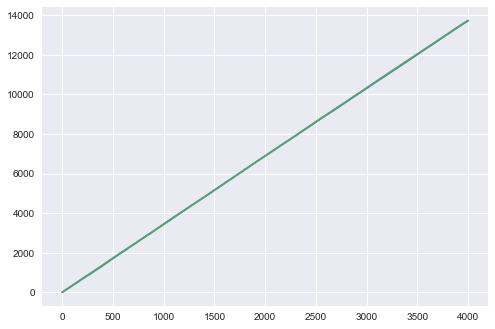

In [89]:
plt.plot(np.cumsum(pg_rs), label='pg')
plt.plot(np.cumsum(rand_rs), label='random')